# Import Necessary Packages

In [27]:
# General
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import time
from collections import Counter
import sys
import os
import datetime
from scipy.spatial.distance import hamming
import seaborn as sns
import scipy as sp
# import matlab.engine
import warnings
warnings.filterwarnings('ignore')
import seaborn as sb
from scipy import stats

# eng = matlab.engine.start_matlab()

# Global Variables

In [28]:
# varlingam
alpha =[0.000001, 0.000005, 0.00001, 0.00005,0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.03, 0.04,0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

# dynotears
alpha_dynotears =[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08,0.09, 0.1]

# calltif
alpha_level = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
# pc_alpha = [0.8, 0.9, 1]
pc_alpha = [1.0]

#pcmci with oracle parent set
alpha_level_pcmci_oracle = [ 1e-8, 1e-7, 1e-6,1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]

# mvgc
mvgc_alpha = [0.4, 0.41 , 0.42,0.43, 0.44, 0.45, 0.46,0.47, 0.48,0.49, 0.5]
mvgc_lags = [3]

# nts-notears
w_threshold = [1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

# all methods with time lags: calltif, mvgc, dynotears, varlingam
tau_max = 3
tau_min = 0

# full macaque data
num_rep_macaque_all = 60
num_rep_macaque = 20

num_session_concatenated = 10
num_sample_each_session = 500
total_num_samples = num_session_concatenated*num_sample_each_session
TR = 1.2

# deconvolution of BOLD signals: NSR (Noise to Signal Ratio)
NSR_all = [0.0, 0.001, 0.01]

# Functions

In [29]:
def import_npz(npz_file):
    Data = np.load(npz_file, allow_pickle= True)
    for varName in Data:
        globals()[varName] = Data[varName]  

# from pcmci
def convert_to_string_graph(graph_bool):
        
        graph = np.zeros(graph_bool.shape, dtype='<U3')
        graph[:] = ""
        # Lagged links
        graph[:,:,1:][graph_bool[:,:,1:]==1] = "-->"
        # Unoriented contemporaneous links
        graph[:,:,0][np.logical_and(graph_bool[:,:,0]==1, 
                                    graph_bool[:,:,0].T==1)] = "o-o"
        # Conflicting contemporaneous links
        graph[:,:,0][np.logical_and(graph_bool[:,:,0]==2, 
                                    graph_bool[:,:,0].T==2)] = "x-x"
        # Directed contemporaneous links
        for (i,j) in zip(*np.where(
            np.logical_and(graph_bool[:,:,0]==1, graph_bool[:,:,0].T==0))):
            graph[i,j,0] = "-->"
            graph[j,i,0] = "<--"

        return graph


# this function reads the output txt file from causal-cmd software 
def monthToNum(shortMonth):
    return {
            'January': 1,
            'February': 2,
            'March': 3,
            'April': 4,
            'May': 5,
            'June': 6,
            'July': 7,
            'August': 8,
            'September': 9, 
            'October': 10,
            'November': 11,
            'December': 12
    }[shortMonth]
    
def tetrad_graph_parser(filename, ground_truth = 0):

    k = 0
    with open(filename) as f:
        for line in f:
            if line == "Graph Nodes:\n":
                nodes_line = k + 1
            if line == "Graph Edges:\n":
                edges_line = k + 1
            if line[0:5] == "Start":
                start_time_line = k
            if line[0:3] == "End":
                end_time_line = k
            k += 1 
    with open(filename) as f:
        all_lines = f.readlines()

    if ground_truth == 1:
        graph_nodes = all_lines[nodes_line].replace("\n","").split(",")
    else:
        graph_nodes = all_lines[nodes_line].replace("\n","").split(";")
        
    graph_edges = all_lines[edges_line:]

    num_nodes = len(graph_nodes)
    num_edges = len(graph_edges)


# calculate the execution time 
    execution_time = 0

    if ground_truth == 0:

        start_temp = all_lines[start_time_line][13:].replace("\n","").split(",")
        end_temp = all_lines[end_time_line][12:].replace("\n","").split(",")

        start_date = start_temp[1].split(" ")
        end_date = end_temp[1].split(" ")

        start_month = monthToNum(start_date[1])
        end_month = monthToNum(end_date[1])

        start_day = int(start_date[2])
        end_day = int(end_date[2])

        start_year = int(start_temp[2].split(" ")[1])
        end_year = int(end_temp[2].split(" ")[1])

        start_time = start_temp[2].split(" ")[2].split(":")
        end_time = end_temp[2].split(" ")[2].split(":")
        
        start_am_pm = start_temp[2].split(" ")[3]
        end_am_pm = end_temp[2].split(" ")[3]


        start_hour = int(start_time[0])
        start_min = int(start_time[1])
        start_second = int(start_time[2])

        end_hour = int(end_time[0])
        end_min = int(end_time[1])
        end_second = int(end_time[2])


        if (start_am_pm == 'PM') and (start_hour != 12):
            start_hour = start_hour + 12

        if (end_am_pm == 'PM') and (end_hour != 12):
            end_hour = end_hour + 12
        
        if (start_am_pm == 'AM') and (start_hour == 12):
            start_hour = 0

        if (end_am_pm == 'AM') and (end_hour == 12):
            end_hour = 0


        dt1 = datetime.datetime(start_year,start_month,start_day,start_hour,start_min,start_second) 
        dt2 = datetime.datetime(end_year,end_month,end_day,end_hour,end_min,end_second) 
        tdelta = dt2 - dt1 
        
        execution_time = tdelta.total_seconds()

        print(dt1, dt2,execution_time)


        # execution_time = end_total_sec - start_total_sec 
        
    graph_matrix = np.zeros((num_nodes,num_nodes))

    for e in range(0, num_edges):

        current_edge = graph_edges[e].replace(str(e+1)+".","").replace("\n","").replace(" ","").split("-->")
        i = int(current_edge[0].replace('X',''))-1
        j = int(current_edge[1].replace('X',''))-1

        graph_matrix[i,j] = 1

    return graph_nodes, graph_edges, graph_matrix, execution_time

# This function creats a time lag graph from the dictionary
def make_time_lag_graph_from_dict(graph_dict, tau_max):
    dict_vars = graph_dict.keys()
    num_vars = len(dict_vars)

    time_lag_graph = [[['' for t in range(0, tau_max+1)] for j in range(0,num_vars)] for i in range(0, num_vars)]

    for v1 in range(0,num_vars):
        var_name = 'X%d'%(v1+1)
        var_time_lags = graph_dict[var_name]

        for v2 in range(0,num_vars):
            for t in range(0,tau_max+1):
                if ('X%d'%(v2+1),-t) in var_time_lags:
                    time_lag_graph[v2][v1][t] = '-->'
                else:
                    time_lag_graph[v2][v1][t] = ''

    return time_lag_graph


# These set of functiona summarize a time lag graph to a summary graph by combining the edges accross the lags
def summarize_across_nonzero_lags(PAG):

        PAG_non_zero_lags = PAG[:,:,1:]
        m = PAG_non_zero_lags.shape[0]
        num_lags = PAG_non_zero_lags.shape[2]

        PAG_non_zero_lags_binary = np.zeros((m,m, num_lags))
        PAG_non_zero_lags_binary[PAG_non_zero_lags == '-->'] = 1

        binary_matrix = np.sum(PAG_non_zero_lags_binary, axis = 2)
        binary_matrix[binary_matrix >= 1] = 1

        return binary_matrix
# The following functions are defined to summarize a time-series graph to a DAG

def summarize_across_all_lags_v1(time_lag_graph):

    num_vars = time_lag_graph.shape[0]
    num_lags = time_lag_graph.shape[2]

    summary_graph = [['' for t in range(0, num_vars)] for i in range(0, num_vars)]

    adjacency_binary_matrix = np.zeros((num_vars, num_vars))
    orientation_binary_matrix = np.zeros((num_vars, num_vars))

    for i in range(0,num_vars):
        for j in range(0,num_vars):

            edges_all_lags  = time_lag_graph[i,j,:]

            if '-->' in edges_all_lags:
                summary_graph[i][j] = '-->'

                adjacency_binary_matrix[i,j] = 1
                orientation_binary_matrix[i,j] = 1

            elif ('-->' not in edges_all_lags and 'o-o' in edges_all_lags):
                summary_graph[i][j] = 'o-o'
                
                adjacency_binary_matrix[i,j] = 1
                orientation_binary_matrix[i,j] = 0

            else:
                summary_graph[i][j] = ''
                
                adjacency_binary_matrix[i,j] = 0
                orientation_binary_matrix[i,j] = 0

    
    return summary_graph, adjacency_binary_matrix, orientation_binary_matrix

def summarize_across_all_lags_v2(time_lag_graph):

    num_vars = time_lag_graph.shape[0]
    num_lags = time_lag_graph.shape[2]

    summary_graph = [['' for t in range(0, num_vars)] for i in range(0, num_vars)]

    adjacency_binary_matrix = np.zeros((num_vars, num_vars))
    orientation_binary_matrix = np.zeros((num_vars, num_vars))

    for i in range(0,num_vars):
        for j in range(0,num_vars):

            edges_all_lags  = time_lag_graph[i,j,:]

            if '-->' in edges_all_lags:
                summary_graph[i][j] = '-->'

                adjacency_binary_matrix[i,j] = 1
                orientation_binary_matrix[i,j] = 1

            elif ('-->' not in edges_all_lags and 'o-o' in edges_all_lags):
                summary_graph[i][j] = 'o-o'
                
                adjacency_binary_matrix[i,j] = 1
                orientation_binary_matrix[i,j] = 1

            else:
                summary_graph[i][j] = ''
                
                adjacency_binary_matrix[i,j] = 0
                orientation_binary_matrix[i,j] = 0

    
    return summary_graph, adjacency_binary_matrix, orientation_binary_matrix


# The following function computes TPR,FPR, Recall, Precision, and F1 score for an estimated graph
def find_tpr_fpr_nonzero_lags(true_graph_matrix, estimated_graph_matrix):

    adj_TP = 0
    adj_FN = 0
    adj_FP = 0
    adj_TN = 0

    n, m = np.shape(true_graph_matrix)

    for i in range(n):
        for j in range(i):

            if (true_graph_matrix[i,j] or  true_graph_matrix[j,i] ) == 1 and (estimated_graph_matrix[i,j] or  estimated_graph_matrix[j,i] ) == 1:
                adj_TP += 1
            elif (true_graph_matrix[i,j] or  true_graph_matrix[j,i] ) == 0 and (estimated_graph_matrix[i,j] or  estimated_graph_matrix[j,i] ) == 0:
                adj_TN += 1 
            elif (true_graph_matrix[i,j] or  true_graph_matrix[j,i] ) == 1 and (estimated_graph_matrix[i,j] or  estimated_graph_matrix[j,i] ) == 0:
                adj_FN += 1 
            elif (true_graph_matrix[i,j] or  true_graph_matrix[j,i] ) == 0 and (estimated_graph_matrix[i,j] or  estimated_graph_matrix[j,i] ) == 1:
                adj_FP += 1 

    if adj_FN == 0:
        adjacency_TPR = 1
    else:
        adjacency_TPR = adj_TP/(adj_TP + adj_FN)

    if adj_TN == 0:
        adjacency_FPR = 1
    else:
         adjacency_FPR = adj_FP/(adj_FP + adj_TN)

    if adj_FN == 0:
        adjacency_Recall = 1
    else:
        adjacency_Recall = adj_TP/(adj_TP + adj_FN)

    if adj_FP == 0:
        adjacency_Precision = 1
    else:
        adjacency_Precision = adj_TP/(adj_TP + adj_FP)

    if adjacency_Recall == 0 and adjacency_Precision == 0:
        adjacency_F1_score = 0
    else:
        adjacency_F1_score = 2*adjacency_Recall*adjacency_Precision/(adjacency_Precision + adjacency_Recall)


    ori_TP = 0
    ori_FN = 0
    ori_FP = 0
    ori_TN = 0

    n, m = np.shape(true_graph_matrix)

    for i in range(n):
        for j in range(m):

            if (true_graph_matrix[i,j]  == 1) and (estimated_graph_matrix[i,j] == 1):
                ori_TP += 1
            elif (true_graph_matrix[i,j]  == 0) and (estimated_graph_matrix[i,j] == 0):
                ori_TN += 1 
            elif (true_graph_matrix[i,j]  == 1) and (estimated_graph_matrix[i,j] == 0):
                ori_FN += 1 
            elif (true_graph_matrix[i,j]  == 0) and (estimated_graph_matrix[i,j] == 1):
                ori_FP += 1 

    if ori_FN == 0:
        orientation_TPR = 1
    else:
         orientation_TPR = ori_TP/(ori_TP + ori_FN)

    if ori_TN == 0:
        orientation_FPR = 1
    else:
        orientation_FPR = ori_FP/(ori_FP + ori_TN)

    if ori_FN == 0:
        orientation_Recall = 1
    else:
        orientation_Recall = ori_TP/(ori_TP + ori_FN)

    if ori_FP == 0:
        orientation_Precision = 1
    else:
        orientation_Precision = ori_TP/(ori_TP + ori_FP)

    if orientation_Recall == 0 and orientation_Precision == 0:
        orientation_F1_score = 0
    else:
        orientation_F1_score = 2*orientation_Recall*orientation_Precision/(orientation_Precision + orientation_Recall)

    return adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score


def find_tpr_fpr_all_lags(true_graph_matrix, estimated_adjacency_binary_matrix, estimated_orientation_binary_matrix):

    adj_TP = 0
    adj_FN = 0
    adj_FP = 0
    adj_TN = 0

    n, m = np.shape(true_graph_matrix)

    for i in range(n):
        for j in range(i):

            if (true_graph_matrix[i,j] or  true_graph_matrix[j,i] ) == 1 and (estimated_adjacency_binary_matrix[i,j] or  estimated_adjacency_binary_matrix[j,i] ) == 1:
                adj_TP += 1
            elif (true_graph_matrix[i,j] or  true_graph_matrix[j,i] ) == 0 and (estimated_adjacency_binary_matrix[i,j] or  estimated_adjacency_binary_matrix[j,i] ) == 0:
                adj_TN += 1 
            elif (true_graph_matrix[i,j] or  true_graph_matrix[j,i] ) == 1 and (estimated_adjacency_binary_matrix[i,j] or  estimated_adjacency_binary_matrix[j,i] ) == 0:
                adj_FN += 1 
            elif (true_graph_matrix[i,j] or  true_graph_matrix[j,i] ) == 0 and (estimated_adjacency_binary_matrix[i,j] or  estimated_adjacency_binary_matrix[j,i] ) == 1:
                adj_FP += 1 

    if adj_FN == 0:
        adjacency_TPR = 1
    else:
        adjacency_TPR = adj_TP/(adj_TP + adj_FN)

    if adj_TN == 0:
        adjacency_FPR = 1
    else:
         adjacency_FPR = adj_FP/(adj_FP + adj_TN)

    if adj_FN == 0:
        adjacency_Recall = 1
    else:
        adjacency_Recall = adj_TP/(adj_TP + adj_FN)

    if adj_FP == 0:
        adjacency_Precision = 1
    else:
        adjacency_Precision = adj_TP/(adj_TP + adj_FP)

    if adjacency_Recall == 0 and adjacency_Precision == 0:
        adjacency_F1_score = 0
    else:
        adjacency_F1_score = 2*adjacency_Recall*adjacency_Precision/(adjacency_Precision + adjacency_Recall)


    ori_TP = 0
    ori_FN = 0
    ori_FP = 0
    ori_TN = 0

    n, m = np.shape(true_graph_matrix)

    for i in range(n):
        for j in range(m):

            if (true_graph_matrix[i,j]  == 1) and (estimated_orientation_binary_matrix[i,j] == 1):
                ori_TP += 1
            elif (true_graph_matrix[i,j]  == 0) and (estimated_orientation_binary_matrix[i,j] == 0):
                ori_TN += 1 
            elif (true_graph_matrix[i,j]  == 1) and (estimated_orientation_binary_matrix[i,j] == 0):
                ori_FN += 1 
            elif (true_graph_matrix[i,j]  == 0) and (estimated_orientation_binary_matrix[i,j] == 1):
                ori_FP += 1 

    if ori_FN == 0:
        orientation_TPR = 1
    else:
         orientation_TPR = ori_TP/(ori_TP + ori_FN)

    if ori_TN == 0:
        orientation_FPR = 1
    else:
        orientation_FPR = ori_FP/(ori_FP + ori_TN)

    if ori_FN == 0:
        orientation_Recall = 1
    else:
        orientation_Recall = ori_TP/(ori_TP + ori_FN)

    if ori_FP == 0:
        orientation_Precision = 1
    else:
        orientation_Precision = ori_TP/(ori_TP + ori_FP)

    if orientation_Recall == 0 and orientation_Precision == 0:
        orientation_F1_score = 0
    else:
        orientation_F1_score = 2*orientation_Recall*orientation_Precision/(orientation_Precision + orientation_Recall)

    return adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score


# Macaque Full Graph

In [30]:
# path_to_Macaque = "/home/fahimeh/Volitional_Control_Neurofeedback/Non-DecNef/codes/Causality_Analysis/Dataset/DataSets_Feedbacks/2_Macaque_Networks/Full/data_fslfilter_concat"

# num_nodes_macaque_full = 91
# nodes_macaque_full = ['X%d'%i for i in range(1,num_nodes_macaque_full+1)]

# macaque_all_data_full = [0]*num_rep_macaque_all

# for i in range (1,num_rep_macaque_all + 1):
#     if i <= 9:
#         current_str = "0"+str(i)
#     elif 10 <= i:
#         current_str = str(i)

#     df_temp  = pd.read_csv(path_to_Macaque+"/concat_BOLDfslfilter_"+current_str+".txt", delimiter = '\t')
#     macaque_all_data_full[i-1] = df_temp.to_numpy()
# print('sample data:\n', df_temp)

In [31]:
path_to_Macaque = "/home/fahimeh/Volitional_Control_Neurofeedback/Non-DecNef/codes/Causality_Analysis/Dataset/DataSets_Feedbacks/2_Macaque_Networks/Full/data_fslfilter_concat"

num_nodes_macaque_full = 91
nodes_macaque_full = ['X%d'%i for i in range(1,num_nodes_macaque_full+1)]

macaque_all_data_full = [[0 for t in range(0, num_session_concatenated)] for j in range(0,num_rep_macaque_all)] 
macaque_all_data_full_concat = []*num_rep_macaque_all

for i in range (1,num_rep_macaque_all + 1):
    if i <= 9:
        current_str = "0"+str(i)
    elif 10 <= i:
        current_str = str(i)

    data_concat  = pd.read_csv(path_to_Macaque+"/concat_BOLDfslfilter_"+current_str+".txt", delimiter = '\t').to_numpy()
    macaque_all_data_full_concat.append(data_concat)
    
    for j in range(0,num_session_concatenated):
        macaque_all_data_full[i-1][j] = data_concat[int(j*num_sample_each_session):int((j+1)*num_sample_each_session)]


## Ground Truth Graph 

In [32]:
path_to_ground_truth = '/home/fahimeh/Volitional_Control_Neurofeedback/Non-DecNef/codes/Causality_Analysis/Tetrad_Simulations/Causal_cmd/Ground_Truth_Graphs/'
filename = path_to_ground_truth + "Macaque_Full_graph.txt"
ground_truth_nodes_macaques_full, ground_truth_edges_macaques_full, ground_truth_graph_matrix_macaques_full, ground_truth_execution_time_macaques_full= tetrad_graph_parser(filename, ground_truth = 1)

## Macaque Full Deconvolved

In [33]:
# macaque_all_data_full = [0]*num_rep_macaque
# data_concat_deconv_all = [[0 for t in range(0, len(NSR_all))] for k in range(0,num_rep_macaque)]

# for r in range (1,num_rep_macaque + 1):
#     if r <= 9:
#         current_str = "0"+str(r)
#     elif 10 <= r:
#         current_str = str(r)

#     df_temp  = pd.read_csv(path_to_Macaque+"/concat_BOLDfslfilter_"+current_str+".txt", delimiter = '\t')
#     macaque_all_data_full[r-1] = df_temp.to_numpy()

#     data_concat = np.array(macaque_all_data_full[r-1])
#     data_concat_deconv = np.zeros_like(data_concat)

#     for sn in range(0,len(NSR_all)):
#             print('repetition:', r, 'NSR:', NSR_all[sn])

#             HRF_deconv_NSR = NSR_all[sn]

#             for i in range(0, num_nodes_macaque_full):
#                 for j in range(0,num_session_concatenated):

#                     current_data_sample = data_concat[j*num_sample_each_session:(j+1)*num_sample_each_session,i]
#                     current_data_sample_deconv = eng.HRF_deconv(matlab.double(current_data_sample.tolist()), TR, HRF_deconv_NSR, nargout = 1)
#                     data_concat_deconv[j*num_sample_each_session:(j+1)*num_sample_each_session,i] = np.array(current_data_sample_deconv)

#             data_concat_deconv_all[r-1][sn] = data_concat_deconv

In [34]:
# np.savez('macaque_full_deconvolved_data', NSR_all = NSR_all, data_concat_deconv_all = data_concat_deconv_all )

# Causal Discovery Methods

## Load saved results

In [35]:
# with max_lag = 3
import_npz('results_all_method_mecaque/CaLLTiF_macaque_full_sweep_both_alpha_lag_3.npz')
import_npz('results_all_method_mecaque/MVGC_macaque_full_sweep_both_parameters_all_reps.npz')
import_npz('results_all_method_mecaque/Varlingam_macaque_full_sweep_alpha_lag_3.npz')
import_npz('results_all_method_mecaque/Dynotears_macaque_full_sweep_alpha_lag_3.npz')
import_npz('results_all_method_mecaque/CaLLTiF_macaque_full_deconvolved_lag_3.npz')
import_npz('results_all_method_mecaque/PCMCI_macaque_full_oracle.npz')
import_npz('results_all_method_mecaque/NTS_notears_macaque_full.npz')

## CaLLTiF

### CaLLTiF Execution Time

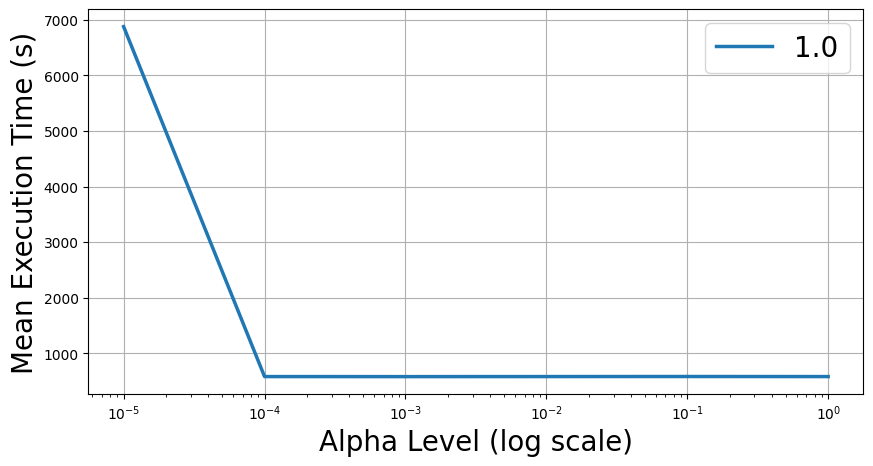

In [36]:
CaLLTiF_Mean_Exe_Time_Macaque = np.zeros((len(pc_alpha), len(alpha_level)))
plt.figure(figsize = (10,5))

for a1 in range(0,len(pc_alpha)):
    for a2 in range(0, len(alpha_level)):
        temp = np.array(calltif_macaque_execution_time)[0:num_rep_macaque,a1,a2]

        CaLLTiF_Mean_Exe_Time_Macaque[a1][a2] = np.mean(temp)

    plt.plot(alpha_level, CaLLTiF_Mean_Exe_Time_Macaque[a1][:], linewidth = 2.5)
    plt.xscale('log')
    plt.xlabel('Alpha Level (log scale)', fontsize = 20)
    plt.ylabel('Mean Execution Time (s)', fontsize = 20)
    plt.grid()
plt.legend(pc_alpha,fontsize = 20)

### PCMCI with zero lag: Mixed-PCMCI

In [37]:
mixed_pcmci_adj_TPR_all_rep_macaque_both_alpha = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]
mixed_pcmci_adj_FPR_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]
mixed_pcmci_adj_Recall_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]
mixed_pcmci_adj_Precision_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]
mixed_pcmci_adj_F1_score_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]

mixed_pcmci_ori_TPR_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]
mixed_pcmci_ori_FPR_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]
mixed_pcmci_ori_Recall_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]
mixed_pcmci_ori_Precision_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]
mixed_pcmci_ori_F1_score_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]

macaque_ground_truth = ground_truth_graph_matrix_macaques_full

for r in range(0,num_rep_macaque):
    for a1 in range(0, len(pc_alpha)):
        for a2 in range(0, len(alpha_level)):

            PAG = np.array(calltif_link_matrix_all_macaque[r][a1][a2])

            summary_graph, estimated_adjacency_binary_matrix, estimated_orientation_binary_matrix = summarize_across_all_lags_v1(PAG)
            adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = find_tpr_fpr_all_lags(macaque_ground_truth, estimated_adjacency_binary_matrix, estimated_orientation_binary_matrix)
            
            mixed_pcmci_adj_TPR_all_rep_macaque_both_alpha[r][a1][a2] = adjacency_TPR
            mixed_pcmci_adj_FPR_all_rep_macaque_both_alpha[r][a1][a2]  = adjacency_FPR
            mixed_pcmci_adj_Recall_all_rep_macaque_both_alpha[r][a1][a2]  = adjacency_Recall
            mixed_pcmci_adj_Precision_all_rep_macaque_both_alpha[r][a1][a2] = adjacency_Precision
            mixed_pcmci_adj_F1_score_all_rep_macaque_both_alpha[r][a1][a2] = adjacency_F1_score

            mixed_pcmci_ori_TPR_all_rep_macaque_both_alpha[r][a1][a2] = orientation_TPR
            mixed_pcmci_ori_FPR_all_rep_macaque_both_alpha[r][a1][a2]= orientation_FPR
            mixed_pcmci_ori_Recall_all_rep_macaque_both_alpha[r][a1][a2] = orientation_Recall
            mixed_pcmci_ori_Precision_all_rep_macaque_both_alpha[r][a1][a2]  = orientation_Precision
            mixed_pcmci_ori_F1_score_all_rep_macaque_both_alpha[r][a1][a2] = orientation_F1_score

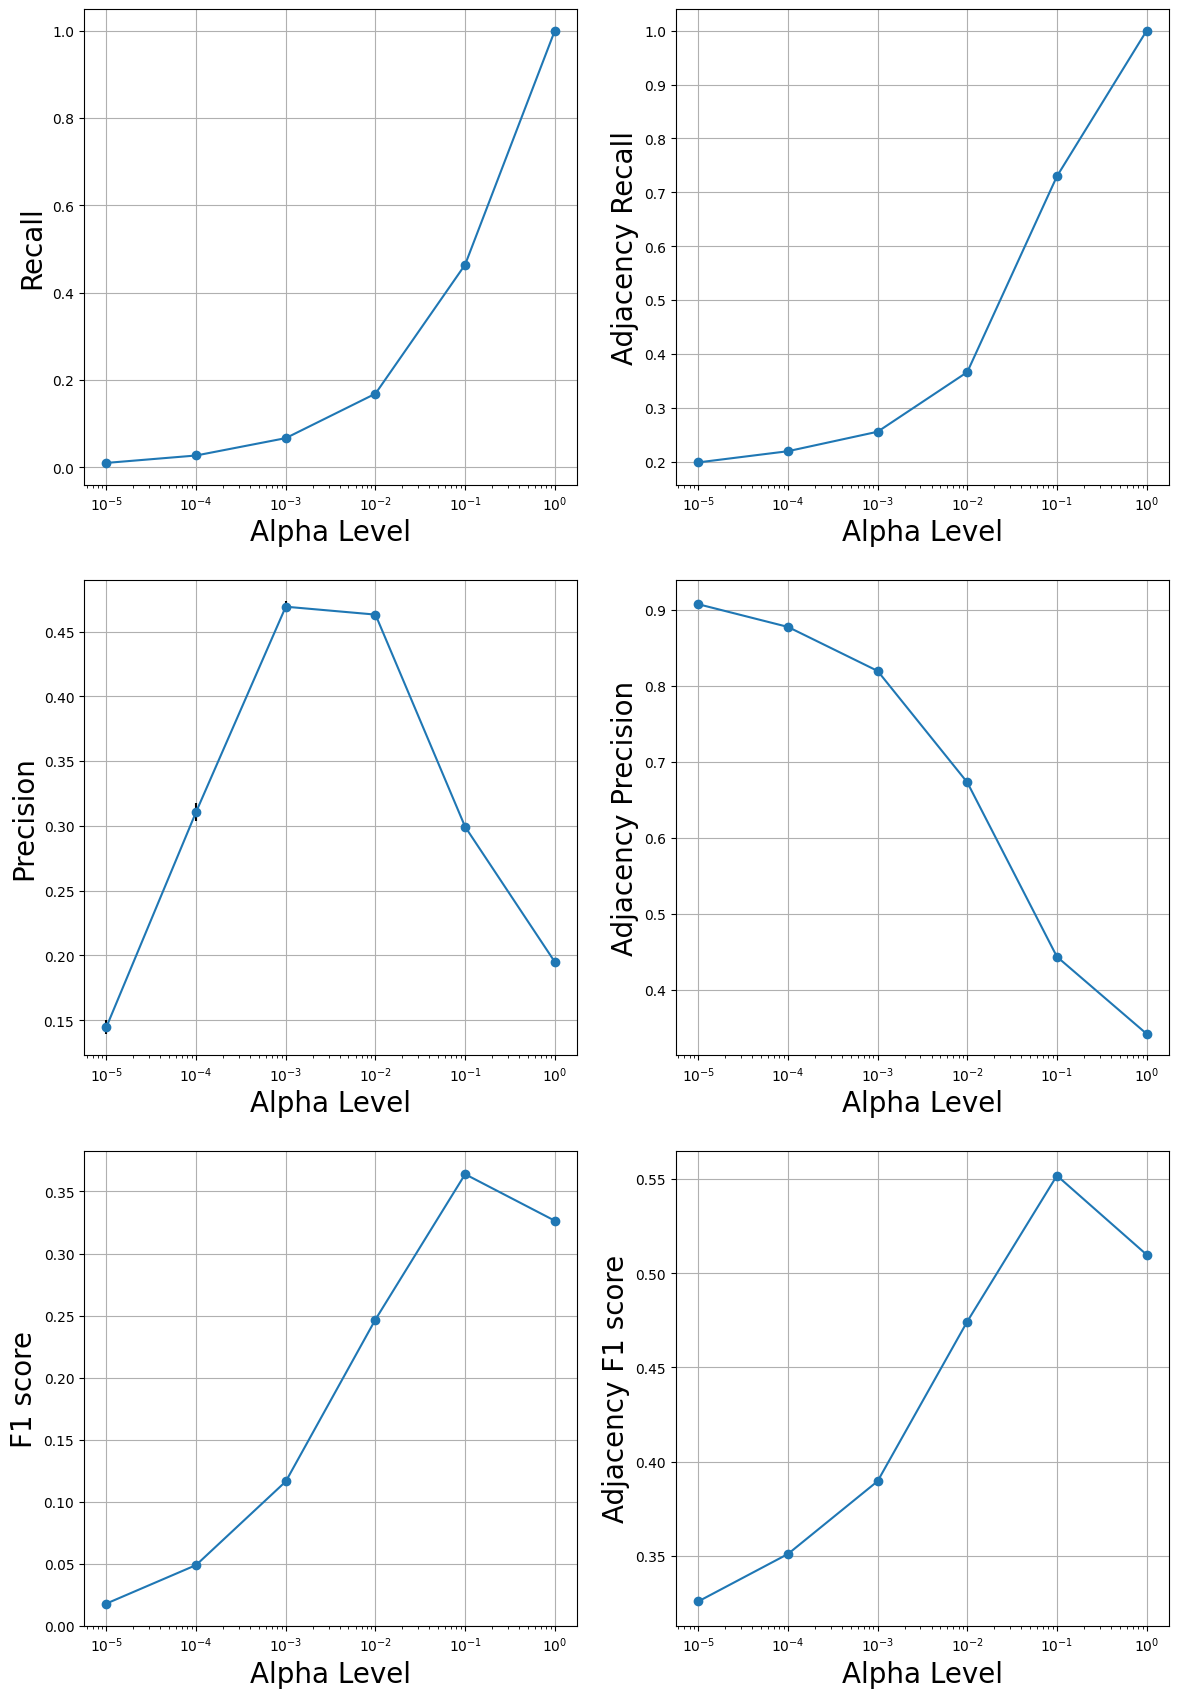

In [38]:
plt.figure(figsize = (14, 21))

for k in range(0, len(pc_alpha)):

    mixed_pcmci_adj_recall_mean_macaque = np.zeros_like(alpha_level)
    mixed_pcmci_adj_recall_std_macaque = np.zeros_like(alpha_level)
    mixed_pcmci_adj_recall_median_macaque = np.zeros_like(alpha_level)

    mixed_pcmci_adj_precision_mean_macaque = np.zeros_like(alpha_level) 
    mixed_pcmci_adj_precision_std_macaque = np.zeros_like(alpha_level)
    mixed_pcmci_adj_precision_median_macaque = np.zeros_like(alpha_level) 

    mixed_pcmci_adj_F1_score_mean_macaque = np.zeros_like(alpha_level) 
    mixed_pcmci_adj_F1_score_std_macaque = np.zeros_like(alpha_level)
    mixed_pcmci_adj_F1_score_median_macaque = np.zeros_like(alpha_level) 

    mixed_pcmci_ori_recall_mean_macaque = np.zeros_like(alpha_level)
    mixed_pcmci_ori_recall_std_macaque = np.zeros_like(alpha_level)
    mixed_pcmci_ori_recall_median_macaque = np.zeros_like(alpha_level)

    mixed_pcmci_ori_precision_mean_macaque = np.zeros_like(alpha_level)
    mixed_pcmci_ori_precision_std_macaque = np.zeros_like(alpha_level)
    mixed_pcmci_ori_precision_median_macaque = np.zeros_like(alpha_level)

    mixed_pcmci_ori_F1_score_mean_macaque = np.zeros_like(alpha_level)
    mixed_pcmci_ori_F1_score_std_macaque =np.zeros_like(alpha_level)
    mixed_pcmci_ori_F1_score_median_macaque = np.zeros_like(alpha_level)

    for a in range(0,len(alpha_level)):

        mixed_pcmci_adj_recall_mean_macaque[a] = np.mean(np.array(mixed_pcmci_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_adj_recall_std_macaque[a] = np.std(np.array(mixed_pcmci_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_adj_recall_median_macaque[a] = np.median(np.array(mixed_pcmci_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])

        mixed_pcmci_adj_precision_mean_macaque[a] = np.mean(np.array(mixed_pcmci_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_adj_precision_std_macaque[a] = np.std(np.array(mixed_pcmci_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_adj_precision_median_macaque[a] = np.median(np.array(mixed_pcmci_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])


        mixed_pcmci_adj_F1_score_mean_macaque[a] = np.mean(np.array(mixed_pcmci_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_adj_F1_score_std_macaque[a] = np.std(np.array(mixed_pcmci_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_adj_F1_score_median_macaque[a] = np.median(np.array(mixed_pcmci_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])

        mixed_pcmci_ori_recall_mean_macaque[a] = np.mean(np.array(mixed_pcmci_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_ori_recall_std_macaque[a] = np.std(np.array(mixed_pcmci_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_ori_recall_median_macaque[a] = np.median(np.array(mixed_pcmci_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])

        mixed_pcmci_ori_precision_mean_macaque[a] = np.mean(np.array(mixed_pcmci_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_ori_precision_std_macaque[a] = np.std(np.array(mixed_pcmci_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_ori_precision_median_macaque[a] = np.median(np.array(mixed_pcmci_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])

        mixed_pcmci_ori_F1_score_mean_macaque[a] = np.mean(np.array(mixed_pcmci_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_ori_F1_score_std_macaque[a] = np.std(np.array(mixed_pcmci_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        mixed_pcmci_ori_F1_score_median_macaque[a] = np.median(np.array(mixed_pcmci_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])

    mixed_pcmci_best_alpha_adj_mean= alpha_level[np.argmax(mixed_pcmci_adj_F1_score_mean_macaque)]
    mixed_pcmci_best_alpha_adj_median = alpha_level[np.argmax(mixed_pcmci_adj_F1_score_median_macaque)]
    mixed_pcmci_best_alpha_ori_mean = alpha_level[np.argmax(mixed_pcmci_ori_F1_score_mean_macaque)]
    mixed_pcmci_best_alpha_ori_median = alpha_level[np.argmax(mixed_pcmci_ori_F1_score_median_macaque)]

    plt.subplot(3,2,2)
    plt.errorbar(alpha_level, mixed_pcmci_adj_recall_mean_macaque, mixed_pcmci_adj_recall_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Adjacency Recall', fontsize = 20)
    plt.grid()
    plt.grid(visible = True)


    plt.subplot(3,2,1)
    plt.errorbar(alpha_level, mixed_pcmci_ori_recall_mean_macaque, mixed_pcmci_ori_recall_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Recall', fontsize = 20)
    plt.grid(visible = True)


    plt.subplot(3,2,4)
    plt.errorbar(alpha_level, mixed_pcmci_adj_precision_mean_macaque, mixed_pcmci_adj_precision_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Adjacency Precision', fontsize = 20)
    plt.grid(visible = True)


    plt.subplot(3,2,3)
    plt.errorbar(alpha_level, mixed_pcmci_ori_precision_mean_macaque, mixed_pcmci_ori_precision_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Precision', fontsize = 20)
    plt.grid(visible = True)


    plt.subplot(3,2,6)
    plt.errorbar(alpha_level, mixed_pcmci_adj_F1_score_mean_macaque, mixed_pcmci_adj_F1_score_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Adjacency F1 score', fontsize = 20)
    plt.grid(visible = True)


    plt.subplot(3,2,5)
    plt.errorbar(alpha_level, mixed_pcmci_ori_F1_score_mean_macaque, mixed_pcmci_ori_F1_score_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('F1 score', fontsize = 20)
    plt.grid(visible = True)


### PCMCI without zero lag: PCMCI

In [39]:
pcmci_adj_TPR_all_rep_macaque_both_alpha = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]
pcmci_adj_FPR_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]
pcmci_adj_Recall_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]
pcmci_adj_Precision_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]
pcmci_adj_F1_score_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]

pcmci_ori_TPR_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]
pcmci_ori_FPR_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]
pcmci_ori_Recall_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]
pcmci_ori_Precision_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]
pcmci_ori_F1_score_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]

macaque_ground_truth = ground_truth_graph_matrix_macaques_full

for r in range(0,num_rep_macaque):
    for a1 in range(0, len(pc_alpha)):
        for a2 in range(0, len(alpha_level)):

            PAG = np.array(calltif_link_matrix_all_macaque[r][a1][a2])


            estimated_non_zero_lags_combined = summarize_across_nonzero_lags(PAG)
            adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = find_tpr_fpr_nonzero_lags(macaque_ground_truth, estimated_non_zero_lags_combined)

            pcmci_adj_TPR_all_rep_macaque_both_alpha[r][a1][a2] = adjacency_TPR
            pcmci_adj_FPR_all_rep_macaque_both_alpha[r][a1][a2]  = adjacency_FPR
            pcmci_adj_Recall_all_rep_macaque_both_alpha[r][a1][a2]  = adjacency_Recall
            pcmci_adj_Precision_all_rep_macaque_both_alpha[r][a1][a2] = adjacency_Precision
            pcmci_adj_F1_score_all_rep_macaque_both_alpha[r][a1][a2] = adjacency_F1_score

            pcmci_ori_TPR_all_rep_macaque_both_alpha[r][a1][a2] = orientation_TPR
            pcmci_ori_FPR_all_rep_macaque_both_alpha[r][a1][a2]= orientation_FPR
            pcmci_ori_Recall_all_rep_macaque_both_alpha[r][a1][a2] = orientation_Recall
            pcmci_ori_Precision_all_rep_macaque_both_alpha[r][a1][a2]  = orientation_Precision
            pcmci_ori_F1_score_all_rep_macaque_both_alpha[r][a1][a2] = orientation_F1_score


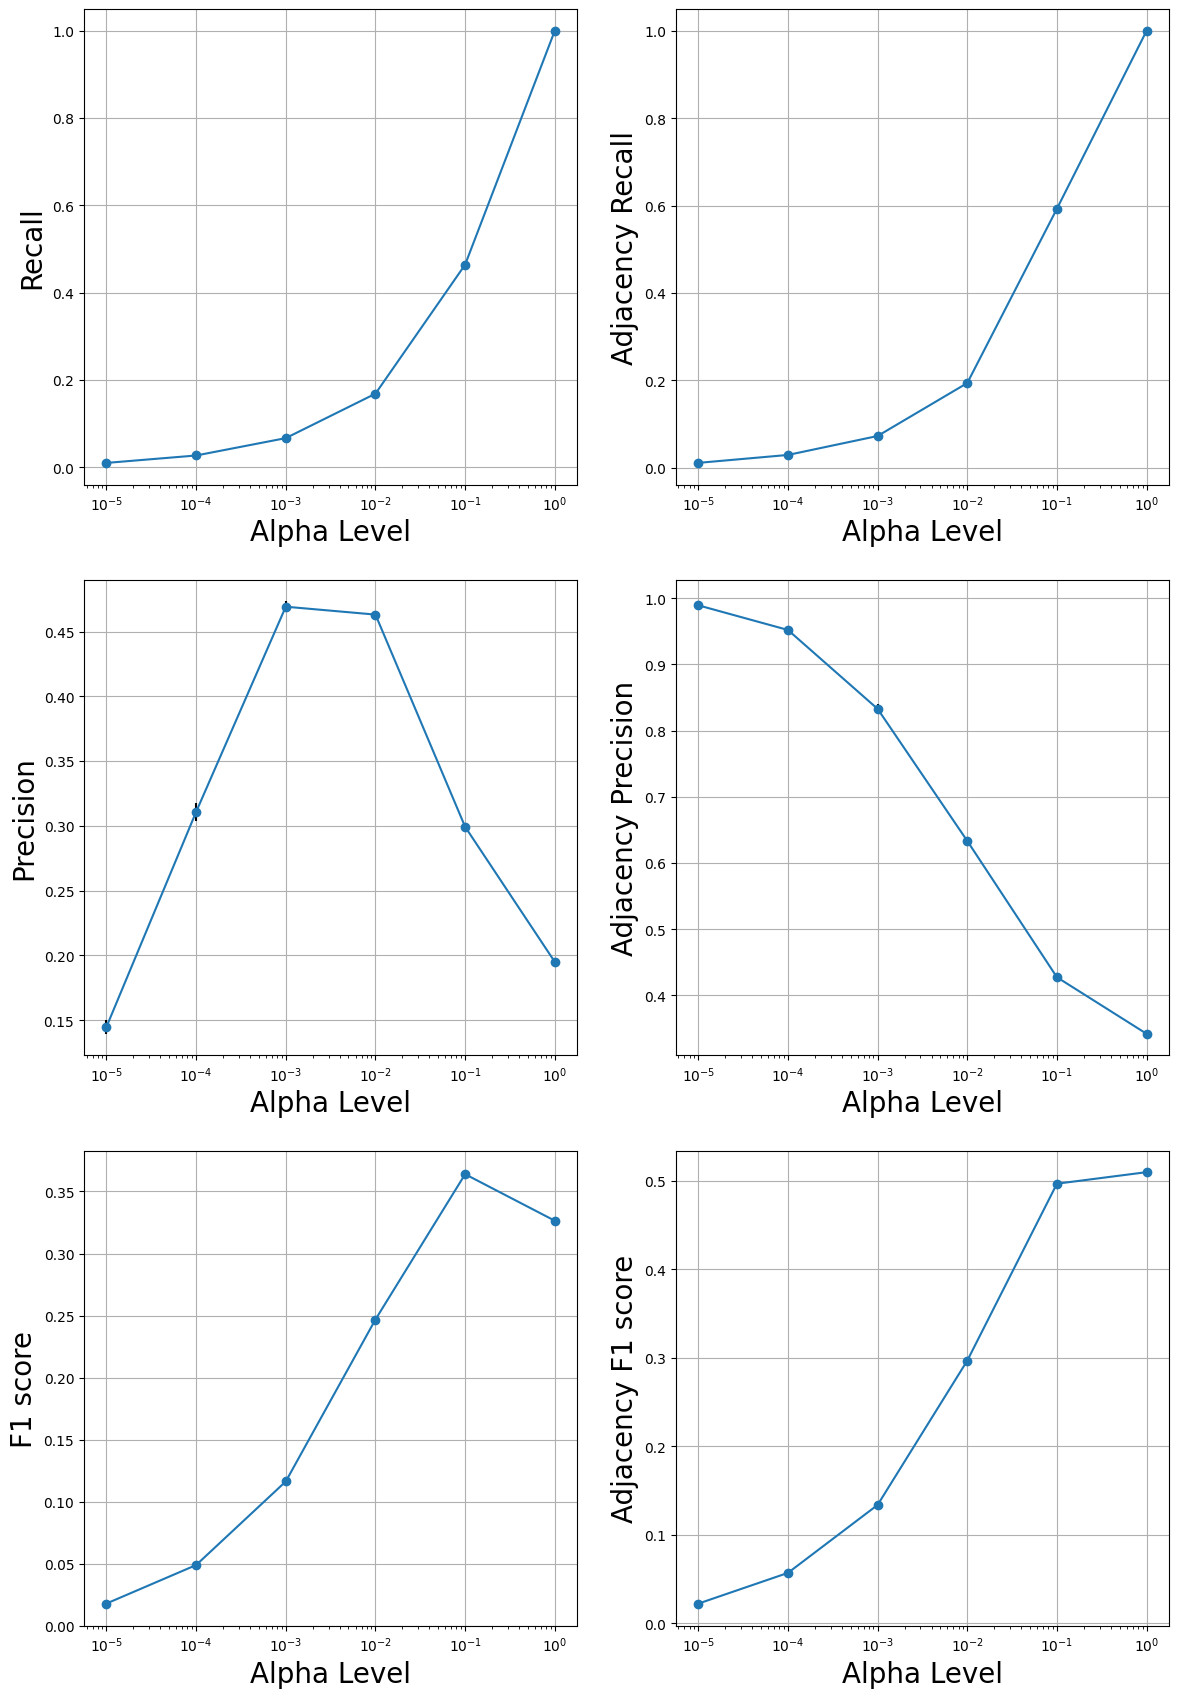

In [40]:
plt.figure(figsize = (14, 21))

for k in range(0, len(pc_alpha)):

    pcmci_adj_recall_mean_macaque = np.zeros_like(alpha_level)
    pcmci_adj_recall_std_macaque = np.zeros_like(alpha_level)
    pcmci_adj_recall_median_macaque = np.zeros_like(alpha_level)

    pcmci_adj_precision_mean_macaque = np.zeros_like(alpha_level) 
    pcmci_adj_precision_std_macaque = np.zeros_like(alpha_level)
    pcmci_adj_precision_median_macaque = np.zeros_like(alpha_level) 

    pcmci_adj_F1_score_mean_macaque = np.zeros_like(alpha_level) 
    pcmci_adj_F1_score_std_macaque = np.zeros_like(alpha_level)
    pcmci_adj_F1_score_median_macaque = np.zeros_like(alpha_level) 

    pcmci_ori_recall_mean_macaque = np.zeros_like(alpha_level)
    pcmci_ori_recall_std_macaque = np.zeros_like(alpha_level)
    pcmci_ori_recall_median_macaque = np.zeros_like(alpha_level)

    pcmci_ori_precision_mean_macaque = np.zeros_like(alpha_level)
    pcmci_ori_precision_std_macaque = np.zeros_like(alpha_level)
    pcmci_ori_precision_median_macaque = np.zeros_like(alpha_level)

    pcmci_ori_F1_score_mean_macaque = np.zeros_like(alpha_level)
    pcmci_ori_F1_score_std_macaque =np.zeros_like(alpha_level)
    pcmci_ori_F1_score_median_macaque = np.zeros_like(alpha_level)


    for a in range(0,len(alpha_level)):

        pcmci_adj_recall_mean_macaque[a] = np.mean(np.array(pcmci_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_adj_recall_std_macaque[a] = np.std(np.array(pcmci_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_adj_recall_median_macaque[a] = np.median(np.array(pcmci_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])


        pcmci_adj_precision_mean_macaque[a] = np.mean(np.array(pcmci_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_adj_precision_std_macaque[a] = np.std(np.array(pcmci_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_adj_precision_median_macaque[a] = np.median(np.array(pcmci_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])


        pcmci_adj_F1_score_mean_macaque[a] = np.mean(np.array(pcmci_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_adj_F1_score_std_macaque[a] = np.std(np.array(pcmci_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_adj_F1_score_median_macaque[a] = np.median(np.array(pcmci_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])


        pcmci_ori_recall_mean_macaque[a] = np.mean(np.array(pcmci_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_ori_recall_std_macaque[a] = np.std(np.array(pcmci_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_ori_recall_median_macaque[a] = np.median(np.array(pcmci_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])


        pcmci_ori_precision_mean_macaque[a] = np.mean(np.array(pcmci_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_ori_precision_std_macaque[a] = np.std(np.array(pcmci_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_ori_precision_median_macaque[a] = np.median(np.array(pcmci_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])


        pcmci_ori_F1_score_mean_macaque[a] = np.mean(np.array(pcmci_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_ori_F1_score_std_macaque[a] = np.std(np.array(pcmci_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        pcmci_ori_F1_score_median_macaque[a] = np.median(np.array(pcmci_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])

    pcmci_best_alpha_adj_mean= alpha_level[np.argmax(pcmci_adj_F1_score_mean_macaque)]
    pcmci_best_alpha_adj_median = alpha_level[np.argmax(pcmci_adj_F1_score_median_macaque)]
    pcmci_best_alpha_ori_mean = alpha_level[np.argmax(pcmci_ori_F1_score_mean_macaque)]
    pcmci_best_alpha_ori_median = alpha_level[np.argmax(pcmci_ori_F1_score_median_macaque)]

    plt.subplot(3,2,2)
    plt.errorbar(alpha_level, pcmci_adj_recall_mean_macaque, pcmci_adj_recall_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Adjacency Recall', fontsize = 20)
    plt.grid()
    plt.grid(visible = True)


    plt.subplot(3,2,1)
    plt.errorbar(alpha_level, pcmci_ori_recall_mean_macaque, pcmci_ori_recall_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Recall', fontsize = 20)
    plt.grid(visible = True)


    plt.subplot(3,2,4)
    plt.errorbar(alpha_level, pcmci_adj_precision_mean_macaque, pcmci_adj_precision_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Adjacency Precision', fontsize = 20)
    plt.grid(visible = True)


    plt.subplot(3,2,3)
    plt.errorbar(alpha_level, pcmci_ori_precision_mean_macaque, pcmci_ori_precision_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Precision', fontsize = 20)
    plt.grid(visible = True)


    plt.subplot(3,2,6)
    plt.errorbar(alpha_level, pcmci_adj_F1_score_mean_macaque, pcmci_adj_F1_score_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Adjacency F1 score', fontsize = 20)
    plt.grid(visible = True)


    plt.subplot(3,2,5)
    plt.errorbar(alpha_level, pcmci_ori_F1_score_mean_macaque, pcmci_ori_F1_score_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('F1 score', fontsize = 20)
    plt.grid(visible = True)


### CALLTiF: zero lag affecting both adjacency and orientation

In [41]:
calltif_adj_TPR_all_rep_macaque_both_alpha = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]
calltif_adj_FPR_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]
calltif_adj_Recall_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]
calltif_adj_Precision_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]
calltif_adj_F1_score_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]

calltif_ori_TPR_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]
calltif_ori_FPR_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]
calltif_ori_Recall_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]
calltif_ori_Precision_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]
calltif_ori_F1_score_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(alpha_level))] for j in range(0,len(pc_alpha))] for i in range(0,num_rep_macaque )]

macaque_ground_truth = ground_truth_graph_matrix_macaques_full

for r in range(0,num_rep_macaque):
    for a1 in range(0, len(pc_alpha)):
        for a2 in range(0, len(alpha_level)):

            PAG = np.array(calltif_link_matrix_all_macaque[r][a1][a2])

            summary_graph, estimated_adjacency_binary_matrix, estimated_orientation_binary_matrix = summarize_across_all_lags_v2(PAG)
            adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = find_tpr_fpr_all_lags(macaque_ground_truth, estimated_adjacency_binary_matrix, estimated_orientation_binary_matrix)
            
            calltif_adj_TPR_all_rep_macaque_both_alpha[r][a1][a2] = adjacency_TPR
            calltif_adj_FPR_all_rep_macaque_both_alpha[r][a1][a2]  = adjacency_FPR
            calltif_adj_Recall_all_rep_macaque_both_alpha[r][a1][a2]  = adjacency_Recall
            calltif_adj_Precision_all_rep_macaque_both_alpha[r][a1][a2] = adjacency_Precision
            calltif_adj_F1_score_all_rep_macaque_both_alpha[r][a1][a2] = adjacency_F1_score

            calltif_ori_TPR_all_rep_macaque_both_alpha[r][a1][a2] = orientation_TPR
            calltif_ori_FPR_all_rep_macaque_both_alpha[r][a1][a2]= orientation_FPR
            calltif_ori_Recall_all_rep_macaque_both_alpha[r][a1][a2] = orientation_Recall
            calltif_ori_Precision_all_rep_macaque_both_alpha[r][a1][a2]  = orientation_Precision
            calltif_ori_F1_score_all_rep_macaque_both_alpha[r][a1][a2] = orientation_F1_score


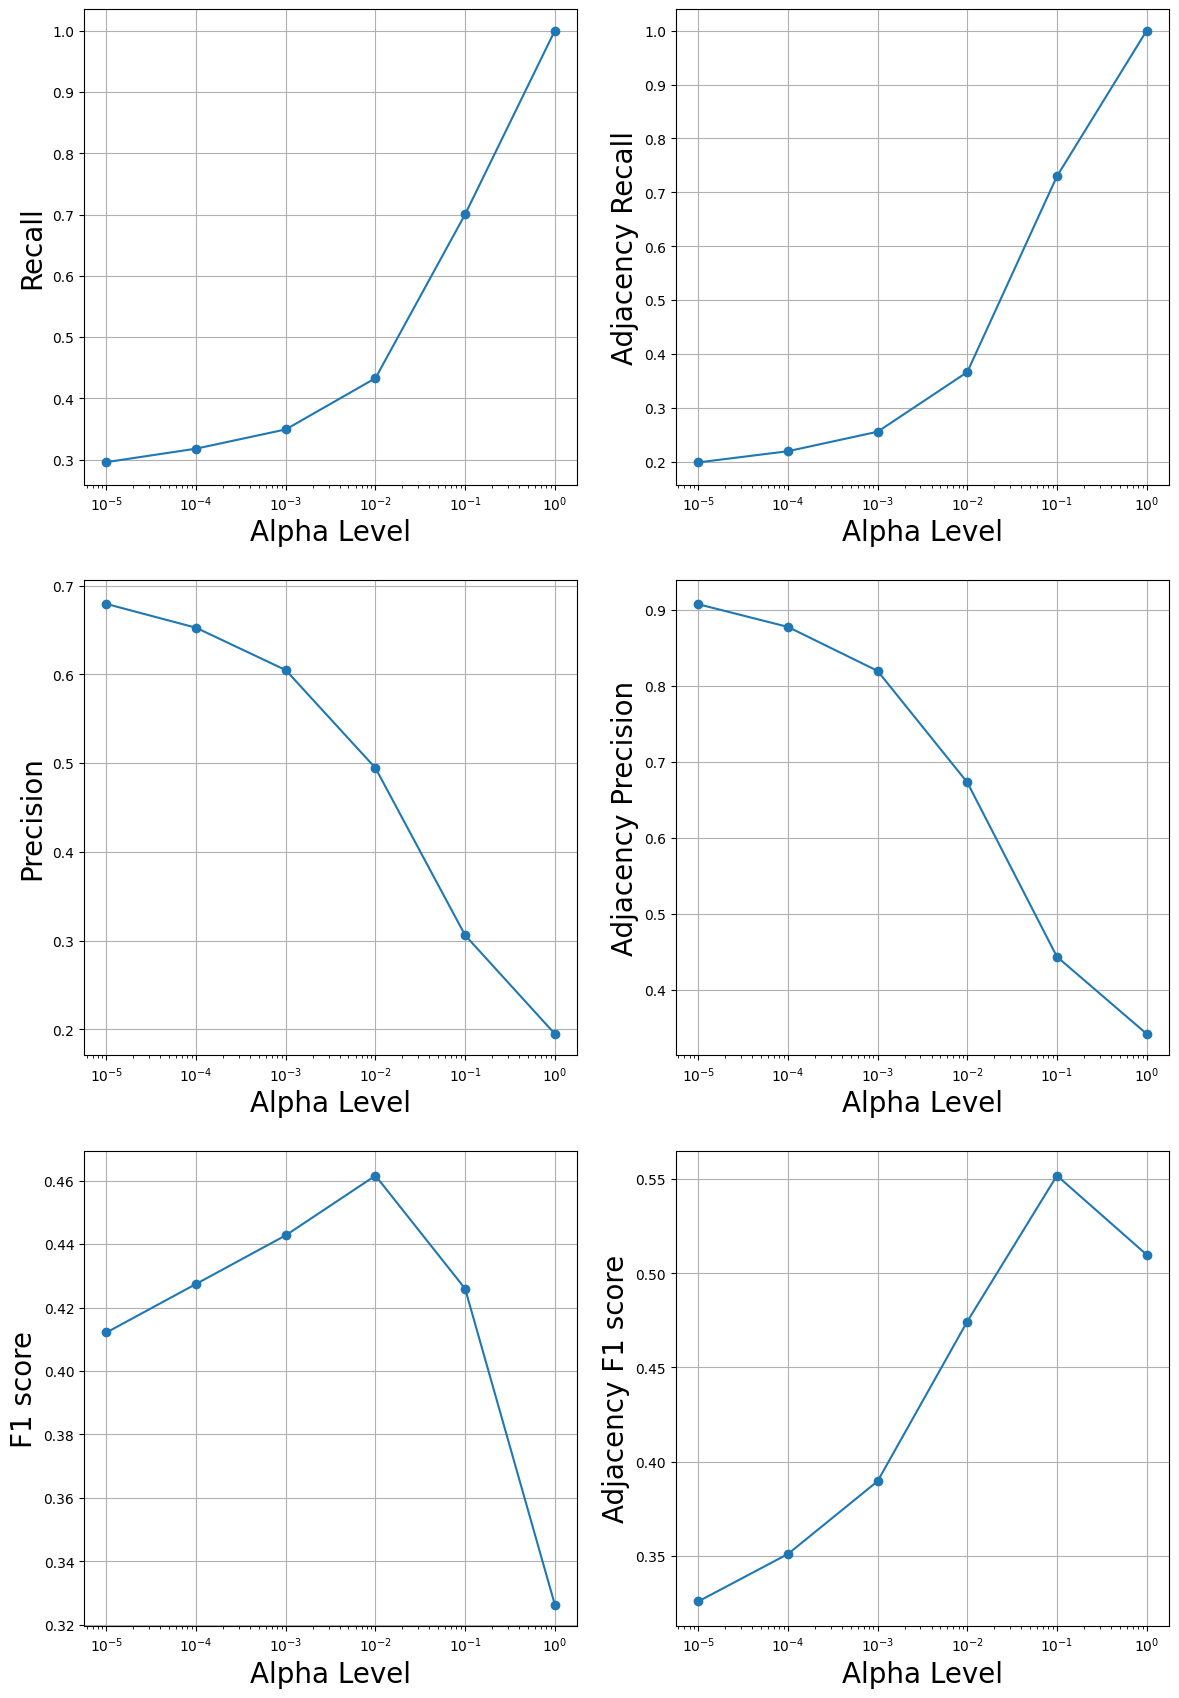

In [42]:
plt.figure(figsize = (14, 21))

for k in range(0, len(pc_alpha)):

    calltif_adj_recall_mean_macaque = np.zeros_like(alpha_level)
    calltif_adj_recall_std_macaque = np.zeros_like(alpha_level)
    calltif_adj_recall_median_macaque = np.zeros_like(alpha_level)

    calltif_adj_precision_mean_macaque = np.zeros_like(alpha_level) 
    calltif_adj_precision_std_macaque = np.zeros_like(alpha_level)
    calltif_adj_precision_median_macaque = np.zeros_like(alpha_level) 

    calltif_adj_F1_score_mean_macaque = np.zeros_like(alpha_level) 
    calltif_adj_F1_score_std_macaque = np.zeros_like(alpha_level)
    calltif_adj_F1_score_median_macaque = np.zeros_like(alpha_level) 

    calltif_ori_recall_mean_macaque = np.zeros_like(alpha_level)
    calltif_ori_recall_std_macaque = np.zeros_like(alpha_level)
    calltif_ori_recall_median_macaque = np.zeros_like(alpha_level)

    calltif_ori_precision_mean_macaque = np.zeros_like(alpha_level)
    calltif_ori_precision_std_macaque = np.zeros_like(alpha_level)
    calltif_ori_precision_median_macaque = np.zeros_like(alpha_level)

    calltif_ori_F1_score_mean_macaque = np.zeros_like(alpha_level)
    calltif_ori_F1_score_std_macaque =np.zeros_like(alpha_level)
    calltif_ori_F1_score_median_macaque = np.zeros_like(alpha_level)

    for a in range(0,len(alpha_level)):

        calltif_adj_recall_mean_macaque[a] = np.mean(np.array(calltif_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])
        calltif_adj_recall_std_macaque[a] = np.std(np.array(calltif_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])
        calltif_adj_recall_median_macaque[a] = np.median(np.array(calltif_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])


        calltif_adj_precision_mean_macaque[a] = np.mean(np.array(calltif_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])
        calltif_adj_precision_std_macaque[a] = np.std(np.array(calltif_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])
        calltif_adj_precision_median_macaque[a] = np.median(np.array(calltif_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])


        calltif_adj_F1_score_mean_macaque[a] = np.mean(np.array(calltif_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        calltif_adj_F1_score_std_macaque[a] = np.std(np.array(calltif_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        calltif_adj_F1_score_median_macaque[a] = np.median(np.array(calltif_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])

        calltif_ori_recall_mean_macaque[a] = np.mean(np.array(calltif_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])
        calltif_ori_recall_std_macaque[a] = np.std(np.array(calltif_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])
        calltif_ori_recall_median_macaque[a] = np.median(np.array(calltif_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])

        calltif_ori_precision_mean_macaque[a] = np.mean(np.array(calltif_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])
        calltif_ori_precision_std_macaque[a] = np.std(np.array(calltif_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])
        calltif_ori_precision_median_macaque[a] = np.median(np.array(calltif_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])

        calltif_ori_F1_score_mean_macaque[a] = np.mean(np.array(calltif_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        calltif_ori_F1_score_std_macaque[a] = np.std(np.array(calltif_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        calltif_ori_F1_score_median_macaque[a] = np.median(np.array(calltif_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])

    calltif_best_alpha_adj_mean= alpha_level[np.argmax(calltif_adj_F1_score_mean_macaque)]
    calltif_best_alpha_adj_median = alpha_level[np.argmax(calltif_adj_F1_score_median_macaque)]
    calltif_best_alpha_ori_mean = alpha_level[np.argmax(calltif_ori_F1_score_mean_macaque)]
    calltif_best_alpha_ori_median = alpha_level[np.argmax(calltif_ori_F1_score_median_macaque)]

    plt.subplot(3,2,2)
    plt.errorbar(alpha_level, calltif_adj_recall_mean_macaque, calltif_adj_recall_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Adjacency Recall', fontsize = 20)
    plt.grid()
    plt.grid(visible = True)


    plt.subplot(3,2,1)
    plt.errorbar(alpha_level, calltif_ori_recall_mean_macaque, calltif_ori_recall_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Recall', fontsize = 20)
    plt.grid(visible = True)


    plt.subplot(3,2,4)
    plt.errorbar(alpha_level, calltif_adj_precision_mean_macaque, calltif_adj_precision_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Adjacency Precision', fontsize = 20)
    plt.grid(visible = True)


    plt.subplot(3,2,3)
    plt.errorbar(alpha_level, calltif_ori_precision_mean_macaque, calltif_ori_precision_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Precision', fontsize = 20)
    plt.grid(visible = True)


    plt.subplot(3,2,6)
    plt.errorbar(alpha_level, calltif_adj_F1_score_mean_macaque, calltif_adj_F1_score_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('Adjacency F1 score', fontsize = 20)
    plt.grid(visible = True)


    plt.subplot(3,2,5)
    plt.errorbar(alpha_level, calltif_ori_F1_score_mean_macaque, calltif_ori_F1_score_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
    plt.xscale('log')
    plt.xlabel('Alpha Level', fontsize = 20)
    plt.ylabel('F1 score', fontsize = 20)
    plt.grid(visible = True)


## PCMCI with Oracle Parent Set

In [43]:
num_rep_macaque = 20

### PCMCI with zero lag (mixed_pcmci)

In [44]:
mixed_pcmci_oracle_adj_TPR_all_rep_macaque_both_alpha = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]
mixed_pcmci_oracle_adj_FPR_all_rep_macaque_both_alpha  = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]
mixed_pcmci_oracle_adj_Recall_all_rep_macaque_both_alpha  = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]
mixed_pcmci_oracle_adj_Precision_all_rep_macaque_both_alpha  = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]
mixed_pcmci_oracle_adj_F1_score_all_rep_macaque_both_alpha  = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]

mixed_pcmci_oracle_ori_TPR_all_rep_macaque_both_alpha  = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]
mixed_pcmci_oracle_ori_FPR_all_rep_macaque_both_alpha  = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]
mixed_pcmci_oracle_ori_Recall_all_rep_macaque_both_alpha  = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]
mixed_pcmci_oracle_ori_Precision_all_rep_macaque_both_alpha  = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]
mixed_pcmci_oracle_ori_F1_score_all_rep_macaque_both_alpha  = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]

macaque_ground_truth = ground_truth_graph_matrix_macaques_full

for r in range(0,num_rep_macaque):
        for a in range(0, len(alpha_level_pcmci_oracle)):
            
            p_matrix = np.array(pcmci_oracle_pval_matrix_all_macaque[r])

            # Threshold p_matrix to get graph
            final_graph_new = p_matrix <= alpha_level_pcmci_oracle[a]
            
            # Convert to string graph representation
            graph = convert_to_string_graph(final_graph_new)

            summary_graph, estimated_adjacency_binary_matrix, estimated_orientation_binary_matrix = summarize_across_all_lags_v1(graph)
            adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = find_tpr_fpr_all_lags(macaque_ground_truth, estimated_adjacency_binary_matrix, estimated_orientation_binary_matrix)
            
            mixed_pcmci_oracle_adj_TPR_all_rep_macaque_both_alpha[r][a] = adjacency_TPR
            mixed_pcmci_oracle_adj_FPR_all_rep_macaque_both_alpha[r][a]  = adjacency_FPR
            mixed_pcmci_oracle_adj_Recall_all_rep_macaque_both_alpha[r][a]  = adjacency_Recall
            mixed_pcmci_oracle_adj_Precision_all_rep_macaque_both_alpha[r][a] = adjacency_Precision
            mixed_pcmci_oracle_adj_F1_score_all_rep_macaque_both_alpha[r][a] = adjacency_F1_score

            mixed_pcmci_oracle_ori_TPR_all_rep_macaque_both_alpha[r][a] = orientation_TPR
            mixed_pcmci_oracle_ori_FPR_all_rep_macaque_both_alpha[r][a]= orientation_FPR
            mixed_pcmci_oracle_ori_Recall_all_rep_macaque_both_alpha[r][a] = orientation_Recall
            mixed_pcmci_oracle_ori_Precision_all_rep_macaque_both_alpha[r][a]  = orientation_Precision
            mixed_pcmci_oracle_ori_F1_score_all_rep_macaque_both_alpha[r][a] = orientation_F1_score


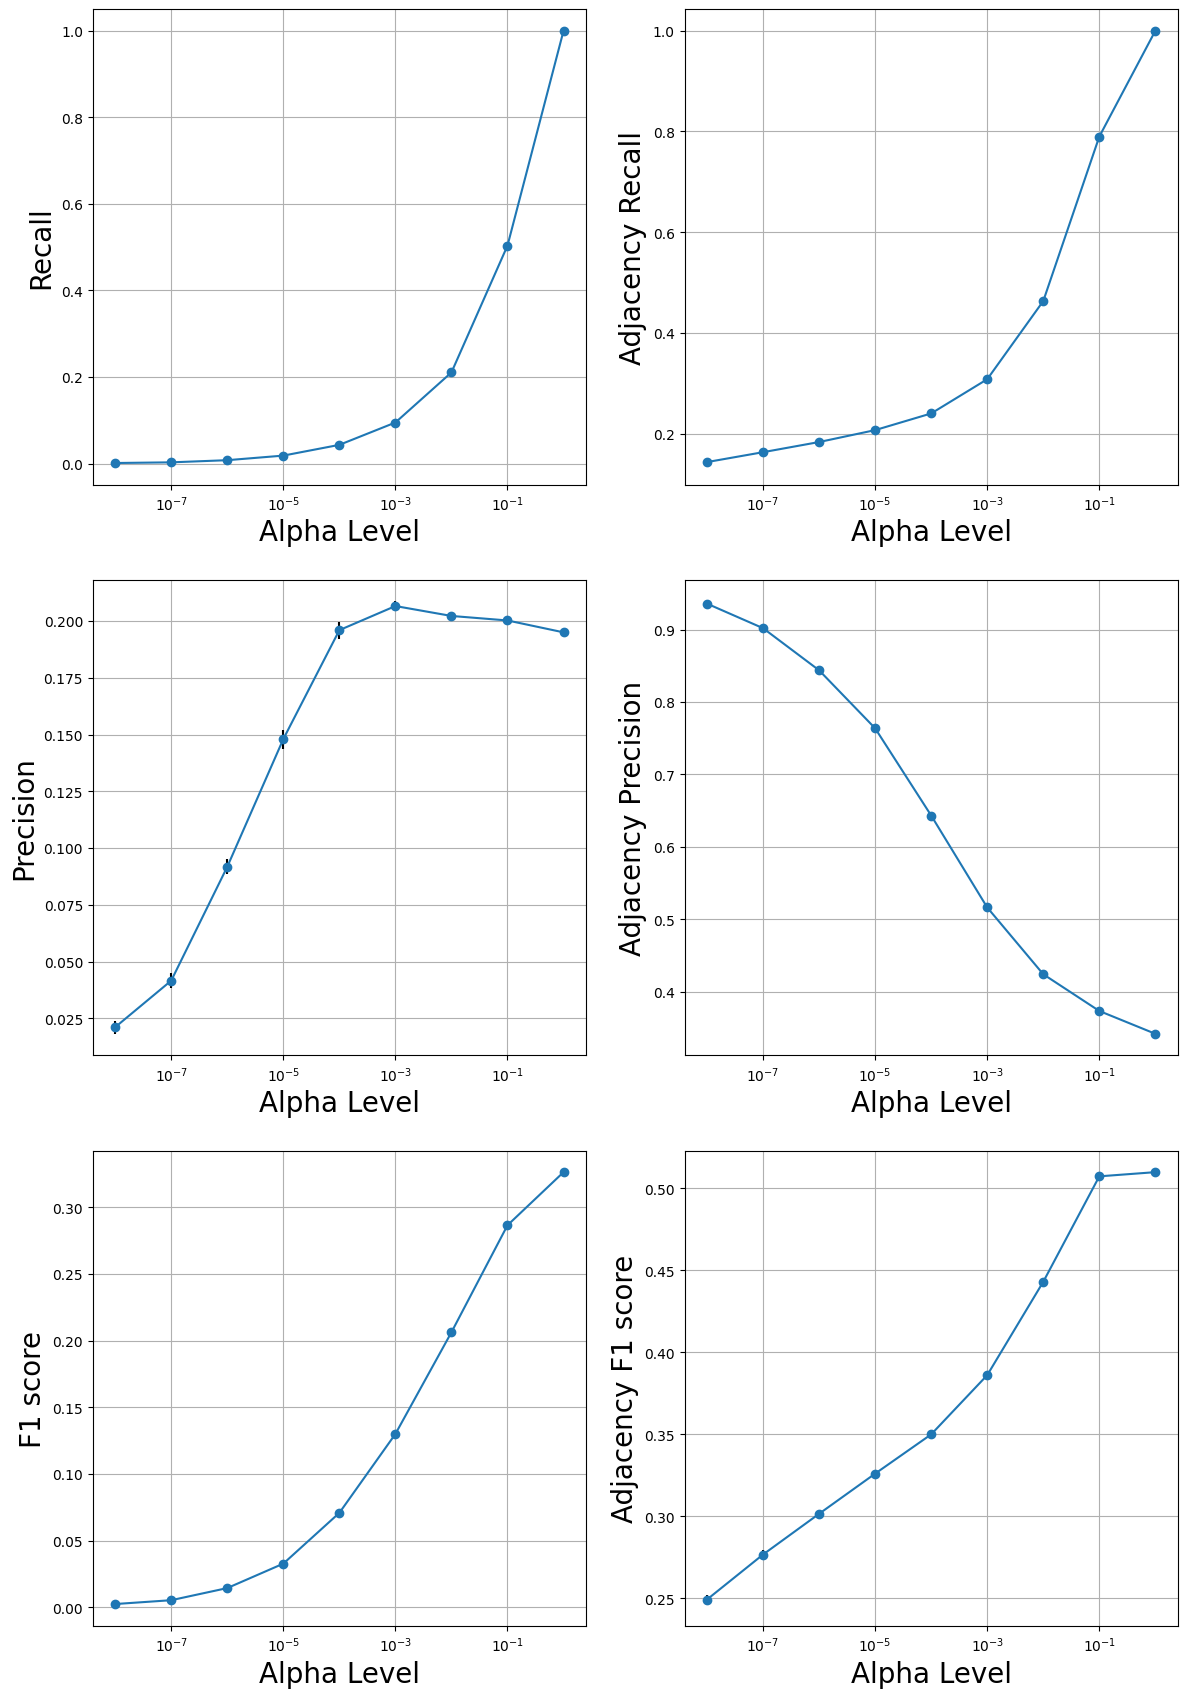

In [45]:
plt.figure(figsize = (14, 21))

mixed_pcmci_oracle_adj_recall_mean_macaque = np.zeros_like(alpha_level_pcmci_oracle)
mixed_pcmci_oracle_adj_recall_std_macaque = np.zeros_like(alpha_level_pcmci_oracle)
mixed_pcmci_oracle_adj_recall_median_macaque = np.zeros_like(alpha_level_pcmci_oracle)

mixed_pcmci_oracle_adj_precision_mean_macaque = np.zeros_like(alpha_level_pcmci_oracle) 
mixed_pcmci_oracle_adj_precision_std_macaque = np.zeros_like(alpha_level_pcmci_oracle)
mixed_pcmci_oracle_adj_precision_median_macaque = np.zeros_like(alpha_level_pcmci_oracle) 

mixed_pcmci_oracle_adj_F1_score_mean_macaque = np.zeros_like(alpha_level_pcmci_oracle) 
mixed_pcmci_oracle_adj_F1_score_std_macaque = np.zeros_like(alpha_level_pcmci_oracle)
mixed_pcmci_oracle_adj_F1_score_median_macaque = np.zeros_like(alpha_level_pcmci_oracle) 

mixed_pcmci_oracle_ori_recall_mean_macaque = np.zeros_like(alpha_level_pcmci_oracle)
mixed_pcmci_oracle_ori_recall_std_macaque = np.zeros_like(alpha_level_pcmci_oracle)
mixed_pcmci_oracle_ori_recall_median_macaque = np.zeros_like(alpha_level_pcmci_oracle)

mixed_pcmci_oracle_ori_precision_mean_macaque = np.zeros_like(alpha_level_pcmci_oracle)
mixed_pcmci_oracle_ori_precision_std_macaque = np.zeros_like(alpha_level_pcmci_oracle)
mixed_pcmci_oracle_ori_precision_median_macaque = np.zeros_like(alpha_level_pcmci_oracle)

mixed_pcmci_oracle_ori_F1_score_mean_macaque = np.zeros_like(alpha_level_pcmci_oracle)
mixed_pcmci_oracle_ori_F1_score_std_macaque =np.zeros_like(alpha_level_pcmci_oracle)
mixed_pcmci_oracle_ori_F1_score_median_macaque = np.zeros_like(alpha_level_pcmci_oracle)

for a in range(0,len(alpha_level_pcmci_oracle)):

    mixed_pcmci_oracle_adj_recall_mean_macaque[a] = np.mean(np.array(mixed_pcmci_oracle_adj_Recall_all_rep_macaque_both_alpha)[:,a])
    mixed_pcmci_oracle_adj_recall_std_macaque[a] = np.std(np.array(mixed_pcmci_oracle_adj_Recall_all_rep_macaque_both_alpha)[:,a])
    mixed_pcmci_oracle_adj_recall_median_macaque[a] = np.median(np.array(mixed_pcmci_oracle_adj_Recall_all_rep_macaque_both_alpha)[:,a])


    mixed_pcmci_oracle_adj_precision_mean_macaque[a] = np.mean(np.array(mixed_pcmci_oracle_adj_Precision_all_rep_macaque_both_alpha)[:,a])
    mixed_pcmci_oracle_adj_precision_std_macaque[a] = np.std(np.array(mixed_pcmci_oracle_adj_Precision_all_rep_macaque_both_alpha)[:,a])
    mixed_pcmci_oracle_adj_precision_median_macaque[a] = np.median(np.array(mixed_pcmci_oracle_adj_Precision_all_rep_macaque_both_alpha)[:,a])


    mixed_pcmci_oracle_adj_F1_score_mean_macaque[a] = np.mean(np.array(mixed_pcmci_oracle_adj_F1_score_all_rep_macaque_both_alpha)[:,a])
    mixed_pcmci_oracle_adj_F1_score_std_macaque[a] = np.std(np.array(mixed_pcmci_oracle_adj_F1_score_all_rep_macaque_both_alpha)[:,a])
    mixed_pcmci_oracle_adj_F1_score_median_macaque[a] = np.median(np.array(mixed_pcmci_oracle_adj_F1_score_all_rep_macaque_both_alpha)[:,a])


    mixed_pcmci_oracle_ori_recall_mean_macaque[a] = np.mean(np.array(mixed_pcmci_oracle_ori_Recall_all_rep_macaque_both_alpha)[:,a])
    mixed_pcmci_oracle_ori_recall_std_macaque[a] = np.std(np.array(mixed_pcmci_oracle_ori_Recall_all_rep_macaque_both_alpha)[:,a])
    mixed_pcmci_oracle_ori_recall_median_macaque[a] = np.median(np.array(mixed_pcmci_oracle_ori_Recall_all_rep_macaque_both_alpha)[:,a])


    mixed_pcmci_oracle_ori_precision_mean_macaque[a] = np.mean(np.array(mixed_pcmci_oracle_ori_Precision_all_rep_macaque_both_alpha)[:,a])
    mixed_pcmci_oracle_ori_precision_std_macaque[a] = np.std(np.array(mixed_pcmci_oracle_ori_Precision_all_rep_macaque_both_alpha)[:,a])
    mixed_pcmci_oracle_ori_precision_median_macaque[a] = np.median(np.array(mixed_pcmci_oracle_ori_Precision_all_rep_macaque_both_alpha)[:,a])


    mixed_pcmci_oracle_ori_F1_score_mean_macaque[a] = np.mean(np.array(mixed_pcmci_oracle_ori_F1_score_all_rep_macaque_both_alpha)[:,a])
    mixed_pcmci_oracle_ori_F1_score_std_macaque[a] = np.std(np.array(mixed_pcmci_oracle_ori_F1_score_all_rep_macaque_both_alpha)[:,a])
    mixed_pcmci_oracle_ori_F1_score_median_macaque[a] = np.median(np.array(mixed_pcmci_oracle_ori_F1_score_all_rep_macaque_both_alpha)[:,a])

    mixed_pcmci_oracle_best_alpha_adj_mean= alpha_level_pcmci_oracle[np.argmax(mixed_pcmci_oracle_adj_F1_score_mean_macaque)]
    mixed_pcmci_oracle_best_alpha_adj_median = alpha_level_pcmci_oracle[np.argmax(mixed_pcmci_oracle_adj_F1_score_median_macaque)]
    mixed_pcmci_oracle_best_alpha_ori_mean = alpha_level_pcmci_oracle[np.argmax(mixed_pcmci_oracle_ori_F1_score_mean_macaque)]
    mixed_pcmci_oracle_best_alpha_ori_median = alpha_level_pcmci_oracle[np.argmax(mixed_pcmci_oracle_ori_F1_score_median_macaque)]

plt.subplot(3,2,2)
plt.errorbar(alpha_level_pcmci_oracle, mixed_pcmci_oracle_adj_recall_mean_macaque, mixed_pcmci_oracle_adj_recall_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha Level', fontsize = 20)
plt.ylabel('Adjacency Recall', fontsize = 20)
plt.grid()
plt.grid(visible = True)


plt.subplot(3,2,1)
plt.errorbar(alpha_level_pcmci_oracle, mixed_pcmci_oracle_ori_recall_mean_macaque, mixed_pcmci_oracle_ori_recall_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha Level', fontsize = 20)
plt.ylabel('Recall', fontsize = 20)
plt.grid(visible = True)


plt.subplot(3,2,4)
plt.errorbar(alpha_level_pcmci_oracle, mixed_pcmci_oracle_adj_precision_mean_macaque, mixed_pcmci_oracle_adj_precision_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha Level', fontsize = 20)
plt.ylabel('Adjacency Precision', fontsize = 20)
plt.grid(visible = True)


plt.subplot(3,2,3)
plt.errorbar(alpha_level_pcmci_oracle, mixed_pcmci_oracle_ori_precision_mean_macaque, mixed_pcmci_oracle_ori_precision_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha Level', fontsize = 20)
plt.ylabel('Precision', fontsize = 20)
plt.grid(visible = True)


plt.subplot(3,2,6)
plt.errorbar(alpha_level_pcmci_oracle, mixed_pcmci_oracle_adj_F1_score_mean_macaque, mixed_pcmci_oracle_adj_F1_score_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha Level', fontsize = 20)
plt.ylabel('Adjacency F1 score', fontsize = 20)
plt.grid(visible = True)


plt.subplot(3,2,5)
plt.errorbar(alpha_level_pcmci_oracle, mixed_pcmci_oracle_ori_F1_score_mean_macaque, mixed_pcmci_oracle_ori_F1_score_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha Level', fontsize = 20)
plt.ylabel('F1 score', fontsize = 20)
plt.grid(visible = True)


### PCMCI without zero lag (pcmci)

In [46]:
pcmci_oracle_adj_TPR_all_rep_macaque_both_alpha = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]
pcmci_oracle_adj_FPR_all_rep_macaque_both_alpha  = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]
pcmci_oracle_adj_Recall_all_rep_macaque_both_alpha  = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]
pcmci_oracle_adj_Precision_all_rep_macaque_both_alpha  = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]
pcmci_oracle_adj_F1_score_all_rep_macaque_both_alpha  = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]

pcmci_oracle_ori_TPR_all_rep_macaque_both_alpha  = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]
pcmci_oracle_ori_FPR_all_rep_macaque_both_alpha  = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]
pcmci_oracle_ori_Recall_all_rep_macaque_both_alpha  = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]
pcmci_oracle_ori_Precision_all_rep_macaque_both_alpha  = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]
pcmci_oracle_ori_F1_score_all_rep_macaque_both_alpha  = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]

macaque_ground_truth = ground_truth_graph_matrix_macaques_full

for r in range(0,num_rep_macaque):
        for a in range(0, len(alpha_level_pcmci_oracle)):
            
            p_matrix = np.array(pcmci_oracle_pval_matrix_all_macaque[r])
    
            # Threshold p_matrix to get graph
            final_graph_new = p_matrix <= alpha_level_pcmci_oracle[a]
            
            # Convert to string graph representation
            graph = convert_to_string_graph(final_graph_new)

            binary_matrix = summarize_across_nonzero_lags(graph)
            adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = find_tpr_fpr_nonzero_lags(macaque_ground_truth, binary_matrix)

            
            pcmci_oracle_adj_TPR_all_rep_macaque_both_alpha[r][a] = adjacency_TPR
            pcmci_oracle_adj_FPR_all_rep_macaque_both_alpha[r][a]  = adjacency_FPR
            pcmci_oracle_adj_Recall_all_rep_macaque_both_alpha[r][a]  = adjacency_Recall
            pcmci_oracle_adj_Precision_all_rep_macaque_both_alpha[r][a] = adjacency_Precision
            pcmci_oracle_adj_F1_score_all_rep_macaque_both_alpha[r][a] = adjacency_F1_score

            pcmci_oracle_ori_TPR_all_rep_macaque_both_alpha[r][a] = orientation_TPR
            pcmci_oracle_ori_FPR_all_rep_macaque_both_alpha[r][a]= orientation_FPR
            pcmci_oracle_ori_Recall_all_rep_macaque_both_alpha[r][a] = orientation_Recall
            pcmci_oracle_ori_Precision_all_rep_macaque_both_alpha[r][a]  = orientation_Precision
            pcmci_oracle_ori_F1_score_all_rep_macaque_both_alpha[r][a] = orientation_F1_score


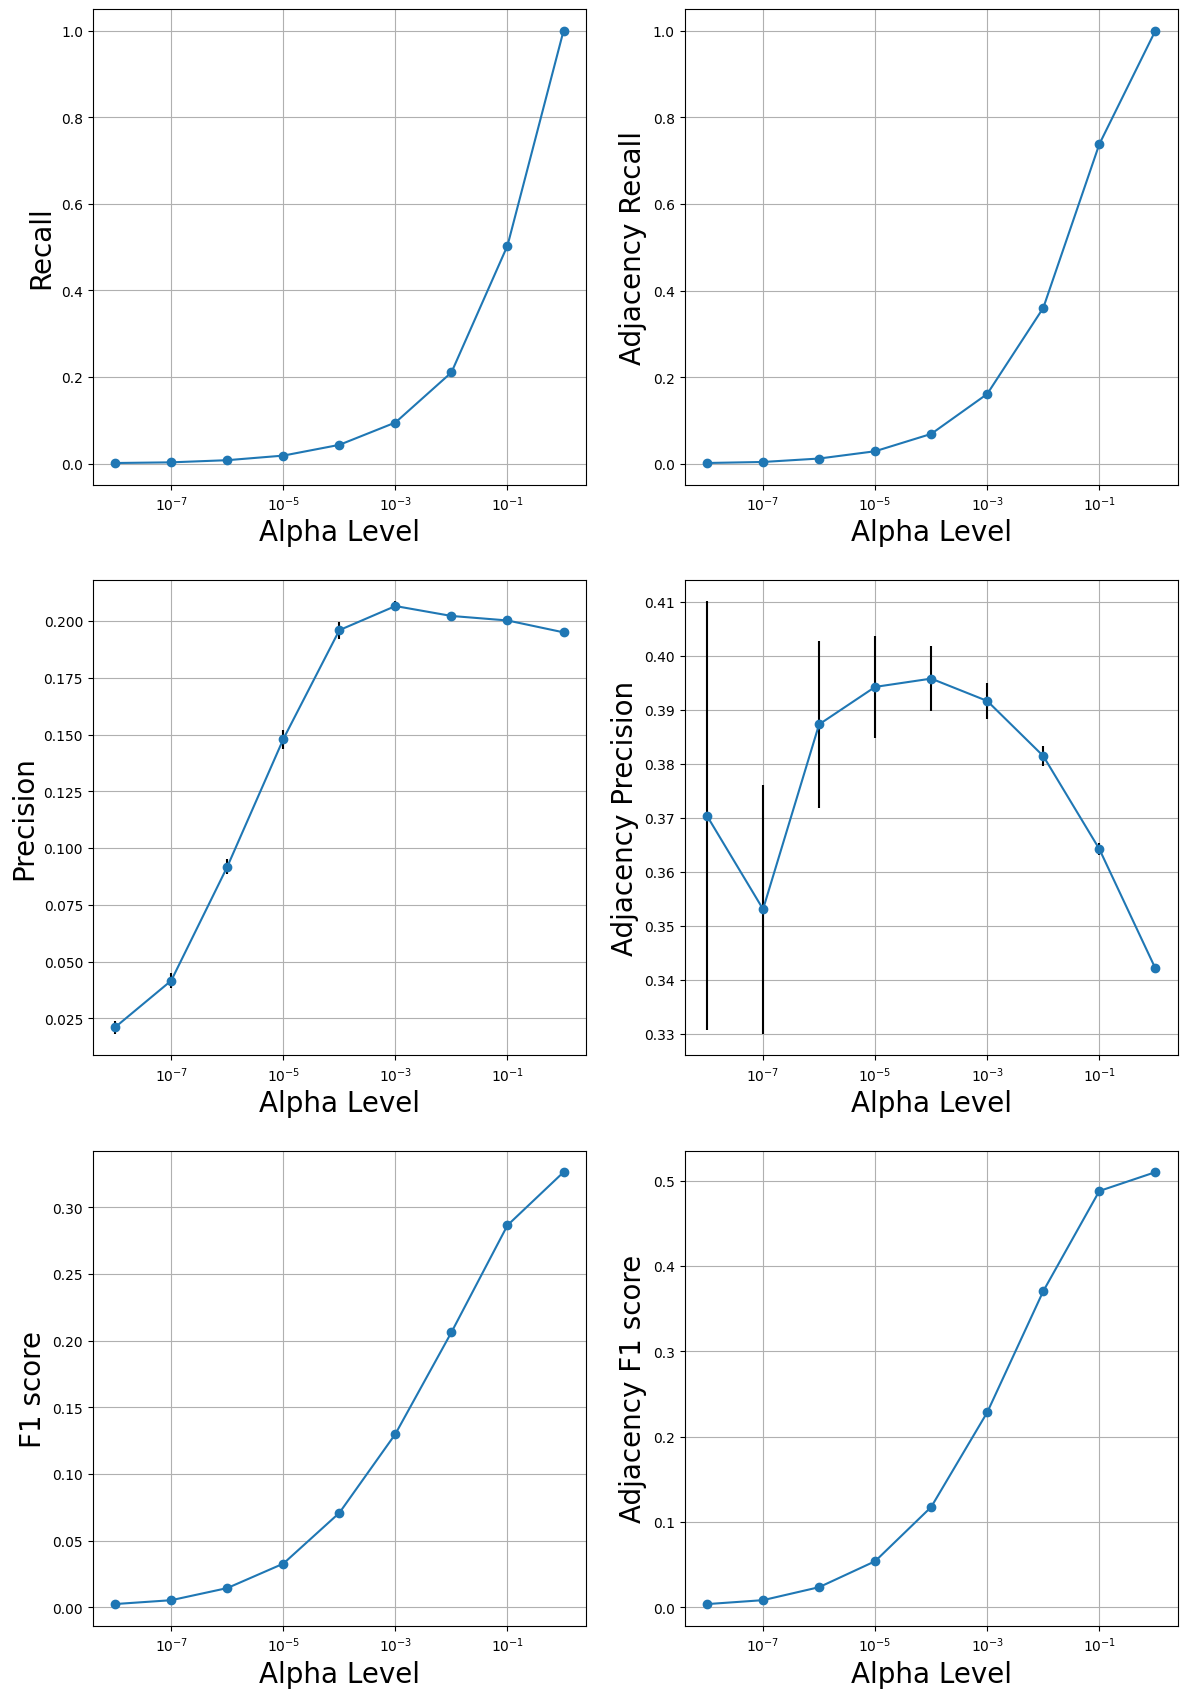

In [47]:
# Recall and Precision, and F1_score vs alpha for adjacency
# error bar

plt.figure(figsize = (14, 21))

pcmci_oracle_adj_recall_mean_macaque = np.zeros_like(alpha_level_pcmci_oracle)
pcmci_oracle_adj_recall_std_macaque = np.zeros_like(alpha_level_pcmci_oracle)
pcmci_oracle_adj_recall_median_macaque = np.zeros_like(alpha_level_pcmci_oracle)

pcmci_oracle_adj_precision_mean_macaque = np.zeros_like(alpha_level_pcmci_oracle) 
pcmci_oracle_adj_precision_std_macaque = np.zeros_like(alpha_level_pcmci_oracle)
pcmci_oracle_adj_precision_median_macaque = np.zeros_like(alpha_level_pcmci_oracle) 

pcmci_oracle_adj_F1_score_mean_macaque = np.zeros_like(alpha_level_pcmci_oracle) 
pcmci_oracle_adj_F1_score_std_macaque = np.zeros_like(alpha_level_pcmci_oracle)
pcmci_oracle_adj_F1_score_median_macaque = np.zeros_like(alpha_level_pcmci_oracle) 

pcmci_oracle_ori_recall_mean_macaque = np.zeros_like(alpha_level_pcmci_oracle)
pcmci_oracle_ori_recall_std_macaque = np.zeros_like(alpha_level_pcmci_oracle)
pcmci_oracle_ori_recall_median_macaque = np.zeros_like(alpha_level_pcmci_oracle)

pcmci_oracle_ori_precision_mean_macaque = np.zeros_like(alpha_level_pcmci_oracle)
pcmci_oracle_ori_precision_std_macaque = np.zeros_like(alpha_level_pcmci_oracle)
pcmci_oracle_ori_precision_median_macaque = np.zeros_like(alpha_level_pcmci_oracle)

pcmci_oracle_ori_F1_score_mean_macaque = np.zeros_like(alpha_level_pcmci_oracle)
pcmci_oracle_ori_F1_score_std_macaque =np.zeros_like(alpha_level_pcmci_oracle)
pcmci_oracle_ori_F1_score_median_macaque = np.zeros_like(alpha_level_pcmci_oracle)

for a in range(0,len(alpha_level_pcmci_oracle)):

    pcmci_oracle_adj_recall_mean_macaque[a] = np.mean(np.array(pcmci_oracle_adj_Recall_all_rep_macaque_both_alpha)[:,a])
    pcmci_oracle_adj_recall_std_macaque[a] = np.std(np.array(pcmci_oracle_adj_Recall_all_rep_macaque_both_alpha)[:,a])
    pcmci_oracle_adj_recall_median_macaque[a] = np.median(np.array(pcmci_oracle_adj_Recall_all_rep_macaque_both_alpha)[:,a])


    pcmci_oracle_adj_precision_mean_macaque[a] = np.mean(np.array(pcmci_oracle_adj_Precision_all_rep_macaque_both_alpha)[:,a])
    pcmci_oracle_adj_precision_std_macaque[a] = np.std(np.array(pcmci_oracle_adj_Precision_all_rep_macaque_both_alpha)[:,a])
    pcmci_oracle_adj_precision_median_macaque[a] = np.median(np.array(pcmci_oracle_adj_Precision_all_rep_macaque_both_alpha)[:,a])


    pcmci_oracle_adj_F1_score_mean_macaque[a] = np.mean(np.array(pcmci_oracle_adj_F1_score_all_rep_macaque_both_alpha)[:,a])
    pcmci_oracle_adj_F1_score_std_macaque[a] = np.std(np.array(pcmci_oracle_adj_F1_score_all_rep_macaque_both_alpha)[:,a])
    pcmci_oracle_adj_F1_score_median_macaque[a] = np.median(np.array(pcmci_oracle_adj_F1_score_all_rep_macaque_both_alpha)[:,a])


    pcmci_oracle_ori_recall_mean_macaque[a] = np.mean(np.array(pcmci_oracle_ori_Recall_all_rep_macaque_both_alpha)[:,a])
    pcmci_oracle_ori_recall_std_macaque[a] = np.std(np.array(pcmci_oracle_ori_Recall_all_rep_macaque_both_alpha)[:,a])
    pcmci_oracle_ori_recall_median_macaque[a] = np.median(np.array(pcmci_oracle_ori_Recall_all_rep_macaque_both_alpha)[:,a])


    pcmci_oracle_ori_precision_mean_macaque[a] = np.mean(np.array(pcmci_oracle_ori_Precision_all_rep_macaque_both_alpha)[:,a])
    pcmci_oracle_ori_precision_std_macaque[a] = np.std(np.array(pcmci_oracle_ori_Precision_all_rep_macaque_both_alpha)[:,a])
    pcmci_oracle_ori_precision_median_macaque[a] = np.median(np.array(pcmci_oracle_ori_Precision_all_rep_macaque_both_alpha)[:,a])


    pcmci_oracle_ori_F1_score_mean_macaque[a] = np.mean(np.array(pcmci_oracle_ori_F1_score_all_rep_macaque_both_alpha)[:,a])
    pcmci_oracle_ori_F1_score_std_macaque[a] = np.std(np.array(pcmci_oracle_ori_F1_score_all_rep_macaque_both_alpha)[:,a])
    pcmci_oracle_ori_F1_score_median_macaque[a] = np.median(np.array(pcmci_oracle_ori_F1_score_all_rep_macaque_both_alpha)[:,a])

    pcmci_oracle_best_alpha_adj_mean= alpha_level_pcmci_oracle[np.argmax(pcmci_oracle_adj_F1_score_mean_macaque)]
    pcmci_oracle_best_alpha_adj_median = alpha_level_pcmci_oracle[np.argmax(pcmci_oracle_adj_F1_score_median_macaque)]
    pcmci_oracle_best_alpha_ori_mean = alpha_level_pcmci_oracle[np.argmax(pcmci_oracle_ori_F1_score_mean_macaque)]
    pcmci_oracle_best_alpha_ori_median = alpha_level_pcmci_oracle[np.argmax(pcmci_oracle_ori_F1_score_median_macaque)]

plt.subplot(3,2,2)
plt.errorbar(alpha_level_pcmci_oracle, pcmci_oracle_adj_recall_mean_macaque, pcmci_oracle_adj_recall_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha Level', fontsize = 20)
plt.ylabel('Adjacency Recall', fontsize = 20)
plt.grid()
plt.grid(visible = True)


plt.subplot(3,2,1)
plt.errorbar(alpha_level_pcmci_oracle, pcmci_oracle_ori_recall_mean_macaque, pcmci_oracle_ori_recall_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha Level', fontsize = 20)
plt.ylabel('Recall', fontsize = 20)
plt.grid(visible = True)


plt.subplot(3,2,4)
plt.errorbar(alpha_level_pcmci_oracle, pcmci_oracle_adj_precision_mean_macaque, pcmci_oracle_adj_precision_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha Level', fontsize = 20)
plt.ylabel('Adjacency Precision', fontsize = 20)
plt.grid(visible = True)


plt.subplot(3,2,3)
plt.errorbar(alpha_level_pcmci_oracle, pcmci_oracle_ori_precision_mean_macaque, pcmci_oracle_ori_precision_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha Level', fontsize = 20)
plt.ylabel('Precision', fontsize = 20)
plt.grid(visible = True)


plt.subplot(3,2,6)
plt.errorbar(alpha_level_pcmci_oracle, pcmci_oracle_adj_F1_score_mean_macaque, pcmci_oracle_adj_F1_score_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha Level', fontsize = 20)
plt.ylabel('Adjacency F1 score', fontsize = 20)
plt.grid(visible = True)


plt.subplot(3,2,5)
plt.errorbar(alpha_level_pcmci_oracle, pcmci_oracle_ori_F1_score_mean_macaque, pcmci_oracle_ori_F1_score_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha Level', fontsize = 20)
plt.ylabel('F1 score', fontsize = 20)
plt.grid(visible = True)

### PCMCI with zero lag (calltif): zero lag affected both adjacency and orientations

In [48]:
calltif_oracle_adj_TPR_all_rep_macaque_both_alpha = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]
calltif_oracle_adj_FPR_all_rep_macaque_both_alpha  = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]
calltif_oracle_adj_Recall_all_rep_macaque_both_alpha  = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]
calltif_oracle_adj_Precision_all_rep_macaque_both_alpha  = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]
calltif_oracle_adj_F1_score_all_rep_macaque_both_alpha  = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]

calltif_oracle_ori_TPR_all_rep_macaque_both_alpha  = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]
calltif_oracle_ori_FPR_all_rep_macaque_both_alpha  = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]
calltif_oracle_ori_Recall_all_rep_macaque_both_alpha  = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]
calltif_oracle_ori_Precision_all_rep_macaque_both_alpha  = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]
calltif_oracle_ori_F1_score_all_rep_macaque_both_alpha  = [['' for t in range(0, len(alpha_level_pcmci_oracle))] for i in range(0,num_rep_macaque )]

macaque_ground_truth = ground_truth_graph_matrix_macaques_full

for r in range(0,num_rep_macaque):
        for a in range(0, len(alpha_level_pcmci_oracle)):
            
            p_matrix = np.array(pcmci_oracle_pval_matrix_all_macaque[r])
    
            # Threshold p_matrix to get graph
            final_graph_new = p_matrix <= alpha_level_pcmci_oracle[a]                 
            
            # Convert to string graph representation
            graph = convert_to_string_graph(final_graph_new)

            summary_graph, estimated_adjacency_binary_matrix, estimated_orientation_binary_matrix = summarize_across_all_lags_v2(graph)
            
            adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = find_tpr_fpr_all_lags(macaque_ground_truth, estimated_adjacency_binary_matrix, estimated_orientation_binary_matrix)

            calltif_oracle_adj_TPR_all_rep_macaque_both_alpha[r][a] = adjacency_TPR
            calltif_oracle_adj_FPR_all_rep_macaque_both_alpha[r][a]  = adjacency_FPR
            calltif_oracle_adj_Recall_all_rep_macaque_both_alpha[r][a]  = adjacency_Recall
            calltif_oracle_adj_Precision_all_rep_macaque_both_alpha[r][a] = adjacency_Precision
            calltif_oracle_adj_F1_score_all_rep_macaque_both_alpha[r][a] = adjacency_F1_score

            calltif_oracle_ori_TPR_all_rep_macaque_both_alpha[r][a] = orientation_TPR
            calltif_oracle_ori_FPR_all_rep_macaque_both_alpha[r][a]= orientation_FPR
            calltif_oracle_ori_Recall_all_rep_macaque_both_alpha[r][a] = orientation_Recall
            calltif_oracle_ori_Precision_all_rep_macaque_both_alpha[r][a]  = orientation_Precision
            calltif_oracle_ori_F1_score_all_rep_macaque_both_alpha[r][a] = orientation_F1_score


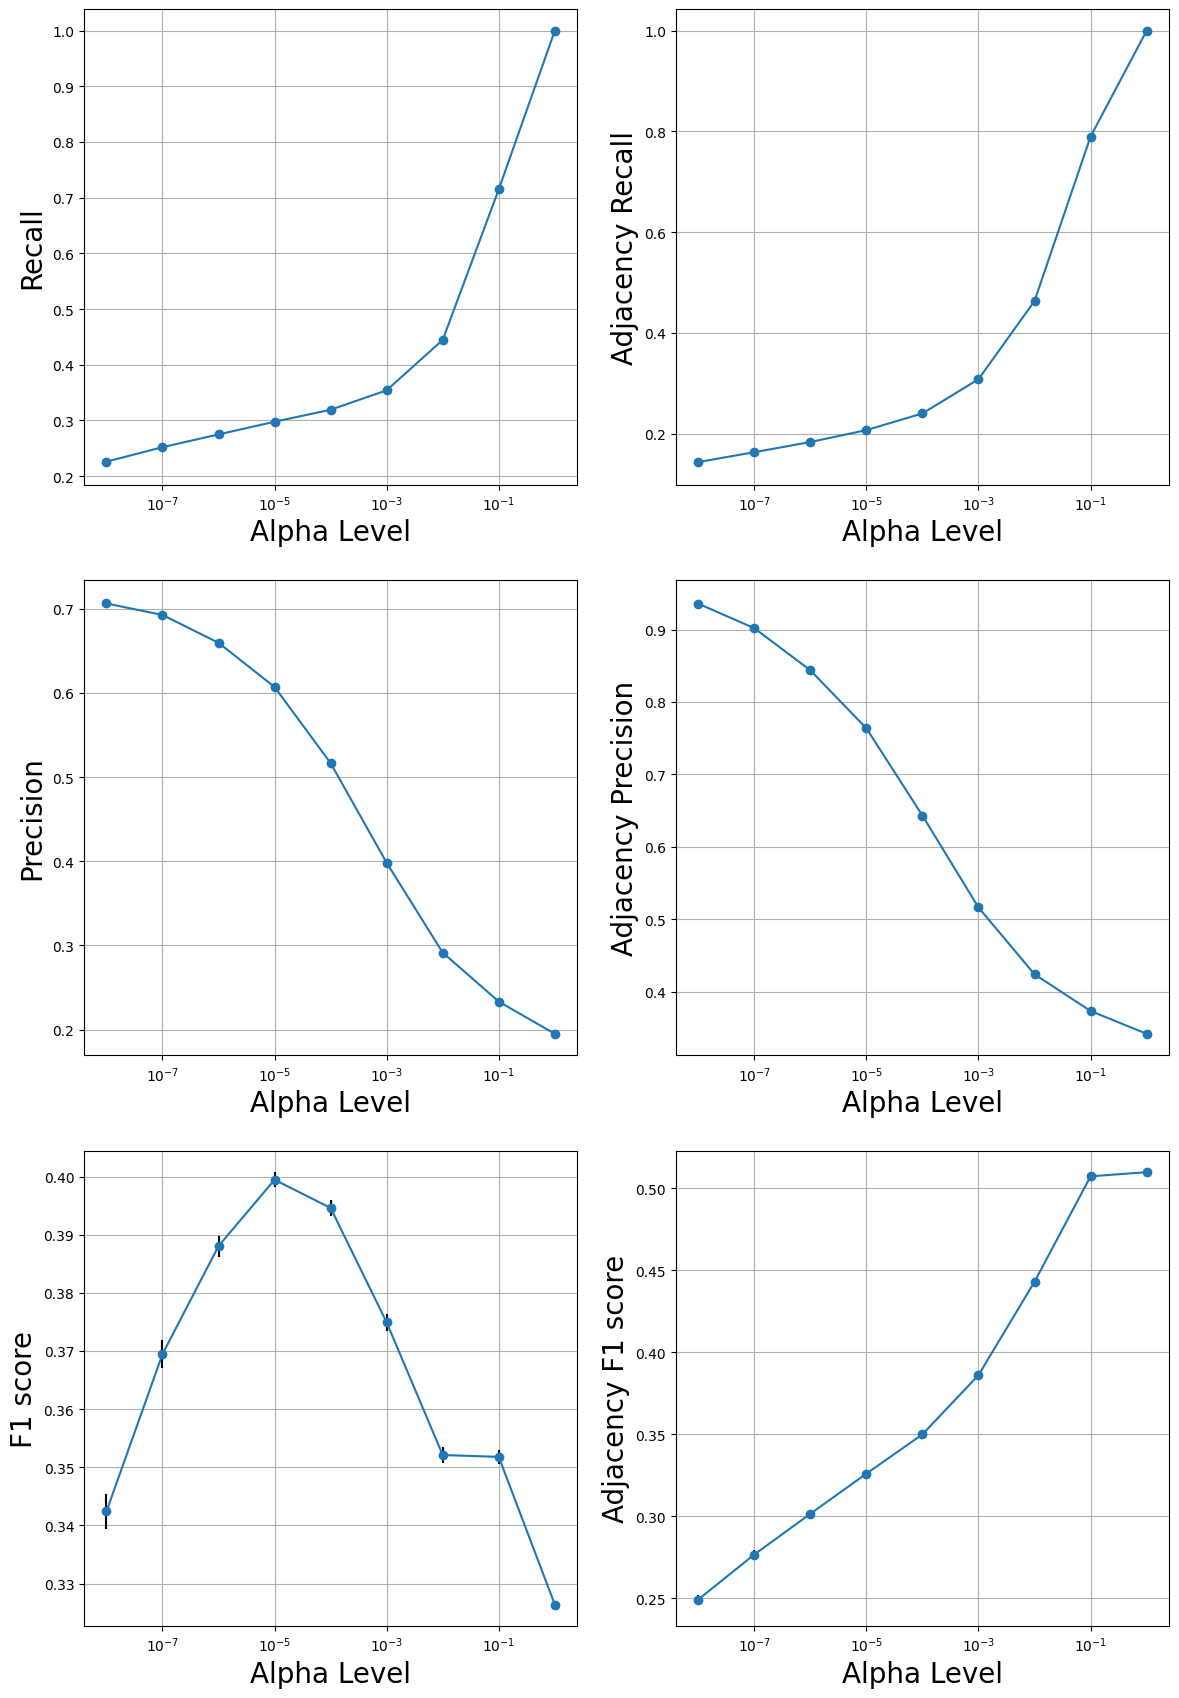

In [49]:
plt.figure(figsize = (14, 21))

calltif_oracle_adj_recall_mean_macaque = np.zeros_like(alpha_level_pcmci_oracle)
calltif_oracle_adj_recall_std_macaque = np.zeros_like(alpha_level_pcmci_oracle)
calltif_oracle_adj_recall_median_macaque = np.zeros_like(alpha_level_pcmci_oracle)

calltif_oracle_adj_precision_mean_macaque = np.zeros_like(alpha_level_pcmci_oracle) 
calltif_oracle_adj_precision_std_macaque = np.zeros_like(alpha_level_pcmci_oracle)
calltif_oracle_adj_precision_median_macaque = np.zeros_like(alpha_level_pcmci_oracle) 

calltif_oracle_adj_F1_score_mean_macaque = np.zeros_like(alpha_level_pcmci_oracle) 
calltif_oracle_adj_F1_score_std_macaque = np.zeros_like(alpha_level_pcmci_oracle)
calltif_oracle_adj_F1_score_median_macaque = np.zeros_like(alpha_level_pcmci_oracle) 

calltif_oracle_ori_recall_mean_macaque = np.zeros_like(alpha_level_pcmci_oracle)
calltif_oracle_ori_recall_std_macaque = np.zeros_like(alpha_level_pcmci_oracle)
calltif_oracle_ori_recall_median_macaque = np.zeros_like(alpha_level_pcmci_oracle)

calltif_oracle_ori_precision_mean_macaque = np.zeros_like(alpha_level_pcmci_oracle)
calltif_oracle_ori_precision_std_macaque = np.zeros_like(alpha_level_pcmci_oracle)
calltif_oracle_ori_precision_median_macaque = np.zeros_like(alpha_level_pcmci_oracle)

calltif_oracle_ori_F1_score_mean_macaque = np.zeros_like(alpha_level_pcmci_oracle)
calltif_oracle_ori_F1_score_std_macaque =np.zeros_like(alpha_level_pcmci_oracle)
calltif_oracle_ori_F1_score_median_macaque = np.zeros_like(alpha_level_pcmci_oracle)

for a in range(0,len(alpha_level_pcmci_oracle)):

    calltif_oracle_adj_recall_mean_macaque[a] = np.mean(np.array(calltif_oracle_adj_Recall_all_rep_macaque_both_alpha)[:,a])
    calltif_oracle_adj_recall_std_macaque[a] = np.std(np.array(calltif_oracle_adj_Recall_all_rep_macaque_both_alpha)[:,a])
    calltif_oracle_adj_recall_median_macaque[a] = np.median(np.array(calltif_oracle_adj_Recall_all_rep_macaque_both_alpha)[:,a])


    calltif_oracle_adj_precision_mean_macaque[a] = np.mean(np.array(calltif_oracle_adj_Precision_all_rep_macaque_both_alpha)[:,a])
    calltif_oracle_adj_precision_std_macaque[a] = np.std(np.array(calltif_oracle_adj_Precision_all_rep_macaque_both_alpha)[:,a])
    calltif_oracle_adj_precision_median_macaque[a] = np.median(np.array(calltif_oracle_adj_Precision_all_rep_macaque_both_alpha)[:,a])


    calltif_oracle_adj_F1_score_mean_macaque[a] = np.mean(np.array(calltif_oracle_adj_F1_score_all_rep_macaque_both_alpha)[:,a])
    calltif_oracle_adj_F1_score_std_macaque[a] = np.std(np.array(calltif_oracle_adj_F1_score_all_rep_macaque_both_alpha)[:,a])
    calltif_oracle_adj_F1_score_median_macaque[a] = np.median(np.array(calltif_oracle_adj_F1_score_all_rep_macaque_both_alpha)[:,a])


    calltif_oracle_ori_recall_mean_macaque[a] = np.mean(np.array(calltif_oracle_ori_Recall_all_rep_macaque_both_alpha)[:,a])
    calltif_oracle_ori_recall_std_macaque[a] = np.std(np.array(calltif_oracle_ori_Recall_all_rep_macaque_both_alpha)[:,a])
    calltif_oracle_ori_recall_median_macaque[a] = np.median(np.array(calltif_oracle_ori_Recall_all_rep_macaque_both_alpha)[:,a])


    calltif_oracle_ori_precision_mean_macaque[a] = np.mean(np.array(calltif_oracle_ori_Precision_all_rep_macaque_both_alpha)[:,a])
    calltif_oracle_ori_precision_std_macaque[a] = np.std(np.array(calltif_oracle_ori_Precision_all_rep_macaque_both_alpha)[:,a])
    calltif_oracle_ori_precision_median_macaque[a] = np.median(np.array(calltif_oracle_ori_Precision_all_rep_macaque_both_alpha)[:,a])


    calltif_oracle_ori_F1_score_mean_macaque[a] = np.mean(np.array(calltif_oracle_ori_F1_score_all_rep_macaque_both_alpha)[:,a])
    calltif_oracle_ori_F1_score_std_macaque[a] = np.std(np.array(calltif_oracle_ori_F1_score_all_rep_macaque_both_alpha)[:,a])
    calltif_oracle_ori_F1_score_median_macaque[a] = np.median(np.array(calltif_oracle_ori_F1_score_all_rep_macaque_both_alpha)[:,a])

    calltif_oracle_best_alpha_adj_mean= alpha_level_pcmci_oracle[np.argmax(calltif_oracle_adj_F1_score_mean_macaque)]
    calltif_oracle_best_alpha_adj_median = alpha_level_pcmci_oracle[np.argmax(calltif_oracle_adj_F1_score_median_macaque)]
    calltif_oracle_best_alpha_ori_mean = alpha_level_pcmci_oracle[np.argmax(calltif_oracle_ori_F1_score_mean_macaque)]
    calltif_oracle_best_alpha_ori_median = alpha_level_pcmci_oracle[np.argmax(calltif_oracle_ori_F1_score_median_macaque)]

plt.subplot(3,2,2)
plt.errorbar(alpha_level_pcmci_oracle, calltif_oracle_adj_recall_mean_macaque, calltif_oracle_adj_recall_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha Level', fontsize = 20)
plt.ylabel('Adjacency Recall', fontsize = 20)
plt.grid()
plt.grid(visible = True)


plt.subplot(3,2,1)
plt.errorbar(alpha_level_pcmci_oracle, calltif_oracle_ori_recall_mean_macaque, calltif_oracle_ori_recall_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha Level', fontsize = 20)
plt.ylabel('Recall', fontsize = 20)
plt.grid(visible = True)


plt.subplot(3,2,4)
plt.errorbar(alpha_level_pcmci_oracle, calltif_oracle_adj_precision_mean_macaque, calltif_oracle_adj_precision_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha Level', fontsize = 20)
plt.ylabel('Adjacency Precision', fontsize = 20)
plt.grid(visible = True)


plt.subplot(3,2,3)
plt.errorbar(alpha_level_pcmci_oracle, calltif_oracle_ori_precision_mean_macaque, calltif_oracle_ori_precision_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha Level', fontsize = 20)
plt.ylabel('Precision', fontsize = 20)
plt.grid(visible = True)


plt.subplot(3,2,6)
plt.errorbar(alpha_level_pcmci_oracle, calltif_oracle_adj_F1_score_mean_macaque, calltif_oracle_adj_F1_score_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha Level', fontsize = 20)
plt.ylabel('Adjacency F1 score', fontsize = 20)
plt.grid(visible = True)

plt.subplot(3,2,5)
plt.errorbar(alpha_level_pcmci_oracle, calltif_oracle_ori_F1_score_mean_macaque, calltif_oracle_ori_F1_score_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha Level', fontsize = 20)
plt.ylabel('F1 score', fontsize = 20)
plt.grid(visible = True)


## VARLiNGAM

### Varlingam Execution Time

In [50]:
num_rep_macaque = 20 # 30 repetitions are ready

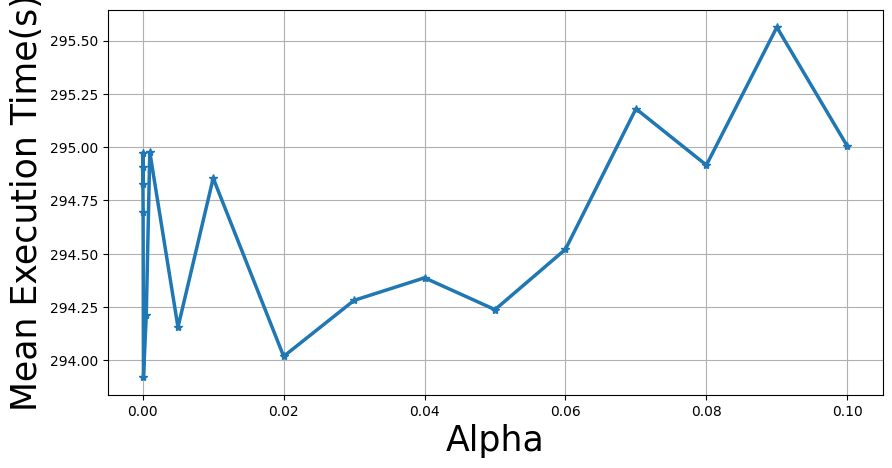

In [51]:
Varlingam_Mean_Exe_Time_Macaque = np.zeros((len(alpha),1))

for a in range(0, len(alpha)):
    Varlingam_Mean_Exe_Time_Macaque[a] = np.mean(varlingam_macaque_execution_time[0:num_rep_macaque,a])

plt.figure(figsize = (10,5))
plt.plot(alpha, Varlingam_Mean_Exe_Time_Macaque, '-*', linewidth = 2.5)
plt.xlabel('Alpha', fontsize = 25)
plt.ylabel('Mean Execution Time(s)', fontsize = 25)
plt.grid()

In [52]:
varlingam_adj_TPR_all_rep_macaque = [['' for t in range(0, len(alpha))] for j in range(0,num_rep_macaque)]
varlingam_adj_FPR_all_rep_macaque = [['' for t in range(0, len(alpha))] for j in range(0,num_rep_macaque)]
varlingam_adj_Recall_all_rep_macaque =[['' for t in range(0, len(alpha))] for j in range(0,num_rep_macaque)]
varlingam_adj_Precision_all_rep_macaque = [['' for t in range(0, len(alpha))] for j in range(0,num_rep_macaque)]
varlingam_adj_F1_score_all_rep_macaque =[['' for t in range(0, len(alpha))] for j in range(0,num_rep_macaque)]

varlingam_ori_TPR_all_rep_macaque = [['' for t in range(0, len(alpha))] for j in range(0,num_rep_macaque)]
varlingam_ori_FPR_all_rep_macaque = [['' for t in range(0, len(alpha))] for j in range(0,num_rep_macaque)]
varlingam_ori_Recall_all_rep_macaque = [['' for t in range(0, len(alpha))] for j in range(0,num_rep_macaque)]
varlingam_ori_Precision_all_rep_macaque = [['' for t in range(0, len(alpha))] for j in range(0,num_rep_macaque)]
varlingam_ori_F1_score_all_rep_macaque = [['' for t in range(0, len(alpha))] for j in range(0,num_rep_macaque)]

macaque_ground_truth = ground_truth_graph_matrix_macaques_full

for r in range(0,num_rep_macaque):
    for a in range(0, len(alpha)):

        PAG = np.array(varlingam_link_matrix_macaque[r][a])
        
        summary_graph, estimated_adjacency_binary_matrix, estimated_orientation_binary_matrix = summarize_across_all_lags_v1(PAG)
        adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = find_tpr_fpr_all_lags(macaque_ground_truth, estimated_adjacency_binary_matrix, estimated_orientation_binary_matrix)

        varlingam_adj_TPR_all_rep_macaque[r][a] = adjacency_TPR
        varlingam_adj_FPR_all_rep_macaque[r][a]  = adjacency_FPR
        varlingam_adj_Recall_all_rep_macaque[r][a]  = adjacency_Recall
        varlingam_adj_Precision_all_rep_macaque[r][a] = adjacency_Precision
        varlingam_adj_F1_score_all_rep_macaque[r][a]  = adjacency_F1_score

        varlingam_ori_TPR_all_rep_macaque[r][a]  = orientation_TPR
        varlingam_ori_FPR_all_rep_macaque[r][a] = orientation_FPR
        varlingam_ori_Recall_all_rep_macaque[r][a] = orientation_Recall
        varlingam_ori_Precision_all_rep_macaque[r][a]  = orientation_Precision
        varlingam_ori_F1_score_all_rep_macaque[r][a]  = orientation_F1_score

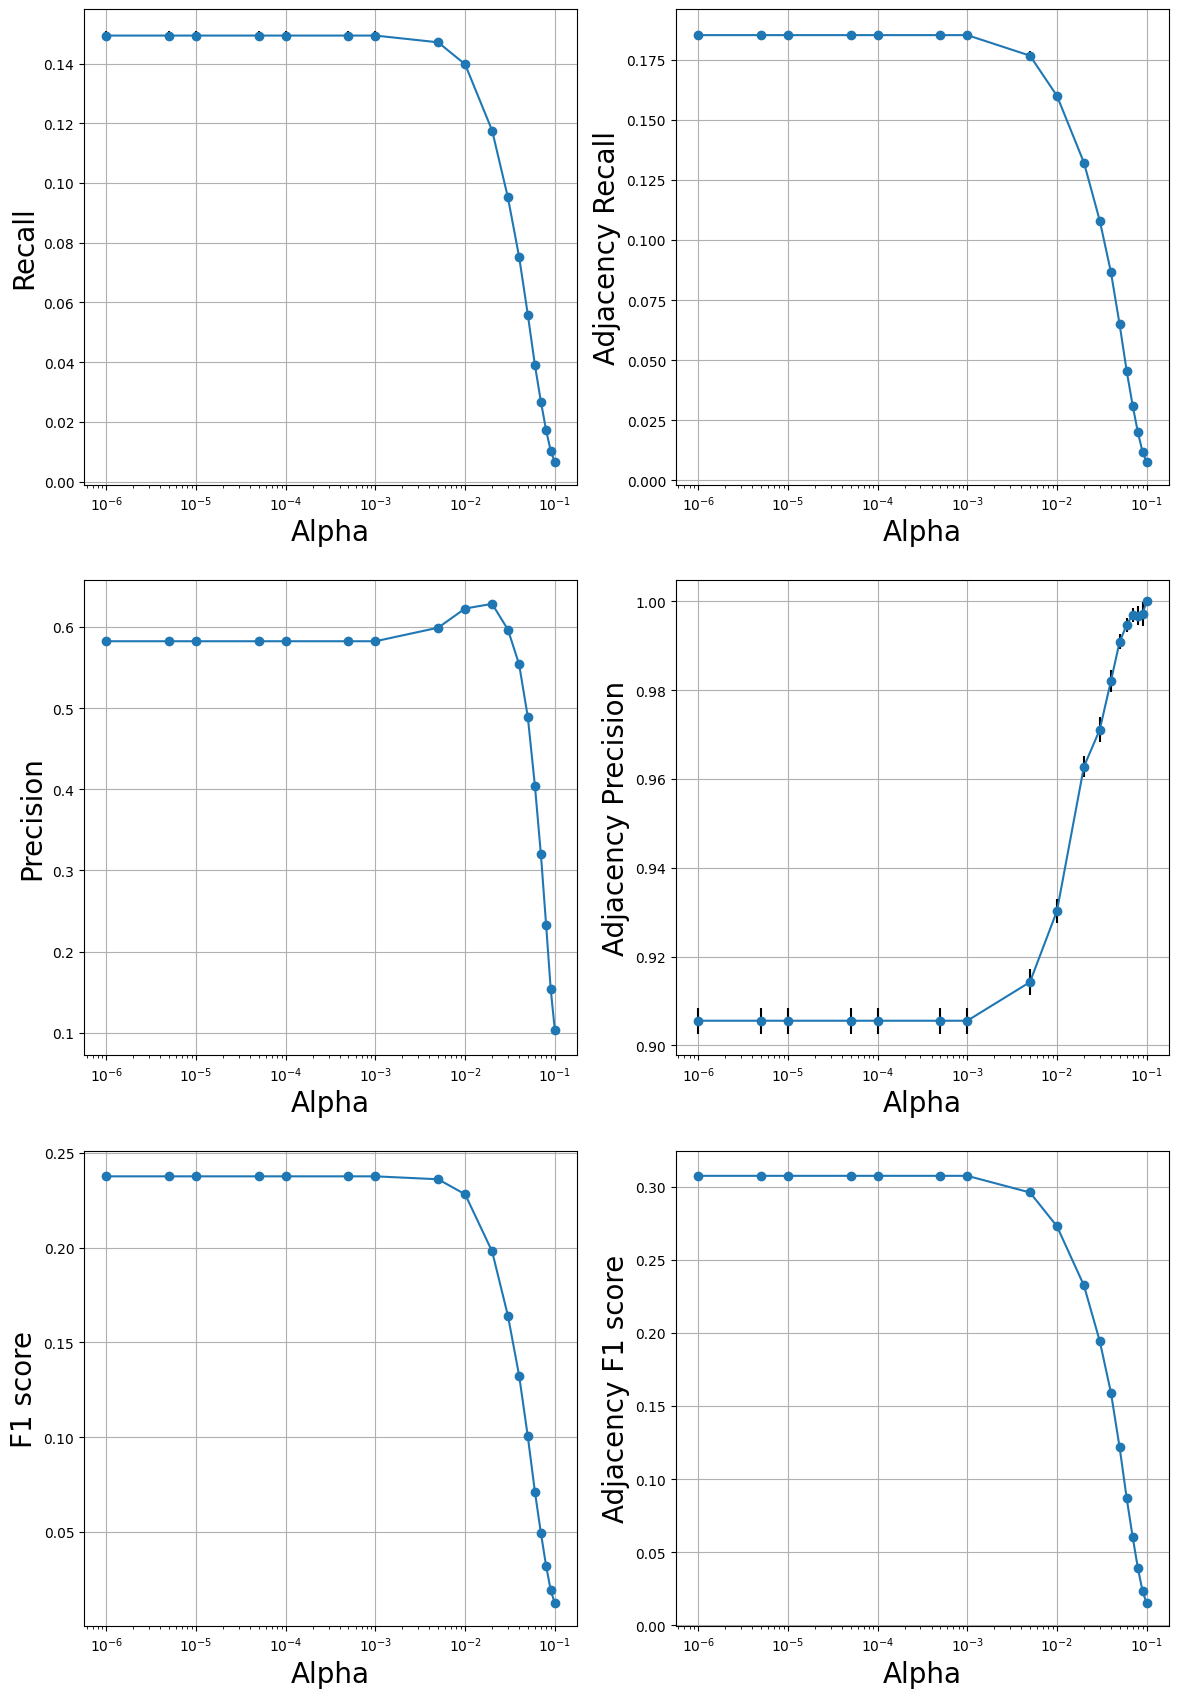

In [53]:
plt.figure(figsize = (14, 21))

varlingam_adj_recall_mean_macaque = np.zeros_like(alpha)
varlingam_adj_recall_std_macaque = np.zeros_like(alpha)
varlingam_adj_recall_median_macaque = np.zeros_like(alpha)

varlingam_adj_precision_mean_macaque = np.zeros_like(alpha) 
varlingam_adj_precision_std_macaque = np.zeros_like(alpha)
varlingam_adj_precision_median_macaque = np.zeros_like(alpha) 

varlingam_adj_F1_score_mean_macaque = np.zeros_like(alpha) 
varlingam_adj_F1_score_std_macaque = np.zeros_like(alpha)
varlingam_adj_F1_score_median_macaque = np.zeros_like(alpha) 

varlingam_ori_recall_mean_macaque = np.zeros_like(alpha)
varlingam_ori_recall_std_macaque = np.zeros_like(alpha)
varlingam_ori_recall_median_macaque = np.zeros_like(alpha)

varlingam_ori_precision_mean_macaque = np.zeros_like(alpha)
varlingam_ori_precision_std_macaque = np.zeros_like(alpha)
varlingam_ori_precision_median_macaque = np.zeros_like(alpha)

varlingam_ori_F1_score_mean_macaque = np.zeros_like(alpha)
varlingam_ori_F1_score_std_macaque =np.zeros_like(alpha)
varlingam_ori_F1_score_median_macaque = np.zeros_like(alpha)

for a in range(0,len(alpha)):

    varlingam_adj_recall_mean_macaque[a] = np.mean(np.array(varlingam_adj_Recall_all_rep_macaque)[:,a])
    varlingam_adj_recall_std_macaque[a] = np.std(np.array(varlingam_adj_Recall_all_rep_macaque)[:,a])
    varlingam_adj_recall_median_macaque[a] = np.median(np.array(varlingam_adj_Recall_all_rep_macaque)[:,a])

    varlingam_adj_precision_mean_macaque[a] = np.mean(np.array(varlingam_adj_Precision_all_rep_macaque)[:,a])
    varlingam_adj_precision_std_macaque[a] = np.std(np.array(varlingam_adj_Precision_all_rep_macaque)[:,a])
    varlingam_adj_precision_median_macaque[a] = np.median(np.array(varlingam_adj_Precision_all_rep_macaque)[:,a])

    varlingam_adj_F1_score_mean_macaque[a] = np.mean(np.array(varlingam_adj_F1_score_all_rep_macaque)[:,a])
    varlingam_adj_F1_score_std_macaque[a] = np.std(np.array(varlingam_adj_F1_score_all_rep_macaque)[:,a])
    varlingam_adj_F1_score_median_macaque[a] = np.median(np.array(varlingam_adj_F1_score_all_rep_macaque)[:,a])

    varlingam_ori_recall_mean_macaque[a] = np.mean(np.array(varlingam_ori_Recall_all_rep_macaque)[:,a])
    varlingam_ori_recall_std_macaque[a] = np.std(np.array(varlingam_ori_Recall_all_rep_macaque)[:,a])
    varlingam_ori_recall_median_macaque[a] = np.median(np.array(varlingam_ori_Recall_all_rep_macaque)[:,a])

    varlingam_ori_precision_mean_macaque[a] = np.mean(np.array(varlingam_ori_Precision_all_rep_macaque)[:,a])
    varlingam_ori_precision_std_macaque[a] = np.std(np.array(varlingam_ori_Precision_all_rep_macaque)[:,a])
    varlingam_ori_precision_median_macaque[a] = np.median(np.array(varlingam_ori_Precision_all_rep_macaque)[:,a])

    varlingam_ori_F1_score_mean_macaque[a] = np.mean(np.array(varlingam_ori_F1_score_all_rep_macaque)[:,a])
    varlingam_ori_F1_score_std_macaque[a] = np.std(np.array(varlingam_ori_F1_score_all_rep_macaque)[:,a])
    varlingam_ori_F1_score_median_macaque[a] = np.median(np.array(varlingam_ori_F1_score_all_rep_macaque)[:,a])

varlingam_best_alpha_adj_mean= alpha[np.argmax(varlingam_adj_F1_score_mean_macaque)]
varlingam_best_alpha_adj_median = alpha[np.argmax(varlingam_adj_F1_score_median_macaque)]
varlingam_best_alpha_ori_mean = alpha[np.argmax(varlingam_ori_F1_score_mean_macaque)]
varlingam_best_alpha_ori_median = alpha[np.argmax(varlingam_ori_F1_score_median_macaque)]

plt.subplot(3,2,2)
plt.errorbar(alpha, varlingam_adj_recall_mean_macaque, varlingam_adj_recall_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('Adjacency Recall', fontsize = 20)
plt.grid()
plt.grid(visible = True)


plt.subplot(3,2,1)
plt.errorbar(alpha, varlingam_ori_recall_mean_macaque, varlingam_ori_recall_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('Recall', fontsize = 20)
plt.grid(visible = True)


plt.subplot(3,2,4)
plt.errorbar(alpha, varlingam_adj_precision_mean_macaque, varlingam_adj_precision_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('Adjacency Precision', fontsize = 20)
plt.grid(visible = True)


plt.subplot(3,2,3)
plt.errorbar(alpha, varlingam_ori_precision_mean_macaque, varlingam_ori_precision_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('Precision', fontsize = 20)
plt.grid(visible = True)


plt.subplot(3,2,6)
plt.errorbar(alpha, varlingam_adj_F1_score_mean_macaque, varlingam_adj_F1_score_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('Adjacency F1 score', fontsize = 20)
plt.grid(visible = True)


plt.subplot(3,2,5)
plt.errorbar(alpha, varlingam_ori_F1_score_mean_macaque, varlingam_ori_F1_score_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('F1 score', fontsize = 20)
plt.grid(visible = True)


## DYNOTEARS

In [54]:
num_rep_macaque_dynotears = 20 

### Dynotears Execution Time

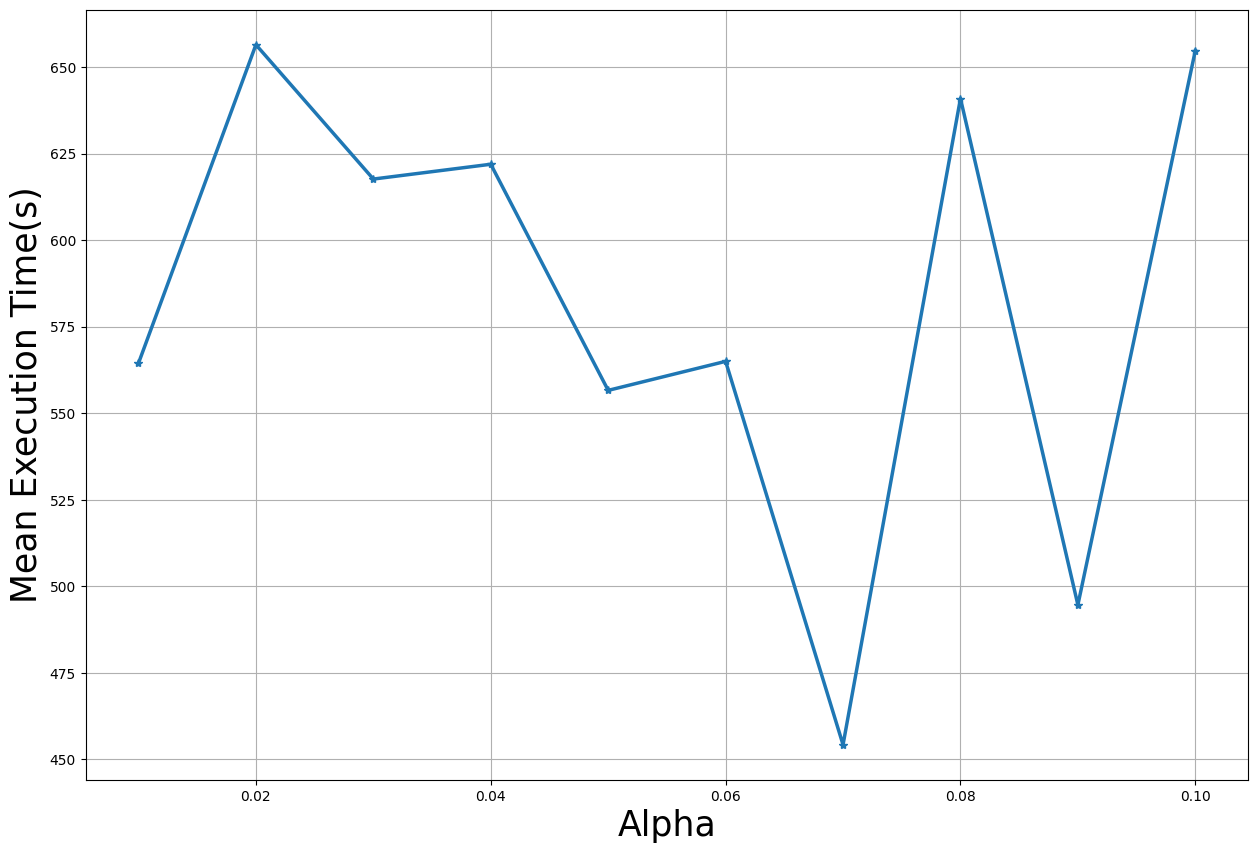

In [55]:
Dynotears_Mean_Exe_Time_Macaque = np.zeros((len(alpha_dynotears),1))

for a in range(0, len(alpha_dynotears)):
    Dynotears_Mean_Exe_Time_Macaque[a] = np.mean(dynotears_macaque_execution_time[:][a])

plt.figure(figsize = (15,10))
plt.plot(alpha_dynotears, Dynotears_Mean_Exe_Time_Macaque, '-*', linewidth = 2.5)
plt.xlabel('Alpha', fontsize = 25)
plt.ylabel('Mean Execution Time(s)', fontsize = 25)
plt.grid()

In [56]:
dynotears_adj_TPR_all_rep_macaque = [['' for t in range(0, len(alpha_dynotears))] for j in range(0,num_rep_macaque_dynotears)]
dynotears_adj_FPR_all_rep_macaque = [['' for t in range(0, len(alpha_dynotears))] for j in range(0,num_rep_macaque_dynotears)]
dynotears_adj_Recall_all_rep_macaque =[['' for t in range(0, len(alpha_dynotears))] for j in range(0,num_rep_macaque_dynotears)]
dynotears_adj_Precision_all_rep_macaque = [['' for t in range(0, len(alpha_dynotears))] for j in range(0,num_rep_macaque_dynotears)]
dynotears_adj_F1_score_all_rep_macaque =[['' for t in range(0, len(alpha_dynotears))] for j in range(0,num_rep_macaque_dynotears)]

dynotears_ori_TPR_all_rep_macaque = [['' for t in range(0, len(alpha_dynotears))] for j in range(0,num_rep_macaque_dynotears)]
dynotears_ori_FPR_all_rep_macaque = [['' for t in range(0, len(alpha_dynotears))] for j in range(0,num_rep_macaque_dynotears)]
dynotears_ori_Recall_all_rep_macaque = [['' for t in range(0, len(alpha_dynotears))] for j in range(0,num_rep_macaque_dynotears)]
dynotears_ori_Precision_all_rep_macaque = [['' for t in range(0, len(alpha_dynotears))] for j in range(0,num_rep_macaque_dynotears)]
dynotears_ori_F1_score_all_rep_macaque = [['' for t in range(0, len(alpha_dynotears))] for j in range(0,num_rep_macaque_dynotears)]

macaque_ground_truth = ground_truth_graph_matrix_macaques_full

for r in range(0,num_rep_macaque_dynotears):
    for a in range(0, len(alpha_dynotears)):

        PAG = np.array(dynotears_link_matrix_all_macaque[r][a])

        summary_graph, estimated_adjacency_binary_matrix, estimated_orientation_binary_matrix = summarize_across_all_lags_v1(PAG)
        adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = find_tpr_fpr_all_lags(macaque_ground_truth, estimated_adjacency_binary_matrix, estimated_orientation_binary_matrix)

        dynotears_adj_TPR_all_rep_macaque[r][a] = adjacency_TPR
        dynotears_adj_FPR_all_rep_macaque[r][a]  = adjacency_FPR
        dynotears_adj_Recall_all_rep_macaque[r][a]  = adjacency_Recall
        dynotears_adj_Precision_all_rep_macaque[r][a] = adjacency_Precision
        dynotears_adj_F1_score_all_rep_macaque[r][a]  = adjacency_F1_score

        dynotears_ori_TPR_all_rep_macaque[r][a]  = orientation_TPR
        dynotears_ori_FPR_all_rep_macaque[r][a] = orientation_FPR
        dynotears_ori_Recall_all_rep_macaque[r][a] = orientation_Recall
        dynotears_ori_Precision_all_rep_macaque[r][a]  = orientation_Precision
        dynotears_ori_F1_score_all_rep_macaque[r][a]  = orientation_F1_score

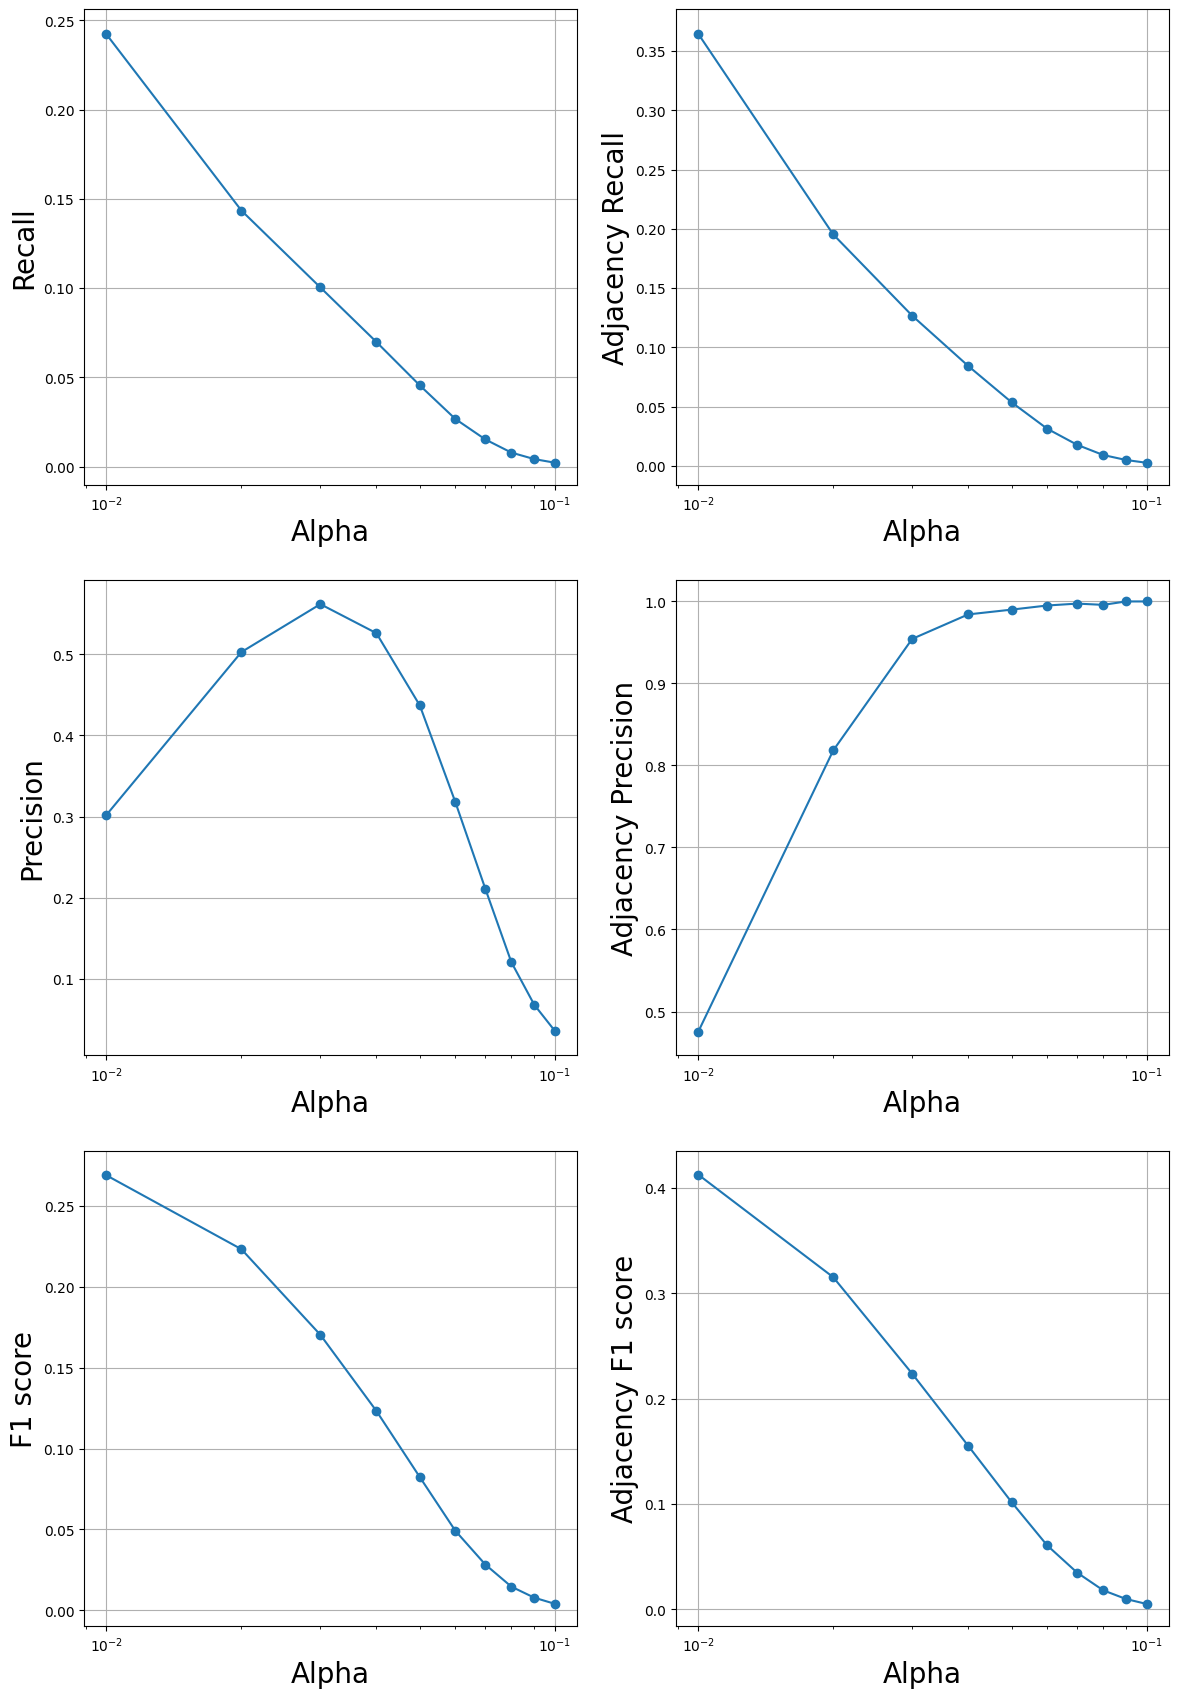

In [57]:
plt.figure(figsize = (14, 21))

dynotears_adj_recall_mean_macaque = np.zeros_like(alpha_dynotears)
dynotears_adj_recall_std_macaque = np.zeros_like(alpha_dynotears)
dynotears_adj_recall_median_macaque = np.zeros_like(alpha_dynotears)

dynotears_adj_precision_mean_macaque = np.zeros_like(alpha_dynotears) 
dynotears_adj_precision_std_macaque = np.zeros_like(alpha_dynotears)
dynotears_adj_precision_median_macaque = np.zeros_like(alpha_dynotears) 

dynotears_adj_F1_score_mean_macaque = np.zeros_like(alpha_dynotears) 
dynotears_adj_F1_score_std_macaque = np.zeros_like(alpha_dynotears)
dynotears_adj_F1_score_median_macaque = np.zeros_like(alpha_dynotears) 

dynotears_ori_recall_mean_macaque = np.zeros_like(alpha_dynotears)
dynotears_ori_recall_std_macaque = np.zeros_like(alpha_dynotears)
dynotears_ori_recall_median_macaque = np.zeros_like(alpha_dynotears)

dynotears_ori_precision_mean_macaque = np.zeros_like(alpha_dynotears)
dynotears_ori_precision_std_macaque = np.zeros_like(alpha_dynotears)
dynotears_ori_precision_median_macaque = np.zeros_like(alpha_dynotears)

dynotears_ori_F1_score_mean_macaque = np.zeros_like(alpha_dynotears)
dynotears_ori_F1_score_std_macaque =np.zeros_like(alpha_dynotears)
dynotears_ori_F1_score_median_macaque = np.zeros_like(alpha_dynotears)

for a in range(0,len(alpha_dynotears)):

    dynotears_adj_recall_mean_macaque[a] = np.mean(np.array(dynotears_adj_Recall_all_rep_macaque)[:,a])
    dynotears_adj_recall_std_macaque[a] = np.std(np.array(dynotears_adj_Recall_all_rep_macaque)[:,a])
    dynotears_adj_recall_median_macaque[a] = np.median(np.array(dynotears_adj_Recall_all_rep_macaque)[:,a])


    dynotears_adj_precision_mean_macaque[a] = np.mean(np.array(dynotears_adj_Precision_all_rep_macaque)[:,a])
    dynotears_adj_precision_std_macaque[a] = np.std(np.array(dynotears_adj_Precision_all_rep_macaque)[:,a])
    dynotears_adj_precision_median_macaque[a] = np.median(np.array(dynotears_adj_Precision_all_rep_macaque)[:,a])


    dynotears_adj_F1_score_mean_macaque[a] = np.mean(np.array(dynotears_adj_F1_score_all_rep_macaque)[:,a])
    dynotears_adj_F1_score_std_macaque[a] = np.std(np.array(dynotears_adj_F1_score_all_rep_macaque)[:,a])
    dynotears_adj_F1_score_median_macaque[a] = np.median(np.array(dynotears_adj_F1_score_all_rep_macaque)[:,a])


    dynotears_ori_recall_mean_macaque[a] = np.mean(np.array(dynotears_ori_Recall_all_rep_macaque)[:,a])
    dynotears_ori_recall_std_macaque[a] = np.std(np.array(dynotears_ori_Recall_all_rep_macaque)[:,a])
    dynotears_ori_recall_median_macaque[a] = np.median(np.array(dynotears_ori_Recall_all_rep_macaque)[:,a])


    dynotears_ori_precision_mean_macaque[a] = np.mean(np.array(dynotears_ori_Precision_all_rep_macaque)[:,a])
    dynotears_ori_precision_std_macaque[a] = np.std(np.array(dynotears_ori_Precision_all_rep_macaque)[:,a])
    dynotears_ori_precision_median_macaque[a] = np.median(np.array(dynotears_ori_Precision_all_rep_macaque)[:,a])

    dynotears_ori_F1_score_mean_macaque[a] = np.mean(np.array(dynotears_ori_F1_score_all_rep_macaque)[:,a])
    dynotears_ori_F1_score_std_macaque[a] = np.std(np.array(dynotears_ori_F1_score_all_rep_macaque)[:,a])
    dynotears_ori_F1_score_median_macaque[a] = np.median(np.array(dynotears_ori_F1_score_all_rep_macaque)[:,a])

dynotears_best_alpha_adj_mean= alpha_dynotears[np.argmax(dynotears_adj_F1_score_mean_macaque)]
dynotears_best_alpha_adj_median = alpha_dynotears[np.argmax(dynotears_adj_F1_score_median_macaque)]
dynotears_best_alpha_ori_mean = alpha_dynotears[np.argmax(dynotears_ori_F1_score_mean_macaque)]
dynotears_best_alpha_ori_median = alpha_dynotears[np.argmax(dynotears_ori_F1_score_median_macaque)]


plt.subplot(3,2,2)
plt.errorbar(alpha_dynotears, dynotears_adj_recall_mean_macaque, dynotears_adj_recall_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('Adjacency Recall', fontsize = 20)
plt.grid()
plt.grid(visible = True)


plt.subplot(3,2,1)
plt.errorbar(alpha_dynotears, dynotears_ori_recall_mean_macaque, dynotears_ori_recall_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('Recall', fontsize = 20)
plt.grid(visible = True)


plt.subplot(3,2,4)
plt.errorbar(alpha_dynotears, dynotears_adj_precision_mean_macaque, dynotears_adj_precision_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('Adjacency Precision', fontsize = 20)
plt.grid(visible = True)


plt.subplot(3,2,3)
plt.errorbar(alpha_dynotears, dynotears_ori_precision_mean_macaque, dynotears_ori_precision_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('Precision', fontsize = 20)
plt.grid(visible = True)


plt.subplot(3,2,6)
plt.errorbar(alpha_dynotears, dynotears_adj_F1_score_mean_macaque, dynotears_adj_F1_score_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('Adjacency F1 score', fontsize = 20)
plt.grid(visible = True)


plt.subplot(3,2,5)
plt.errorbar(alpha_dynotears, dynotears_ori_F1_score_mean_macaque, dynotears_ori_F1_score_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('F1 score', fontsize = 20)
plt.grid(visible = True)


## MVGC (Multivariate Granger Causality)

### Execution Time for MVGC

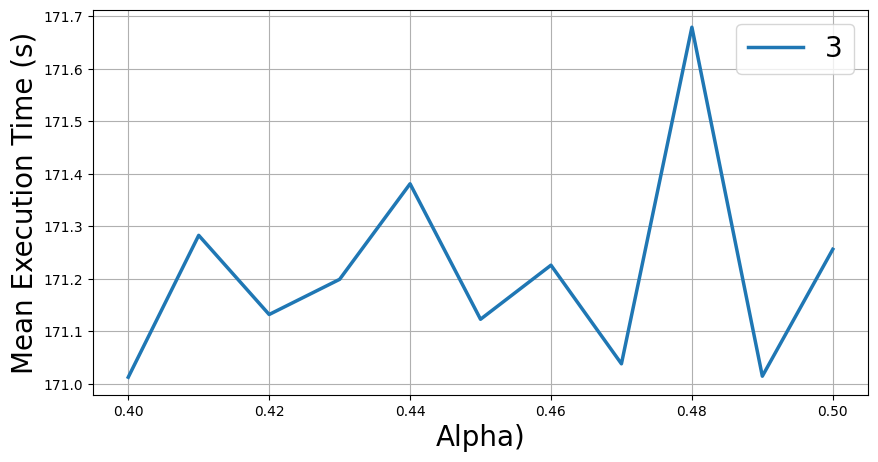

In [58]:
MVGC_Mean_Exe_Time_Macaque = np.zeros((len(mvgc_lags), len(mvgc_alpha)))
plt.figure(figsize = (10,5))

for l in range(0,len(mvgc_lags)):
    for a in range(0, len(mvgc_alpha)):
        MVGC_Mean_Exe_Time_Macaque[l][a] = np.mean(np.array(mvgc_macaque_execution_time)[0:num_rep_macaque,l,a])

    plt.plot(mvgc_alpha, MVGC_Mean_Exe_Time_Macaque[:][l], linewidth = 2.5)
    plt.xlabel('Alpha)', fontsize = 20)
    plt.ylabel('Mean Execution Time (s)', fontsize = 20)
    plt.grid()
plt.legend(mvgc_lags,fontsize = 20)

### MVGC Performance

In [59]:
mvgc_adj_TPR_all_rep_macaque_both_alpha = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,len(mvgc_lags))] for i in range(0,num_rep_macaque )]
mvgc_adj_FPR_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,len(mvgc_lags))] for i in range(0,num_rep_macaque )]
mvgc_adj_Recall_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,len(mvgc_lags))] for i in range(0,num_rep_macaque )]
mvgc_adj_Precision_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,len(mvgc_lags))] for i in range(0,num_rep_macaque )]
mvgc_adj_F1_score_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,len(mvgc_lags))] for i in range(0,num_rep_macaque )]

mvgc_ori_TPR_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,len(mvgc_lags))] for i in range(0,num_rep_macaque )]
mvgc_ori_FPR_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,len(mvgc_lags))] for i in range(0,num_rep_macaque )]
mvgc_ori_Recall_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,len(mvgc_lags))] for i in range(0,num_rep_macaque )]
mvgc_ori_Precision_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,len(mvgc_lags))] for i in range(0,num_rep_macaque )]
mvgc_ori_F1_score_all_rep_macaque_both_alpha  = [[['' for t in range(0, len(mvgc_alpha))] for j in range(0,len(mvgc_lags))] for i in range(0,num_rep_macaque )]

macaque_ground_truth = ground_truth_graph_matrix_macaques_full

for r in range(0,num_rep_macaque):
    for l in range(0, len(mvgc_lags)):
        for a in range(0, len(mvgc_alpha)):

            DAG = np.array(mvgc_link_matrix_all_macaque[r][l][a])-1
            estimated_non_zero_lags_combined = DAG
            adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = find_tpr_fpr_nonzero_lags(macaque_ground_truth, estimated_non_zero_lags_combined)

            mvgc_adj_TPR_all_rep_macaque_both_alpha[r][l][a] = adjacency_TPR
            mvgc_adj_FPR_all_rep_macaque_both_alpha[r][l][a]  = adjacency_FPR
            mvgc_adj_Recall_all_rep_macaque_both_alpha[r][l][a]  = adjacency_Recall
            mvgc_adj_Precision_all_rep_macaque_both_alpha[r][l][a] = adjacency_Precision
            mvgc_adj_F1_score_all_rep_macaque_both_alpha[r][l][a] = adjacency_F1_score

            mvgc_ori_TPR_all_rep_macaque_both_alpha[r][l][a] = orientation_TPR
            mvgc_ori_FPR_all_rep_macaque_both_alpha[r][l][a]= orientation_FPR
            mvgc_ori_Recall_all_rep_macaque_both_alpha[r][l][a] = orientation_Recall
            mvgc_ori_Precision_all_rep_macaque_both_alpha[r][l][a]  = orientation_Precision
            mvgc_ori_F1_score_all_rep_macaque_both_alpha[r][l][a] = orientation_F1_score


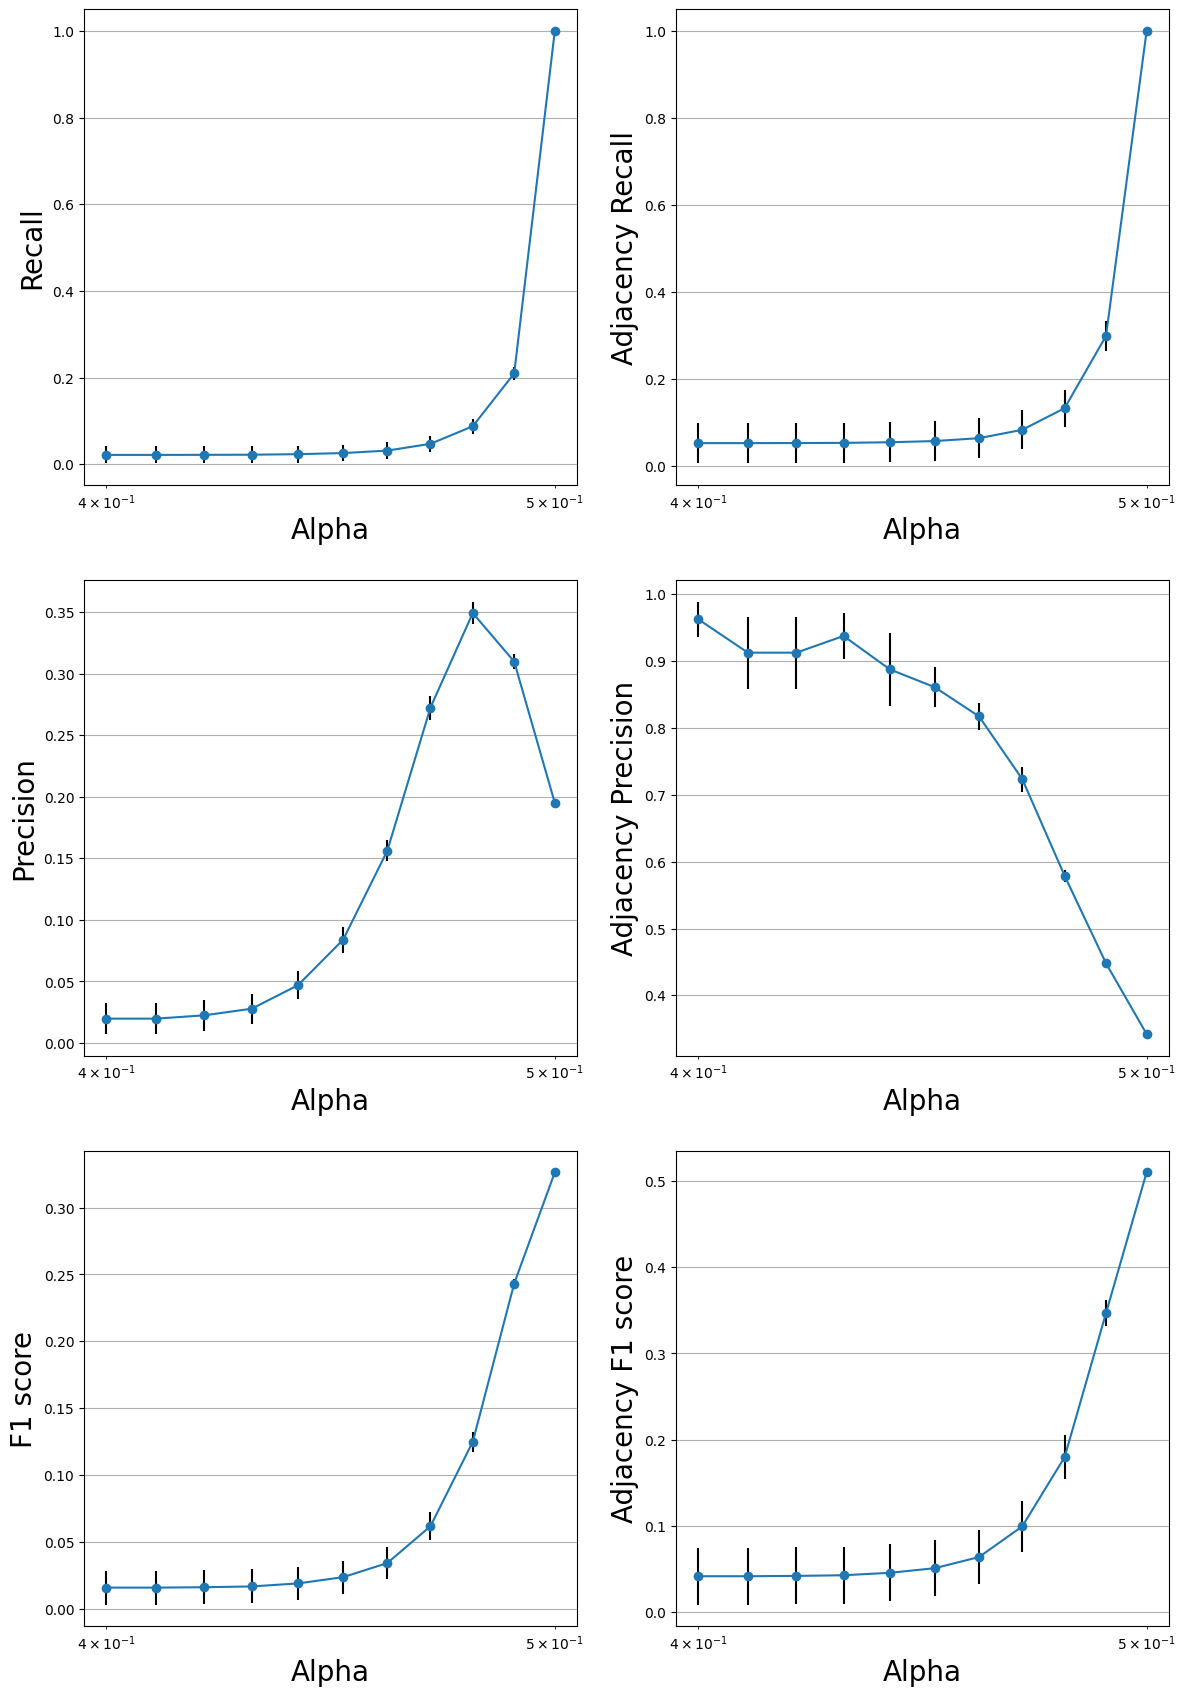

In [60]:
plt.figure(figsize = (14, 21))

for k in range(0, len(mvgc_lags)):

    mvgc_adj_recall_mean_macaque = np.zeros_like(mvgc_alpha)
    mvgc_adj_recall_std_macaque = np.zeros_like(mvgc_alpha)
    mvgc_adj_recall_median_macaque = np.zeros_like(mvgc_alpha)

    mvgc_adj_precision_mean_macaque = np.zeros_like(mvgc_alpha) 
    mvgc_adj_precision_std_macaque = np.zeros_like(mvgc_alpha)
    mvgc_adj_precision_median_macaque = np.zeros_like(mvgc_alpha) 

    mvgc_adj_F1_score_mean_macaque = np.zeros_like(mvgc_alpha) 
    mvgc_adj_F1_score_std_macaque = np.zeros_like(mvgc_alpha)
    mvgc_adj_F1_score_median_macaque = np.zeros_like(mvgc_alpha) 

    mvgc_ori_recall_mean_macaque = np.zeros_like(mvgc_alpha)
    mvgc_ori_recall_std_macaque = np.zeros_like(mvgc_alpha)
    mvgc_ori_recall_median_macaque = np.zeros_like(mvgc_alpha)

    mvgc_ori_precision_mean_macaque = np.zeros_like(mvgc_alpha)
    mvgc_ori_precision_std_macaque = np.zeros_like(mvgc_alpha)
    mvgc_ori_precision_median_macaque = np.zeros_like(mvgc_alpha)

    mvgc_ori_F1_score_mean_macaque = np.zeros_like(mvgc_alpha)
    mvgc_ori_F1_score_std_macaque =np.zeros_like(mvgc_alpha)
    mvgc_ori_F1_score_median_macaque = np.zeros_like(mvgc_alpha)

    for a in range(0,len(mvgc_alpha)):

        mvgc_adj_recall_mean_macaque[a] = np.mean(np.array(mvgc_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])
        mvgc_adj_recall_std_macaque[a] = np.std(np.array(mvgc_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])
        mvgc_adj_recall_median_macaque[a] = np.median(np.array(mvgc_adj_Recall_all_rep_macaque_both_alpha)[:,k,a])

        mvgc_adj_precision_mean_macaque[a] = np.mean(np.array(mvgc_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])
        mvgc_adj_precision_std_macaque[a] = np.std(np.array(mvgc_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])
        mvgc_adj_precision_median_macaque[a] = np.median(np.array(mvgc_adj_Precision_all_rep_macaque_both_alpha)[:,k,a])

        mvgc_adj_F1_score_mean_macaque[a] = np.mean(np.array(mvgc_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        mvgc_adj_F1_score_std_macaque[a] = np.std(np.array(mvgc_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        mvgc_adj_F1_score_median_macaque[a] = np.median(np.array(mvgc_adj_F1_score_all_rep_macaque_both_alpha)[:,k,a])

        mvgc_ori_recall_mean_macaque[a] = np.mean(np.array(mvgc_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])
        mvgc_ori_recall_std_macaque[a] = np.std(np.array(mvgc_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])
        mvgc_ori_recall_median_macaque[a] = np.median(np.array(mvgc_ori_Recall_all_rep_macaque_both_alpha)[:,k,a])

        mvgc_ori_precision_mean_macaque[a] = np.mean(np.array(mvgc_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])
        mvgc_ori_precision_std_macaque[a] = np.std(np.array(mvgc_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])
        mvgc_ori_precision_median_macaque[a] = np.median(np.array(mvgc_ori_Precision_all_rep_macaque_both_alpha)[:,k,a])

        mvgc_ori_F1_score_mean_macaque[a] = np.mean(np.array(mvgc_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        mvgc_ori_F1_score_std_macaque[a] = np.std(np.array(mvgc_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])
        mvgc_ori_F1_score_median_macaque[a] = np.median(np.array(mvgc_ori_F1_score_all_rep_macaque_both_alpha)[:,k,a])

    mvgc_best_alpha_adj_mean= mvgc_alpha[np.argmax(mvgc_adj_F1_score_mean_macaque)]
    mvgc_best_alpha_adj_median = mvgc_alpha[np.argmax(mvgc_adj_F1_score_median_macaque)]
    mvgc_best_alpha_ori_mean = mvgc_alpha[np.argmax(mvgc_ori_F1_score_mean_macaque)]
    mvgc_best_alpha_ori_median = mvgc_alpha[np.argmax(mvgc_ori_F1_score_median_macaque)]

    
plt.subplot(3,2,2)
plt.errorbar(mvgc_alpha, mvgc_adj_recall_mean_macaque, mvgc_adj_recall_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('Adjacency Recall', fontsize = 20)
plt.grid()
plt.grid(visible = True)


plt.subplot(3,2,1)
plt.errorbar(mvgc_alpha, mvgc_ori_recall_mean_macaque, mvgc_ori_recall_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('Recall', fontsize = 20)
plt.grid(visible = True)


plt.subplot(3,2,4)
plt.errorbar(mvgc_alpha, mvgc_adj_precision_mean_macaque, mvgc_adj_precision_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('Adjacency Precision', fontsize = 20)
plt.grid(visible = True)


plt.subplot(3,2,3)
plt.errorbar(mvgc_alpha, mvgc_ori_precision_mean_macaque, mvgc_ori_precision_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('Precision', fontsize = 20)
plt.grid(visible = True)


plt.subplot(3,2,6)
plt.errorbar(mvgc_alpha, mvgc_adj_F1_score_mean_macaque, mvgc_adj_F1_score_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('Adjacency F1 score', fontsize = 20)
plt.grid(visible = True)


plt.subplot(3,2,5)
plt.errorbar(mvgc_alpha, mvgc_ori_F1_score_mean_macaque, mvgc_ori_F1_score_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('Alpha', fontsize = 20)
plt.ylabel('F1 score', fontsize = 20)
plt.grid(visible = True)


## Comparison Between MVGC and CaLLTiF, DYNOTEARS and VARLiNGAM 

Text(0.5, 1.0, 'Adjacency')

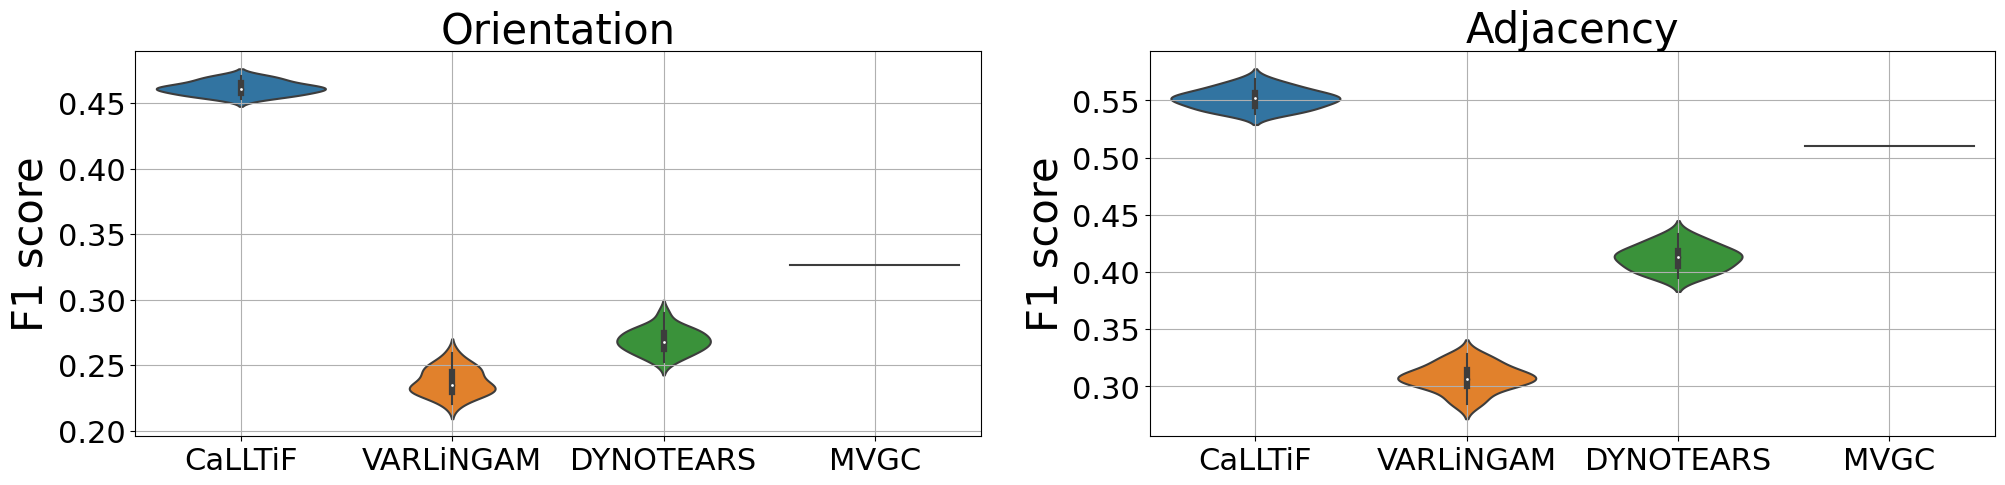

In [61]:
labels = ['CaLLTiF', 'VARLiNGAM','DYNOTEARS','MVGC']

CaLLTiF_best_alpha_adj_idx = np.argmax(calltif_adj_F1_score_median_macaque)
CaLLTiF_best_alpha_ori_idx = np.argmax(calltif_ori_F1_score_median_macaque)

MVGC_best_alpha_adj_idx = np.argmax(mvgc_adj_F1_score_median_macaque)
MVGC_best_alpha_ori_idx = np.argmax(mvgc_ori_F1_score_median_macaque)

Dynotears_best_alpha_adj_idx = np.argmax(dynotears_adj_F1_score_median_macaque)
Dynotears_best_alpha_ori_idx = np.argmax(dynotears_ori_F1_score_median_macaque)

Varlingam_best_alpha_adj_idx = np.argmax(varlingam_adj_F1_score_median_macaque)
Varlingam_best_alpha_ori_idx = np.argmax(varlingam_ori_F1_score_median_macaque)

## Adjacency
adj_all_methods_F1_score_dist  = []
adj_all_methods_F1_score_dist. append(np.array(calltif_adj_F1_score_all_rep_macaque_both_alpha)[:,0,CaLLTiF_best_alpha_adj_idx])
adj_all_methods_F1_score_dist. append(np.array(varlingam_adj_F1_score_all_rep_macaque)[:,Varlingam_best_alpha_adj_idx])
adj_all_methods_F1_score_dist. append(np.array(dynotears_adj_F1_score_all_rep_macaque)[:,Dynotears_best_alpha_adj_idx])
adj_all_methods_F1_score_dist. append(np.array(mvgc_adj_F1_score_all_rep_macaque_both_alpha)[:,0,MVGC_best_alpha_adj_idx])

ori_all_methods_F1_score_dist  = []
ori_all_methods_F1_score_dist. append(np.array(calltif_ori_F1_score_all_rep_macaque_both_alpha)[:,0,CaLLTiF_best_alpha_ori_idx])
ori_all_methods_F1_score_dist. append(np.array(varlingam_ori_F1_score_all_rep_macaque)[:,Varlingam_best_alpha_ori_idx])
ori_all_methods_F1_score_dist. append(np.array(dynotears_ori_F1_score_all_rep_macaque)[:,Dynotears_best_alpha_ori_idx])
ori_all_methods_F1_score_dist. append(np.array(mvgc_ori_F1_score_all_rep_macaque_both_alpha)[:,0,MVGC_best_alpha_ori_idx])

all_methods_time = []
all_methods_time.append(np.array(pcmci_macaque_execution_time)[0:num_rep_macaque,0,CaLLTiF_best_alpha_ori_idx])
all_methods_time.append(np.array(varlingam_macaque_execution_time)[0:num_rep_macaque,Varlingam_best_alpha_ori_idx])
all_methods_time.append(np.array(dynotears_macaque_execution_time)[0:num_rep_macaque,Dynotears_best_alpha_ori_idx])
all_methods_time.append(np.array(mvgc_macaque_execution_time)[0:num_rep_macaque,0,MVGC_best_alpha_ori_idx])

## f1 scores
plt.figure(figsize = (24,5))
ax = plt.subplot(1,2,1)
parts = sns.violinplot(ori_all_methods_F1_score_dist)

ax.set_xticklabels(labels,fontsize = 22)
plt.yticks(fontsize = 22)
plt.grid()
plt.ylabel('F1 score',fontsize = 30)
plt.title('Orientation',fontsize = 30)

ax = plt.subplot(1,2,2)
parts = sns.violinplot(adj_all_methods_F1_score_dist)

ax.set_xticklabels(labels,fontsize = 22)
plt.yticks(fontsize = 22)
plt.grid()
plt.ylabel('F1 score',fontsize = 30)
plt.title('Adjacency',fontsize = 30)


In [62]:
## F1 score
f1_score_calltif_varlingam = sp.stats.wilcoxon(np.array(calltif_ori_F1_score_all_rep_macaque_both_alpha)[:,0,CaLLTiF_best_alpha_ori_idx],np.array(varlingam_ori_F1_score_all_rep_macaque)[:,Varlingam_best_alpha_ori_idx], zero_method='wilcox', alternative='greater')
f1_score_calltif_dynotears = sp.stats.wilcoxon(np.array(calltif_ori_F1_score_all_rep_macaque_both_alpha)[:,0,CaLLTiF_best_alpha_ori_idx], np.array(dynotears_ori_F1_score_all_rep_macaque)[:,Dynotears_best_alpha_ori_idx], zero_method='wilcox', alternative='greater')
f1_score_calltif_mvgc = sp.stats.wilcoxon(np.array(calltif_ori_F1_score_all_rep_macaque_both_alpha)[:,0,CaLLTiF_best_alpha_ori_idx], np.array(mvgc_ori_F1_score_all_rep_macaque_both_alpha)[:,0,MVGC_best_alpha_ori_idx], zero_method='wilcox', alternative='greater')

## Adjacency F1 score

adj_f1_score_calltif_varlingam = sp.stats.wilcoxon(np.array(calltif_adj_F1_score_all_rep_macaque_both_alpha)[:,0,CaLLTiF_best_alpha_adj_idx], np.array(varlingam_adj_F1_score_all_rep_macaque)[:,Varlingam_best_alpha_adj_idx], zero_method='wilcox', alternative='greater')
adj_f1_score_calltif_dynotears = sp.stats.wilcoxon(np.array(calltif_adj_F1_score_all_rep_macaque_both_alpha)[:,0,CaLLTiF_best_alpha_adj_idx], np.array(dynotears_adj_F1_score_all_rep_macaque)[:,Dynotears_best_alpha_adj_idx], zero_method='wilcox', alternative='greater')
adj_f1_score_calltif_mvgc = sp.stats.wilcoxon(np.array(calltif_adj_F1_score_all_rep_macaque_both_alpha)[:,0,CaLLTiF_best_alpha_adj_idx], np.array(mvgc_adj_F1_score_all_rep_macaque_both_alpha)[:,0,MVGC_best_alpha_adj_idx], zero_method='wilcox', alternative='greater')

print('calltif-varlingam',f1_score_calltif_varlingam )
print('calltif-dynotears',f1_score_calltif_dynotears )
print('calltif-mvgc',f1_score_calltif_mvgc )

print('calltif-varlingam',adj_f1_score_calltif_varlingam )
print('calltif-dynotears',adj_f1_score_calltif_dynotears )
print('calltif-mvgc',adj_f1_score_calltif_mvgc )


calltif-varlingam WilcoxonResult(statistic=210.0, pvalue=9.5367431640625e-07)
calltif-dynotears WilcoxonResult(statistic=210.0, pvalue=9.5367431640625e-07)
calltif-mvgc WilcoxonResult(statistic=210.0, pvalue=9.5367431640625e-07)
calltif-varlingam WilcoxonResult(statistic=210.0, pvalue=9.5367431640625e-07)
calltif-dynotears WilcoxonResult(statistic=210.0, pvalue=9.5367431640625e-07)
calltif-mvgc WilcoxonResult(statistic=210.0, pvalue=9.5367431640625e-07)


In [63]:
# Initialise a list of combinations of groups that are significantly different
significant_combinations_ori = []
# Check from the outside pairs of boxes inwards
ls = list(range(1, len(ori_all_methods_F1_score_dist) + 1))
combinations = [(ls[x], ls[x + y]) for y in reversed(ls) for x in range((len(ls) - y))]
for combination in combinations:
    data1 = ori_all_methods_F1_score_dist[combination[0] - 1]
    data2 = ori_all_methods_F1_score_dist[combination[1] - 1]

    # Significance
    U, p = scipy.stats.wilcoxon(data1, data2, zero_method='zsplit',alternative='greater')
    if p < 0.05:
        significant_combinations_ori.append([combination, p])

print(significant_combinations_ori)

[[(1, 4), 9.5367431640625e-07], [(1, 3), 9.5367431640625e-07], [(1, 2), 9.5367431640625e-07]]


In [64]:
# Initialise a list of combinations of groups that are significantly different
significant_combinations_adj = []
# Check from the outside pairs of boxes inwards
ls = list(range(1, len(adj_all_methods_F1_score_dist) + 1))
combinations = [(ls[x], ls[x + y]) for y in reversed(ls) for x in range((len(ls) - y))]
for combination in combinations:
    data1 = adj_all_methods_F1_score_dist[combination[0] - 1]
    data2 = adj_all_methods_F1_score_dist[combination[1] - 1]

    # Significance
    U, p = scipy.stats.wilcoxon(data1, data2, zero_method='zsplit',alternative='greater')
    if p < 0.05:
        significant_combinations_adj.append([combination, p])

print(significant_combinations_adj)

[[(1, 4), 9.5367431640625e-07], [(1, 3), 9.5367431640625e-07], [(1, 2), 9.5367431640625e-07]]


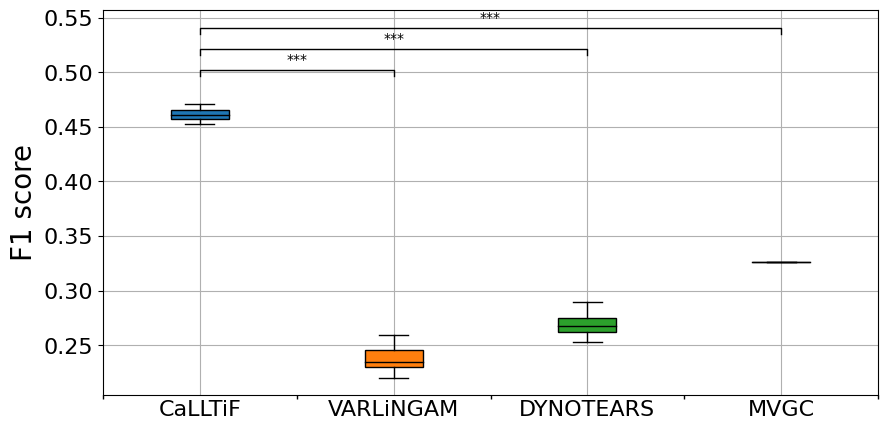

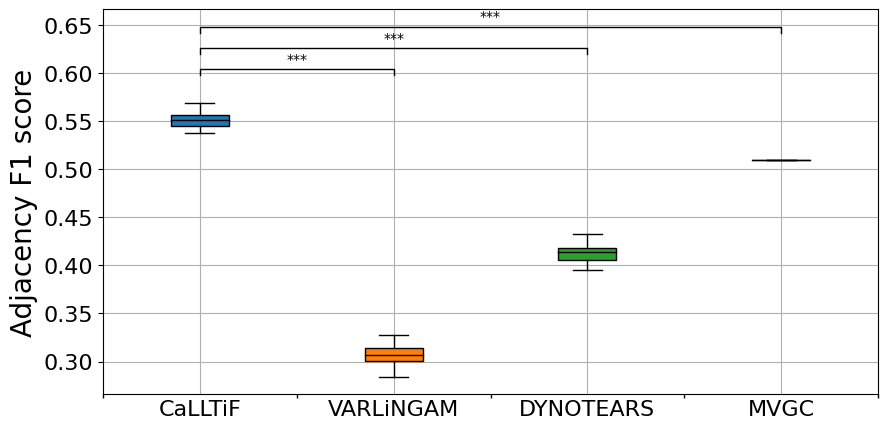

In [65]:
plt.figure(figsize = (10,5))
ax = plt.subplot()

# Create a boxplot on the axes
bp = ax.boxplot(ori_all_methods_F1_score_dist, widths=0.3, patch_artist=True)

colors = sns.color_palette()
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.yticks(fontsize = 16)
plt.grid()
plt.ylabel('F1 score',fontsize = 20)

# Label x-axis ticks
xticklabels = labels
ax.set_xticklabels(xticklabels, fontsize = 16)
ax.tick_params(axis='x', which='major', length=0)
xticks = [0.5] + [x + 0.5 for x in ax.get_xticks()]
ax.set_xticks(xticks, minor=True)
ax.tick_params(axis='x', which='minor', length=3, width=1)

# Colour of the median lines
plt.setp(bp['medians'], color='k')

# Get the y-axis limits
bottom, top = ax.get_ylim()
y_range = top - bottom

# Significance bars
for i, significant_combination in enumerate(significant_combinations_ori):
    # Columns corresponding to the datasets of interest
    x1 = significant_combination[0][0]
    x2 = significant_combination[0][1]
    # What level is this bar among the bars above the plot?
    level = len(significant_combinations_ori) - i
    # Plot the bar
    bar_height = (y_range * 0.07 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height + (y_range * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')

# adjacency
plt.figure(figsize = (10,5))
ax = plt.subplot()
plt.yticks(fontsize = 16)
plt.grid()
plt.ylabel('Adjacency F1 score',fontsize = 20)

bp = ax.boxplot(adj_all_methods_F1_score_dist, widths=0.3, patch_artist=True)

xticklabels = labels
ax.set_xticklabels(xticklabels, fontsize = 16)
ax.tick_params(axis='x', which='major', length=0)
xticks = [0.5] + [x + 0.5 for x in ax.get_xticks()]
ax.set_xticks(xticks, minor=True)
ax.tick_params(axis='x', which='minor', length=3, width=1)

# Change the colour of the boxes to Seaborn's 'pastel' palette
colors = sns.color_palette()
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Colour of the median lines
plt.setp(bp['medians'], color='k')

# Get the y-axis limits
bottom, top = ax.get_ylim()
y_range = top - bottom

# Significance bars
for i, significant_combination in enumerate(significant_combinations_adj):
    # Columns corresponding to the datasets of interest
    x1 = significant_combination[0][0]
    x2 = significant_combination[0][1]
    # What level is this bar among the bars above the plot?
    level = len(significant_combinations_adj) - i
    # Plot the bar
    bar_height = (y_range * 0.07 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height + (y_range * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')

Text(0, 0.5, 'Execution Time (s)')

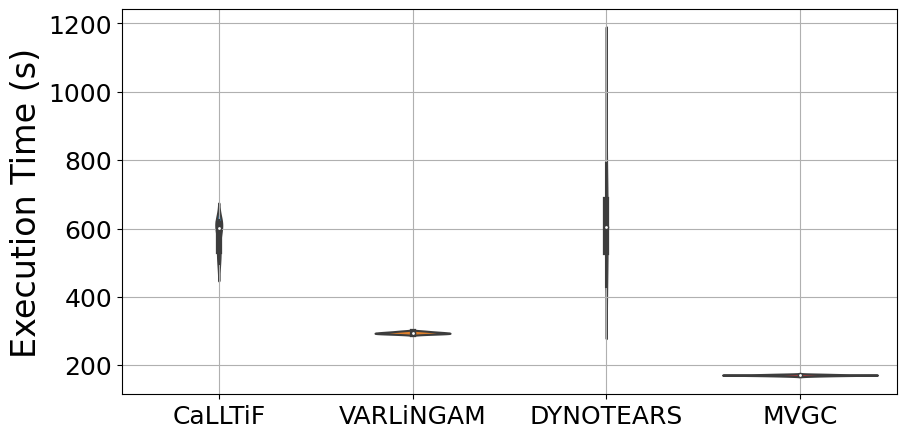

In [66]:
## time
plt.figure(figsize = (10,5))
ax = plt.subplot(1,1,1)
parts = sns.violinplot(all_methods_time)

ax.set_xticklabels(labels,fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid()
plt.ylabel('Execution Time (s)',fontsize = 24)


## Comparing CaLLTiF and MVGC

In [67]:
calltif_All_PAGs = []
MVGC_ALL_DAGs = []
calltif_All_DAGs = []

num_correct_edges_only_in_calltif = [0]*num_rep_macaque
num_correct_edges_only_in_mvgc = [0]*num_rep_macaque
num_correct_edges_in_both = [0]*num_rep_macaque
num_correct_edges_in_none = [0]*num_rep_macaque

for r in range(0,num_rep_macaque):

    calltif_All_PAGs.append(np.array(pcmci_link_matrix_all_macaque[r][0][CaLLTiF_best_alpha_ori_idx]))
    summary_graph, estimated_adjacency_binary_matrix, estimated_orientation_binary_matrix = summarize_across_all_lags_v2(np.array(pcmci_link_matrix_all_macaque[r][0][CaLLTiF_best_alpha_ori_idx]))

    calltif_All_DAGs.append(estimated_adjacency_binary_matrix)

    MVGC_ALL_DAGs.append(np.array(mvgc_link_matrix_all_macaque[r][0][MVGC_best_alpha_ori_idx])-1)

    x = estimated_adjacency_binary_matrix
    y = np.array(mvgc_link_matrix_all_macaque[r][0][MVGC_best_alpha_ori_idx])-1

    z = ground_truth_graph_matrix_macaques_full
    

    for i in range(0,num_nodes_macaque_full):
        for j in range(0, num_nodes_macaque_full):

            if z[i,j] == 1 and x[i,j]== 1 and y[i,j] == 0:
                num_correct_edges_only_in_calltif[r] = num_correct_edges_only_in_calltif[r]+1

            elif z[i,j] == 1 and x[i,j]== 0 and y[i,j] == 1:
                num_correct_edges_only_in_mvgc[r] = num_correct_edges_only_in_mvgc[r] + 1

            elif z[i,j] == 1 and x[i,j]== 1 and y[i,j] == 1:
                num_correct_edges_in_both[r] = num_correct_edges_in_both[r] + 1

            elif z[i,j] == 1 and x[i,j]== 0 and y[i,j] == 0:
                num_correct_edges_in_none[r] = num_correct_edges_in_none[r] + 1


In [68]:
total_number_of_edges_in_macaque_full = np.sum(ground_truth_graph_matrix_macaques_full)

Text(0, 0.5, 'Percentage of Edges')

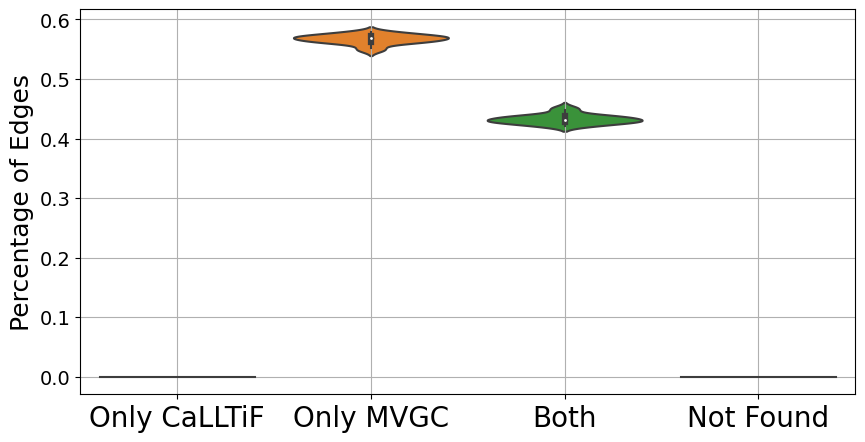

In [69]:
labels = ['Only CaLLTiF','Only MVGC','Both', 'Not Found']
plt.figure(figsize = (10,5))

violin_parts = sns.violinplot([np.array(num_correct_edges_only_in_calltif)/total_number_of_edges_in_macaque_full, np.array(num_correct_edges_only_in_mvgc)/total_number_of_edges_in_macaque_full,np.array(num_correct_edges_in_both)/total_number_of_edges_in_macaque_full,np.array(num_correct_edges_in_none)/total_number_of_edges_in_macaque_full], scale='width')
plt.xticks(np.arange(0,4), labels = labels, rotation = 'horizontal',fontsize = 20)
h = plt.yticks(fontsize = 14)
plt.grid()
plt.ylabel('Percentage of Edges', fontsize = 18)


In [70]:
calltif_All_PAGs = []
MVGC_ALL_DAGs = []
calltif_All_DAGs = []

num_correct_edges_only_in_calltif = [0]*num_rep_macaque
num_correct_edges_only_in_mvgc = [0]*num_rep_macaque
num_correct_edges_in_both = [0]*num_rep_macaque
num_correct_edges_in_none = [0]*num_rep_macaque

for r in range(0,num_rep_macaque):

    calltif_All_PAGs.append(np.array(pcmci_link_matrix_all_macaque[r][0][CaLLTiF_best_alpha_ori_idx]))
    summary_graph, estimated_adjacency_binary_matrix, estimated_orientation_binary_matrix = summarize_across_all_lags_v2(np.array(pcmci_link_matrix_all_macaque[r][0][CaLLTiF_best_alpha_ori_idx]))

    calltif_All_DAGs.append(estimated_adjacency_binary_matrix)

    MVGC_ALL_DAGs.append(np.array(mvgc_link_matrix_all_macaque[r][0][MVGC_best_alpha_ori_idx])-1)

    x = estimated_adjacency_binary_matrix
    y = np.array(mvgc_link_matrix_all_macaque[r][0][MVGC_best_alpha_ori_idx])-1

    z = ground_truth_graph_matrix_macaques_full
    

    for i in range(0,num_nodes_macaque_full):
        for j in range(0, num_nodes_macaque_full):

            if z[i,j] == 0 and x[i,j]== 0 and y[i,j] == 1:
                num_correct_edges_only_in_calltif[r] = num_correct_edges_only_in_calltif[r]+1

            elif z[i,j] == 0 and x[i,j]== 1 and y[i,j] == 0:
                num_correct_edges_only_in_mvgc[r] = num_correct_edges_only_in_mvgc[r] + 1

            elif z[i,j] == 0 and x[i,j]== 0 and y[i,j] == 0:
                num_correct_edges_in_both[r] = num_correct_edges_in_both[r] + 1

            elif z[i,j] == 0 and x[i,j]== 1 and y[i,j] == 1:
                num_correct_edges_in_none[r] = num_correct_edges_in_none[r] + 1


In [71]:
total_number_of_missing_edges_in_macaque_full = num_nodes_macaque_full*num_nodes_macaque_full - np.sum(ground_truth_graph_matrix_macaques_full)

Text(0, 0.5, 'Percentage of No edges')

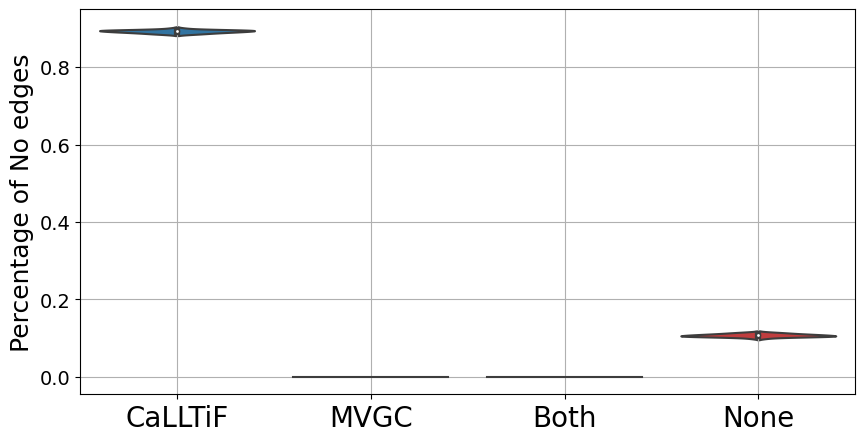

In [72]:
labels = ['CaLLTiF','MVGC','Both', 'None']
plt.figure(figsize = (10,5))
violin_parts = sns.violinplot([np.array(num_correct_edges_only_in_calltif)/total_number_of_missing_edges_in_macaque_full, np.array(num_correct_edges_only_in_mvgc)/total_number_of_missing_edges_in_macaque_full,np.array(num_correct_edges_in_both)/total_number_of_missing_edges_in_macaque_full,np.array(num_correct_edges_in_none)/total_number_of_missing_edges_in_macaque_full], scale='width')
plt.xticks(np.arange(0,4), labels = labels, rotation = 'horizontal',fontsize = 20)
h = plt.yticks(fontsize = 14)
plt.grid()
plt.ylabel('Percentage of No edges', fontsize = 18)


Text(0.5, 1.0, 'Orientation')

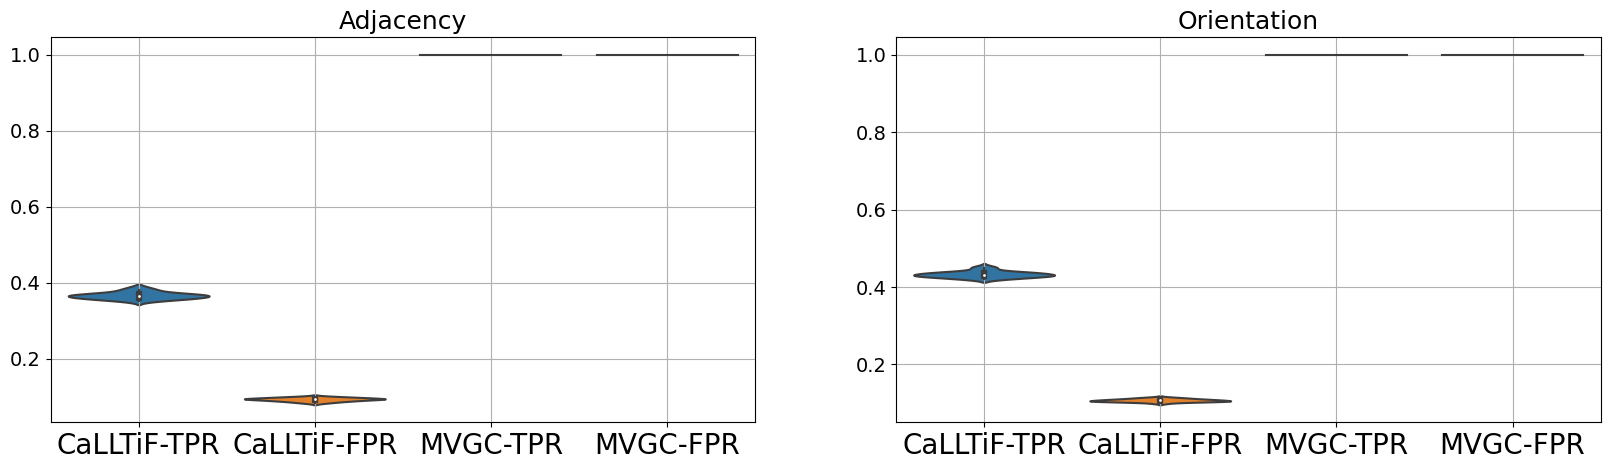

In [73]:
labels = ['CaLLTiF-TPR','CaLLTiF-FPR','MVGC-TPR','MVGC-FPR']
plt.figure(figsize = (20,5))

plt.subplot(1,2,1)

violin_parts = sns.violinplot([np.array(calltif_adj_TPR_all_rep_macaque_both_alpha)[:,0,CaLLTiF_best_alpha_ori_idx],np.array(calltif_adj_FPR_all_rep_macaque_both_alpha)[:,0,CaLLTiF_best_alpha_ori_idx], np.array(mvgc_adj_TPR_all_rep_macaque_both_alpha)[:,0,MVGC_best_alpha_ori_idx],np.array(mvgc_adj_FPR_all_rep_macaque_both_alpha)[:,0,MVGC_best_alpha_ori_idx] ], scale='width')
plt.xticks(np.arange(0,4), labels = labels, rotation = 'horizontal',fontsize = 20)
h = plt.yticks(fontsize = 14)
plt.grid()
plt.title('Adjacency', fontsize = 18)

plt.subplot(1,2,2)

violin_parts = sns.violinplot([np.array(calltif_ori_TPR_all_rep_macaque_both_alpha)[:,0,CaLLTiF_best_alpha_ori_idx],np.array(calltif_ori_FPR_all_rep_macaque_both_alpha)[:,0,CaLLTiF_best_alpha_ori_idx], np.array(mvgc_ori_TPR_all_rep_macaque_both_alpha)[:,0,MVGC_best_alpha_ori_idx],np.array(mvgc_ori_FPR_all_rep_macaque_both_alpha)[:,0,MVGC_best_alpha_ori_idx] ], scale='width')
plt.xticks(np.arange(0,4), labels = labels, rotation = 'horizontal',fontsize = 20)
h = plt.yticks(fontsize = 14)
plt.grid()
plt.title('Orientation', fontsize = 18)


## CaLLTiF applied on deconvolved data

### Execution Time

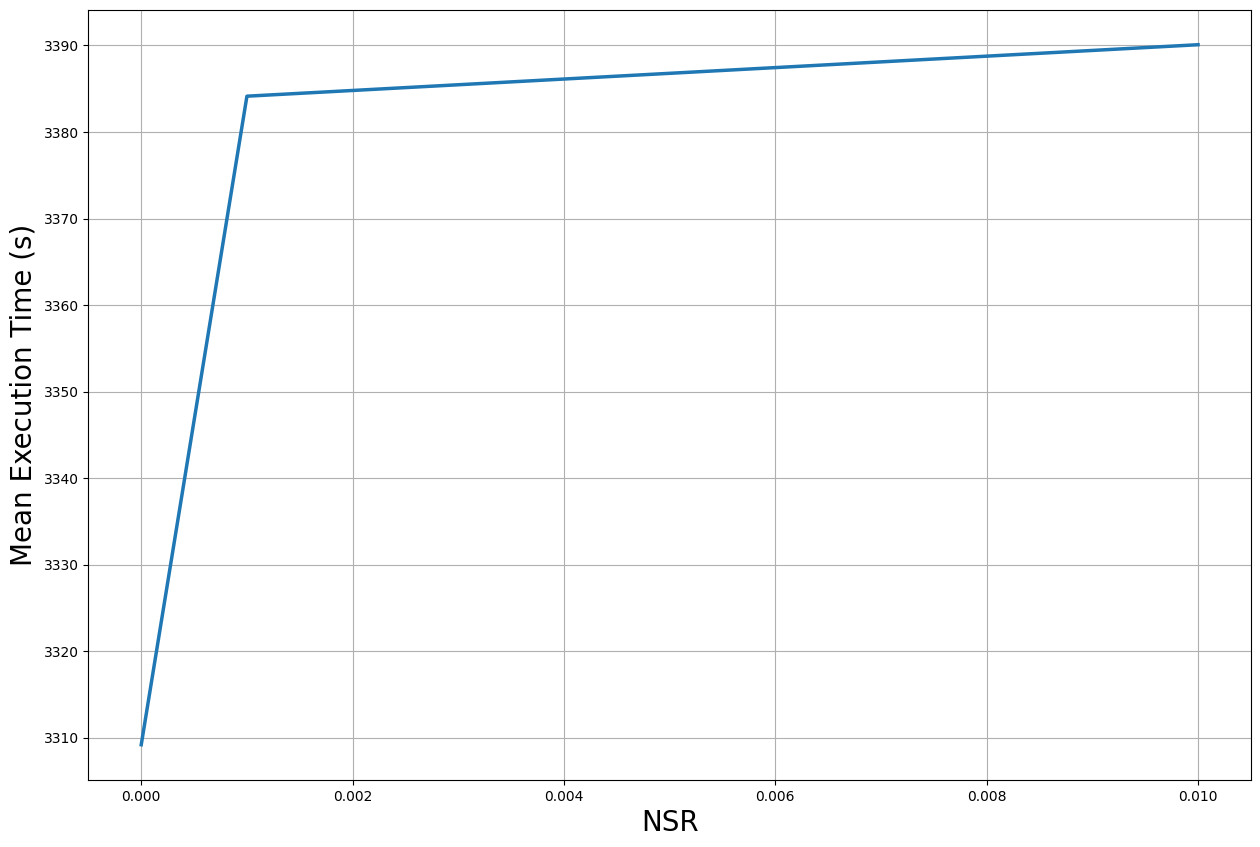

In [74]:
CaLLTiF_Mean_Exe_Time_Macaque_deconv = np.zeros((len(NSR_all), 1))
plt.figure(figsize = (15,10))

for sn in range(0, len(NSR_all)):
        temp = np.array(calltif_macaque_execution_time_deconv)[sn][0:num_rep_macaque]
        CaLLTiF_Mean_Exe_Time_Macaque_deconv[sn] = np.mean(temp)

plt.plot(NSR_all, CaLLTiF_Mean_Exe_Time_Macaque_deconv, linewidth = 2.5)
plt.xlabel('NSR', fontsize = 20)
plt.ylabel('Mean Execution Time (s)', fontsize = 20)
plt.grid()

### Mixed_PCMCI: with zero lag


In [75]:
mixed_pcmci_adj_TPR_all_rep_macaque_deconvolved = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]
mixed_pcmci_adj_FPR_all_rep_macaque_deconvolved  = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]
mixed_pcmci_adj_Recall_all_rep_macaque_deconvolved  = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]
mixed_pcmci_adj_Precision_all_rep_macaque_deconvolved = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]
mixed_pcmci_adj_F1_score_all_rep_macaque_deconvolved  = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]

mixed_pcmci_ori_TPR_all_rep_macaque_deconvolved  = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]
mixed_pcmci_ori_FPR_all_rep_macaque_deconvolved  = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]
mixed_pcmci_ori_Recall_all_rep_macaque_deconvolved  = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]
mixed_pcmci_ori_Precision_all_rep_macaque_deconvolved  = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]
mixed_pcmci_ori_F1_score_all_rep_macaque_deconvolved  = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]

macaque_ground_truth = ground_truth_graph_matrix_macaques_full

for r in range(0,num_rep_macaque):
    for sn in range(0, len(NSR_all)):

            PAG = np.array(calltif_link_matrix_all_macaque_deconv[r][sn])

            summary_graph, estimated_adjacency_binary_matrix, estimated_orientation_binary_matrix = summarize_across_all_lags_v1(PAG)
            adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = find_tpr_fpr_all_lags(macaque_ground_truth, estimated_adjacency_binary_matrix, estimated_orientation_binary_matrix)
            
            mixed_pcmci_adj_TPR_all_rep_macaque_deconvolved[r][sn]= adjacency_TPR
            mixed_pcmci_adj_FPR_all_rep_macaque_deconvolved[r][sn]  = adjacency_FPR
            mixed_pcmci_adj_Recall_all_rep_macaque_deconvolved[r][sn] = adjacency_Recall
            mixed_pcmci_adj_Precision_all_rep_macaque_deconvolved[r][sn]= adjacency_Precision
            mixed_pcmci_adj_F1_score_all_rep_macaque_deconvolved[r][sn] = adjacency_F1_score

            mixed_pcmci_ori_TPR_all_rep_macaque_deconvolved[r][sn] = orientation_TPR
            mixed_pcmci_ori_FPR_all_rep_macaque_deconvolved[r][sn]= orientation_FPR
            mixed_pcmci_ori_Recall_all_rep_macaque_deconvolved[r][sn] = orientation_Recall
            mixed_pcmci_ori_Precision_all_rep_macaque_deconvolved[r][sn]  = orientation_Precision
            mixed_pcmci_ori_F1_score_all_rep_macaque_deconvolved[r][sn]= orientation_F1_score


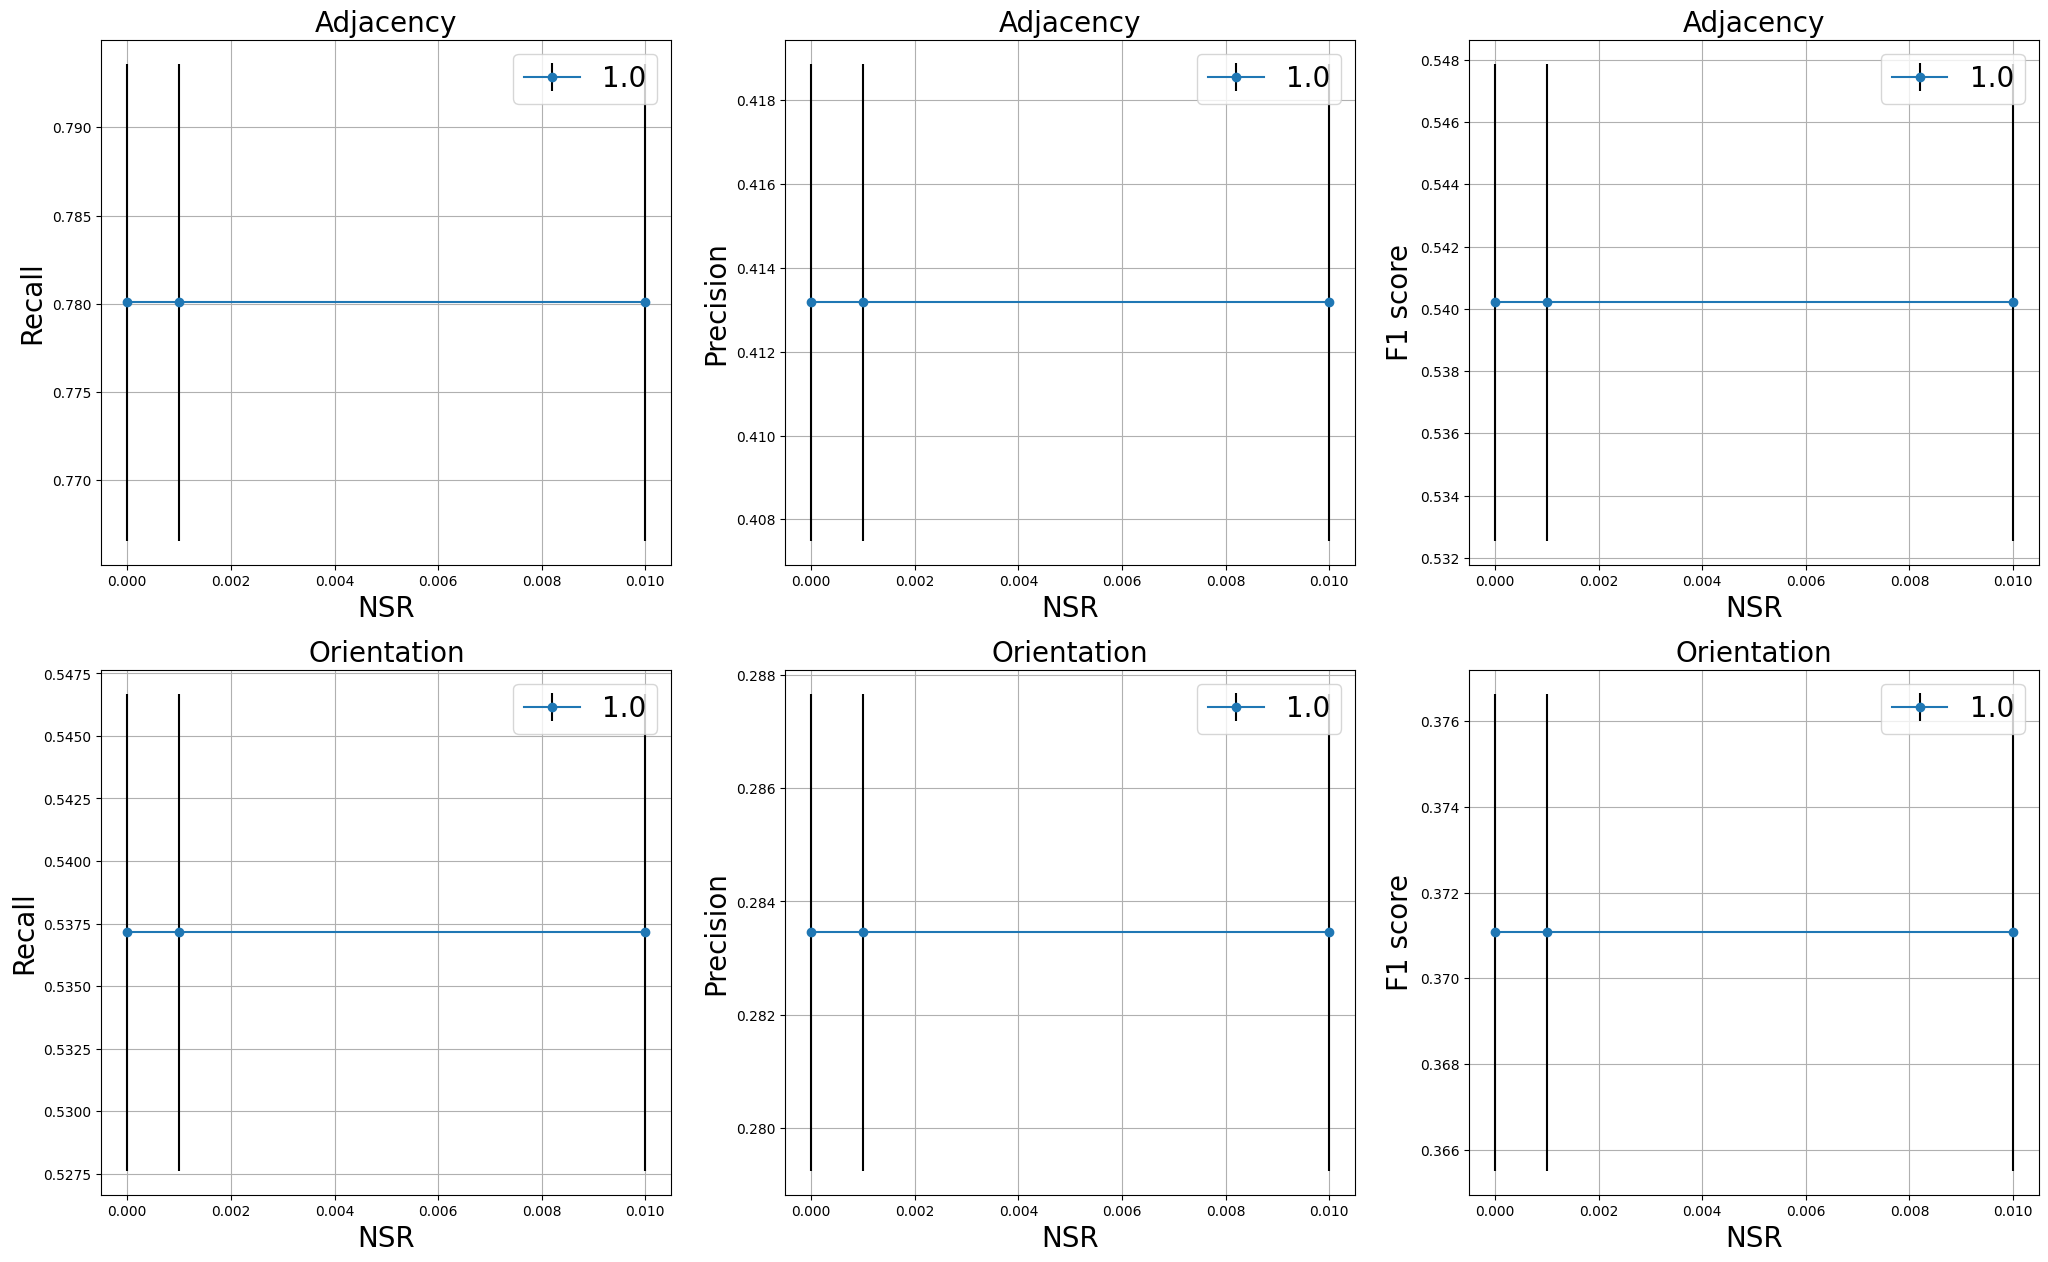

In [76]:
plt.figure(figsize = (25, 15))

mixed_pcmci_adj_recall_mean_macaque_deconvolved = np.zeros_like(NSR_all)
mixed_pcmci_adj_recall_std_macaque_deconvolved = np.zeros_like(NSR_all)
mixed_pcmci_adj_recall_median_macaque_deconvolved = np.zeros_like(NSR_all)

mixed_pcmci_adj_precision_mean_macaque_deconvolved = np.zeros_like(NSR_all) 
mixed_pcmci_adj_precision_std_macaque_deconvolved = np.zeros_like(NSR_all)
mixed_pcmci_adj_precision_median_macaque_deconvolved = np.zeros_like(NSR_all) 

mixed_pcmci_adj_F1_score_mean_macaque_deconvolved = np.zeros_like(NSR_all) 
mixed_pcmci_adj_F1_score_std_macaque_deconvolved = np.zeros_like(NSR_all)
mixed_pcmci_adj_F1_score_median_macaque_deconvolved = np.zeros_like(NSR_all) 

mixed_pcmci_ori_recall_mean_macaque_deconvolved = np.zeros_like(NSR_all)
mixed_pcmci_ori_recall_std_macaque_deconvolved = np.zeros_like(NSR_all)
mixed_pcmci_ori_recall_median_macaque_deconvolved = np.zeros_like(NSR_all)

mixed_pcmci_ori_precision_mean_macaque_deconvolved = np.zeros_like(NSR_all)
mixed_pcmci_ori_precision_std_macaque_deconvolved = np.zeros_like(NSR_all)
mixed_pcmci_ori_precision_median_macaque_deconvolved = np.zeros_like(NSR_all)

mixed_pcmci_ori_F1_score_mean_macaque_deconvolved = np.zeros_like(NSR_all)
mixed_pcmci_ori_F1_score_std_macaque_deconvolved =np.zeros_like(NSR_all)
mixed_pcmci_ori_F1_score_median_macaque_deconvolved = np.zeros_like(NSR_all)

for a in range(0,len(NSR_all)):

    mixed_pcmci_adj_recall_mean_macaque_deconvolved[a] = np.mean(np.array(mixed_pcmci_adj_Recall_all_rep_macaque_deconvolved)[:,a])
    mixed_pcmci_adj_recall_std_macaque_deconvolved[a] = np.std(np.array(mixed_pcmci_adj_Recall_all_rep_macaque_deconvolved)[:,a])
    mixed_pcmci_adj_recall_median_macaque_deconvolved[a] = np.median(np.array(mixed_pcmci_adj_Recall_all_rep_macaque_deconvolved)[:,a])


    mixed_pcmci_adj_precision_mean_macaque_deconvolved[a] = np.mean(np.array(mixed_pcmci_adj_Precision_all_rep_macaque_deconvolved)[:,a])
    mixed_pcmci_adj_precision_std_macaque_deconvolved[a] = np.std(np.array(mixed_pcmci_adj_Precision_all_rep_macaque_deconvolved)[:,a])
    mixed_pcmci_adj_precision_median_macaque_deconvolved[a] = np.median(np.array(mixed_pcmci_adj_Precision_all_rep_macaque_deconvolved)[:,a])


    mixed_pcmci_adj_F1_score_mean_macaque_deconvolved[a] = np.mean(np.array(mixed_pcmci_adj_F1_score_all_rep_macaque_deconvolved)[:,a])
    mixed_pcmci_adj_F1_score_std_macaque_deconvolved[a] = np.std(np.array(mixed_pcmci_adj_F1_score_all_rep_macaque_deconvolved)[:,a])
    mixed_pcmci_adj_F1_score_median_macaque_deconvolved[a] = np.median(np.array(mixed_pcmci_adj_F1_score_all_rep_macaque_deconvolved)[:,a])


    mixed_pcmci_ori_recall_mean_macaque_deconvolved[a] = np.mean(np.array(mixed_pcmci_ori_Recall_all_rep_macaque_deconvolved)[:,a])
    mixed_pcmci_ori_recall_std_macaque_deconvolved[a] = np.std(np.array(mixed_pcmci_ori_Recall_all_rep_macaque_deconvolved)[:,a])
    mixed_pcmci_ori_recall_median_macaque_deconvolved[a] = np.median(np.array(mixed_pcmci_ori_Recall_all_rep_macaque_deconvolved)[:,a])


    mixed_pcmci_ori_precision_mean_macaque_deconvolved[a] = np.mean(np.array(mixed_pcmci_ori_Precision_all_rep_macaque_deconvolved)[:,a])
    mixed_pcmci_ori_precision_std_macaque_deconvolved[a] = np.std(np.array(mixed_pcmci_ori_Precision_all_rep_macaque_deconvolved)[:,a])
    mixed_pcmci_ori_precision_median_macaque_deconvolved[a] = np.median(np.array(mixed_pcmci_ori_Precision_all_rep_macaque_deconvolved)[:,a])


    mixed_pcmci_ori_F1_score_mean_macaque_deconvolved[a] = np.mean(np.array(mixed_pcmci_ori_F1_score_all_rep_macaque_deconvolved)[:,a])
    mixed_pcmci_ori_F1_score_std_macaque_deconvolved[a] = np.std(np.array(mixed_pcmci_ori_F1_score_all_rep_macaque_deconvolved)[:,a])
    mixed_pcmci_ori_F1_score_median_macaque_deconvolved[a] = np.median(np.array(mixed_pcmci_ori_F1_score_all_rep_macaque_deconvolved)[:,a])

    mixed_pcmci_best_snr_adj_mean_deconvolved= NSR_all[np.argmax(mixed_pcmci_adj_F1_score_mean_macaque_deconvolved)]
    mixed_pcmci_best_snr_adj_median_deconvolved = NSR_all[np.argmax(mixed_pcmci_adj_F1_score_median_macaque_deconvolved)]
    mixed_pcmci_best_snr_ori_mean_deconvolved = NSR_all[np.argmax(mixed_pcmci_ori_F1_score_mean_macaque_deconvolved)]
    mixed_pcmci_best_snr_ori_median_deconvolved = NSR_all[np.argmax(mixed_pcmci_ori_F1_score_median_macaque_deconvolved)]

plt.subplot(2,3,1)
plt.errorbar(NSR_all, mixed_pcmci_adj_recall_mean_macaque_deconvolved, mixed_pcmci_adj_recall_std_macaque_deconvolved, ecolor = 'black', fmt = 'o-')
plt.xlabel('NSR', fontsize = 20)
plt.ylabel('Recall', fontsize = 20)
plt.title('Adjacency', fontsize = 20)
plt.grid()
plt.legend(pc_alpha,fontsize = 20)


plt.subplot(2,3,2)
plt.errorbar(NSR_all, mixed_pcmci_adj_precision_mean_macaque_deconvolved, mixed_pcmci_adj_precision_std_macaque_deconvolved, ecolor = 'black', fmt = 'o-')
plt.xlabel('NSR', fontsize = 20)
plt.ylabel('Precision', fontsize = 20)
plt.title('Adjacency', fontsize = 20)
plt.grid()
plt.legend(pc_alpha,fontsize = 20)

plt.subplot(2,3,3)
plt.errorbar(NSR_all, mixed_pcmci_adj_F1_score_mean_macaque_deconvolved, mixed_pcmci_adj_F1_score_std_macaque_deconvolved, ecolor = 'black', fmt = 'o-')
plt.xlabel('NSR', fontsize = 20)
plt.ylabel('F1 score', fontsize = 20)
plt.title('Adjacency', fontsize = 20)
plt.grid()
plt.legend(pc_alpha,fontsize = 20)


# Recall, Precision, and F1 score vs alpha for orientation
plt.subplot(2,3,4)
plt.errorbar(NSR_all, mixed_pcmci_ori_recall_mean_macaque_deconvolved, mixed_pcmci_ori_recall_std_macaque_deconvolved, ecolor = 'black', fmt = 'o-')
plt.xlabel('NSR', fontsize = 20)
plt.ylabel('Recall', fontsize = 20)
plt.title('Orientation', fontsize = 20)
plt.grid()
plt.legend(pc_alpha,fontsize = 20)

plt.subplot(2,3,5)
plt.errorbar(NSR_all, mixed_pcmci_ori_precision_mean_macaque_deconvolved, mixed_pcmci_ori_precision_std_macaque_deconvolved, ecolor = 'black', fmt = 'o-')
plt.xlabel('NSR', fontsize = 20)
plt.ylabel('Precision', fontsize = 20)
plt.title('Orientation', fontsize = 20)
plt.grid()
plt.legend(pc_alpha,fontsize = 20)

plt.subplot(2,3,6)
plt.errorbar(NSR_all, mixed_pcmci_ori_F1_score_mean_macaque_deconvolved, mixed_pcmci_ori_F1_score_std_macaque_deconvolved, ecolor = 'black', fmt = 'o-')
plt.xlabel('NSR', fontsize = 20)
plt.ylabel('F1 score', fontsize = 20)
plt.title('Orientation', fontsize = 20)
plt.grid()
plt.legend(pc_alpha,fontsize = 20)

### PCMCI: without zero lag

In [77]:
pcmci_adj_TPR_all_rep_macaque_deconvolved = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]
pcmci_adj_FPR_all_rep_macaque_deconvolved  = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]
pcmci_adj_Recall_all_rep_macaque_deconvolved  = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]
pcmci_adj_Precision_all_rep_macaque_deconvolved = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]
pcmci_adj_F1_score_all_rep_macaque_deconvolved  = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]

pcmci_ori_TPR_all_rep_macaque_deconvolved  = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]
pcmci_ori_FPR_all_rep_macaque_deconvolved  = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]
pcmci_ori_Recall_all_rep_macaque_deconvolved  = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]
pcmci_ori_Precision_all_rep_macaque_deconvolved  = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]
pcmci_ori_F1_score_all_rep_macaque_deconvolved  = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]

macaque_ground_truth = ground_truth_graph_matrix_macaques_full

for r in range(0,num_rep_macaque):
    for sn in range(0, len(NSR_all)):

            PAG = np.array(calltif_link_matrix_all_macaque_deconv[r][sn])

            estimated_non_zero_lags_combined = summarize_across_nonzero_lags(PAG)
            adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = find_tpr_fpr_nonzero_lags(macaque_ground_truth, estimated_non_zero_lags_combined)

            pcmci_adj_TPR_all_rep_macaque_deconvolved[r][sn]= adjacency_TPR
            pcmci_adj_FPR_all_rep_macaque_deconvolved[r][sn]  = adjacency_FPR
            pcmci_adj_Recall_all_rep_macaque_deconvolved[r][sn] = adjacency_Recall
            pcmci_adj_Precision_all_rep_macaque_deconvolved[r][sn]= adjacency_Precision
            pcmci_adj_F1_score_all_rep_macaque_deconvolved[r][sn] = adjacency_F1_score

            pcmci_ori_TPR_all_rep_macaque_deconvolved[r][sn] = orientation_TPR
            pcmci_ori_FPR_all_rep_macaque_deconvolved[r][sn]= orientation_FPR
            pcmci_ori_Recall_all_rep_macaque_deconvolved[r][sn] = orientation_Recall
            pcmci_ori_Precision_all_rep_macaque_deconvolved[r][sn]  = orientation_Precision
            pcmci_ori_F1_score_all_rep_macaque_deconvolved[r][sn]= orientation_F1_score


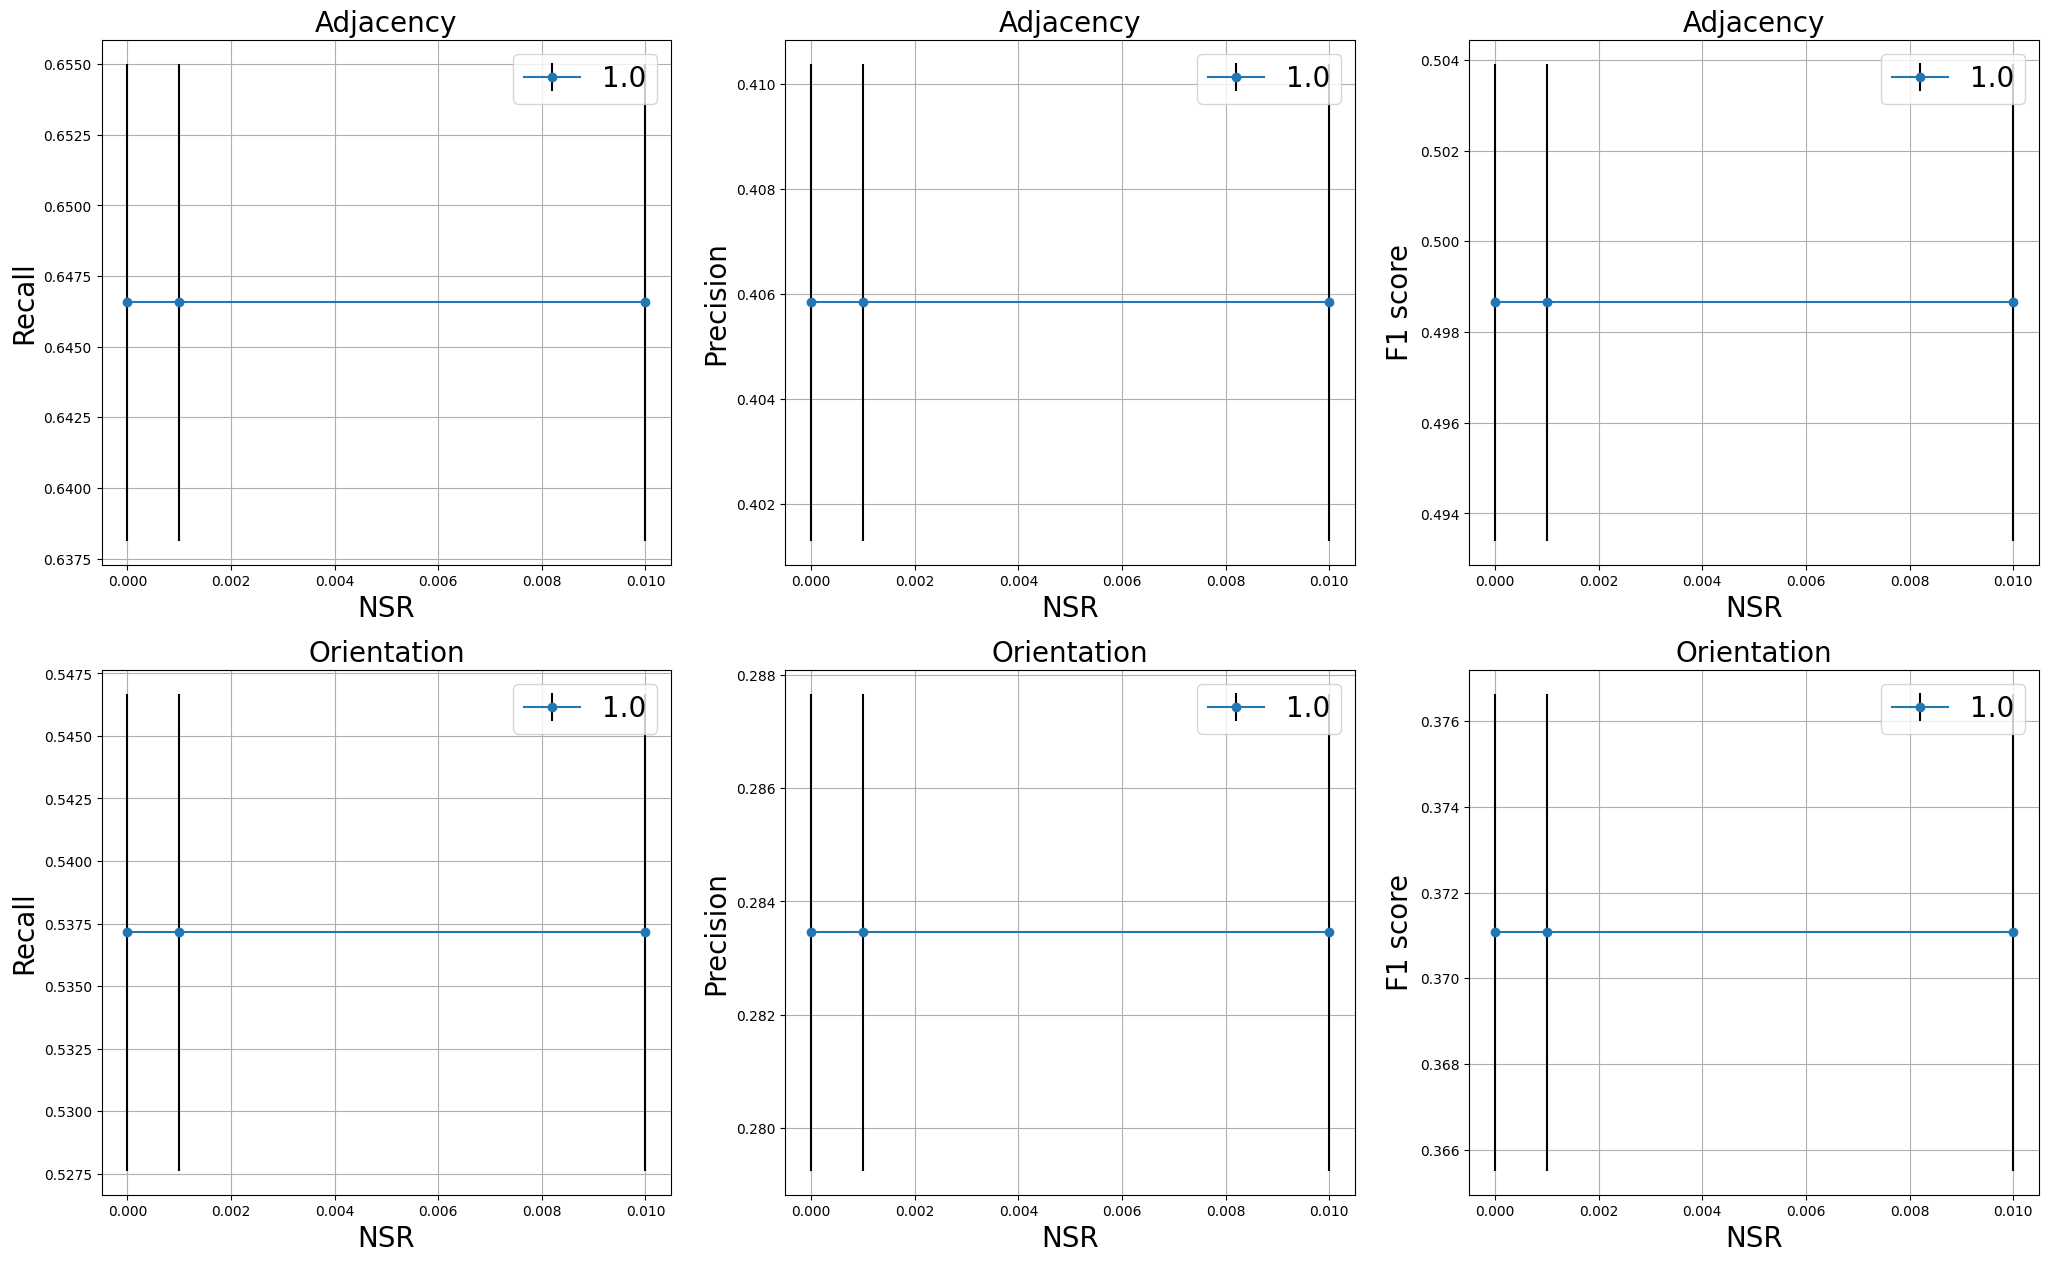

In [78]:
plt.figure(figsize = (25, 15))

pcmci_adj_recall_mean_macaque_deconvolved = np.zeros_like(NSR_all)
pcmci_adj_recall_std_macaque_deconvolved = np.zeros_like(NSR_all)
pcmci_adj_recall_median_macaque_deconvolved = np.zeros_like(NSR_all)

pcmci_adj_precision_mean_macaque_deconvolved = np.zeros_like(NSR_all) 
pcmci_adj_precision_std_macaque_deconvolved = np.zeros_like(NSR_all)
pcmci_adj_precision_median_macaque_deconvolved = np.zeros_like(NSR_all) 

pcmci_adj_F1_score_mean_macaque_deconvolved = np.zeros_like(NSR_all) 
pcmci_adj_F1_score_std_macaque_deconvolved = np.zeros_like(NSR_all)
pcmci_adj_F1_score_median_macaque_deconvolved = np.zeros_like(NSR_all) 

pcmci_ori_recall_mean_macaque_deconvolved = np.zeros_like(NSR_all)
pcmci_ori_recall_std_macaque_deconvolved = np.zeros_like(NSR_all)
pcmci_ori_recall_median_macaque_deconvolved = np.zeros_like(NSR_all)

pcmci_ori_precision_mean_macaque_deconvolved = np.zeros_like(NSR_all)
pcmci_ori_precision_std_macaque_deconvolved = np.zeros_like(NSR_all)
pcmci_ori_precision_median_macaque_deconvolved = np.zeros_like(NSR_all)

pcmci_ori_F1_score_mean_macaque_deconvolved = np.zeros_like(NSR_all)
pcmci_ori_F1_score_std_macaque_deconvolved =np.zeros_like(NSR_all)
pcmci_ori_F1_score_median_macaque_deconvolved = np.zeros_like(NSR_all)


for a in range(0,len(NSR_all)):

    pcmci_adj_recall_mean_macaque_deconvolved[a] = np.mean(np.array(pcmci_adj_Recall_all_rep_macaque_deconvolved)[:,a])
    pcmci_adj_recall_std_macaque_deconvolved[a] = np.std(np.array(pcmci_adj_Recall_all_rep_macaque_deconvolved)[:,a])
    pcmci_adj_recall_median_macaque_deconvolved[a] = np.median(np.array(pcmci_adj_Recall_all_rep_macaque_deconvolved)[:,a])


    pcmci_adj_precision_mean_macaque_deconvolved[a] = np.mean(np.array(pcmci_adj_Precision_all_rep_macaque_deconvolved)[:,a])
    pcmci_adj_precision_std_macaque_deconvolved[a] = np.std(np.array(pcmci_adj_Precision_all_rep_macaque_deconvolved)[:,a])
    pcmci_adj_precision_median_macaque_deconvolved[a] = np.median(np.array(pcmci_adj_Precision_all_rep_macaque_deconvolved)[:,a])


    pcmci_adj_F1_score_mean_macaque_deconvolved[a] = np.mean(np.array(pcmci_adj_F1_score_all_rep_macaque_deconvolved)[:,a])
    pcmci_adj_F1_score_std_macaque_deconvolved[a] = np.std(np.array(pcmci_adj_F1_score_all_rep_macaque_deconvolved)[:,a])
    pcmci_adj_F1_score_median_macaque_deconvolved[a] = np.median(np.array(pcmci_adj_F1_score_all_rep_macaque_deconvolved)[:,a])


    pcmci_ori_recall_mean_macaque_deconvolved[a] = np.mean(np.array(pcmci_ori_Recall_all_rep_macaque_deconvolved)[:,a])
    pcmci_ori_recall_std_macaque_deconvolved[a] = np.std(np.array(pcmci_ori_Recall_all_rep_macaque_deconvolved)[:,a])
    pcmci_ori_recall_median_macaque_deconvolved[a] = np.median(np.array(pcmci_ori_Recall_all_rep_macaque_deconvolved)[:,a])


    pcmci_ori_precision_mean_macaque_deconvolved[a] = np.mean(np.array(pcmci_ori_Precision_all_rep_macaque_deconvolved)[:,a])
    pcmci_ori_precision_std_macaque_deconvolved[a] = np.std(np.array(pcmci_ori_Precision_all_rep_macaque_deconvolved)[:,a])
    pcmci_ori_precision_median_macaque_deconvolved[a] = np.median(np.array(pcmci_ori_Precision_all_rep_macaque_deconvolved)[:,a])


    pcmci_ori_F1_score_mean_macaque_deconvolved[a] = np.mean(np.array(pcmci_ori_F1_score_all_rep_macaque_deconvolved)[:,a])
    pcmci_ori_F1_score_std_macaque_deconvolved[a] = np.std(np.array(pcmci_ori_F1_score_all_rep_macaque_deconvolved)[:,a])
    pcmci_ori_F1_score_median_macaque_deconvolved[a] = np.median(np.array(pcmci_ori_F1_score_all_rep_macaque_deconvolved)[:,a])

    pcmci_best_snr_adj_mean_deconvolved= NSR_all[np.argmax(pcmci_adj_F1_score_mean_macaque_deconvolved)]
    pcmci_best_snr_adj_median_deconvolved = NSR_all[np.argmax(pcmci_adj_F1_score_median_macaque_deconvolved)]
    pcmci_best_snr_ori_mean_deconvolved = NSR_all[np.argmax(pcmci_ori_F1_score_mean_macaque_deconvolved)]
    pcmci_best_snr_ori_median_deconvolved = NSR_all[np.argmax(pcmci_ori_F1_score_median_macaque_deconvolved)]

plt.subplot(2,3,1)
plt.errorbar(NSR_all, pcmci_adj_recall_mean_macaque_deconvolved, pcmci_adj_recall_std_macaque_deconvolved, ecolor = 'black', fmt = 'o-')
plt.xlabel('NSR', fontsize = 20)
plt.ylabel('Recall', fontsize = 20)
plt.title('Adjacency', fontsize = 20)
plt.grid()
plt.legend(pc_alpha,fontsize = 20)


plt.subplot(2,3,2)
plt.errorbar(NSR_all, pcmci_adj_precision_mean_macaque_deconvolved, pcmci_adj_precision_std_macaque_deconvolved, ecolor = 'black', fmt = 'o-')
plt.xlabel('NSR', fontsize = 20)
plt.ylabel('Precision', fontsize = 20)
plt.title('Adjacency', fontsize = 20)
plt.grid()
plt.legend(pc_alpha,fontsize = 20)

plt.subplot(2,3,3)
plt.errorbar(NSR_all, pcmci_adj_F1_score_mean_macaque_deconvolved, pcmci_adj_F1_score_std_macaque_deconvolved, ecolor = 'black', fmt = 'o-')
plt.xlabel('NSR', fontsize = 20)
plt.ylabel('F1 score', fontsize = 20)
plt.title('Adjacency', fontsize = 20)
plt.grid()
plt.legend(pc_alpha,fontsize = 20)

# Recall, Precision, and F1 score vs alpha for orientation
plt.subplot(2,3,4)
plt.errorbar(NSR_all, pcmci_ori_recall_mean_macaque_deconvolved, pcmci_ori_recall_std_macaque_deconvolved, ecolor = 'black', fmt = 'o-')
plt.xlabel('NSR', fontsize = 20)
plt.ylabel('Recall', fontsize = 20)
plt.title('Orientation', fontsize = 20)
plt.grid()
plt.legend(pc_alpha,fontsize = 20) 

plt.subplot(2,3,5)
plt.errorbar(NSR_all, pcmci_ori_precision_mean_macaque_deconvolved, pcmci_ori_precision_std_macaque_deconvolved, ecolor = 'black', fmt = 'o-')
plt.xlabel('NSR', fontsize = 20)
plt.ylabel('Precision', fontsize = 20)
plt.title('Orientation', fontsize = 20)
plt.grid()
plt.legend(pc_alpha,fontsize = 20)

plt.subplot(2,3,6)
plt.errorbar(NSR_all, pcmci_ori_F1_score_mean_macaque_deconvolved, pcmci_ori_F1_score_std_macaque_deconvolved, ecolor = 'black', fmt = 'o-')
plt.xlabel('NSR', fontsize = 20)
plt.ylabel('F1 score', fontsize = 20)
plt.title('Orientation', fontsize = 20)
plt.grid()
plt.legend(pc_alpha,fontsize = 20)

### CaLLTiF: with zero lags (zero lags are affecting both adjacency and orientation)

In [79]:
calltif_adj_TPR_all_rep_macaque_deconvolved = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]
calltif_adj_FPR_all_rep_macaque_deconvolved  = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]
calltif_adj_Recall_all_rep_macaque_deconvolved  = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]
calltif_adj_Precision_all_rep_macaque_deconvolved = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]
calltif_adj_F1_score_all_rep_macaque_deconvolved  = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]

calltif_ori_TPR_all_rep_macaque_deconvolved  = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]
calltif_ori_FPR_all_rep_macaque_deconvolved  = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]
calltif_ori_Recall_all_rep_macaque_deconvolved  = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]
calltif_ori_Precision_all_rep_macaque_deconvolved  = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]
calltif_ori_F1_score_all_rep_macaque_deconvolved  = [['' for t in range(0, len(NSR_all))] for j in range(0,num_rep_macaque)]

macaque_ground_truth = ground_truth_graph_matrix_macaques_full

for r in range(0,num_rep_macaque):
    for sn in range(0, len(NSR_all)):

            PAG = np.array(calltif_link_matrix_all_macaque_deconv[r][sn])

            summary_graph, estimated_adjacency_binary_matrix, estimated_orientation_binary_matrix = summarize_across_all_lags_v2(PAG)
            adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = find_tpr_fpr_all_lags(macaque_ground_truth, estimated_adjacency_binary_matrix, estimated_orientation_binary_matrix)
            
            calltif_adj_TPR_all_rep_macaque_deconvolved[r][sn]= adjacency_TPR
            calltif_adj_FPR_all_rep_macaque_deconvolved[r][sn]  = adjacency_FPR
            calltif_adj_Recall_all_rep_macaque_deconvolved[r][sn] = adjacency_Recall
            calltif_adj_Precision_all_rep_macaque_deconvolved[r][sn]= adjacency_Precision
            calltif_adj_F1_score_all_rep_macaque_deconvolved[r][sn] = adjacency_F1_score

            calltif_ori_TPR_all_rep_macaque_deconvolved[r][sn] = orientation_TPR
            calltif_ori_FPR_all_rep_macaque_deconvolved[r][sn]= orientation_FPR
            calltif_ori_Recall_all_rep_macaque_deconvolved[r][sn] = orientation_Recall
            calltif_ori_Precision_all_rep_macaque_deconvolved[r][sn]  = orientation_Precision
            calltif_ori_F1_score_all_rep_macaque_deconvolved[r][sn]= orientation_F1_score


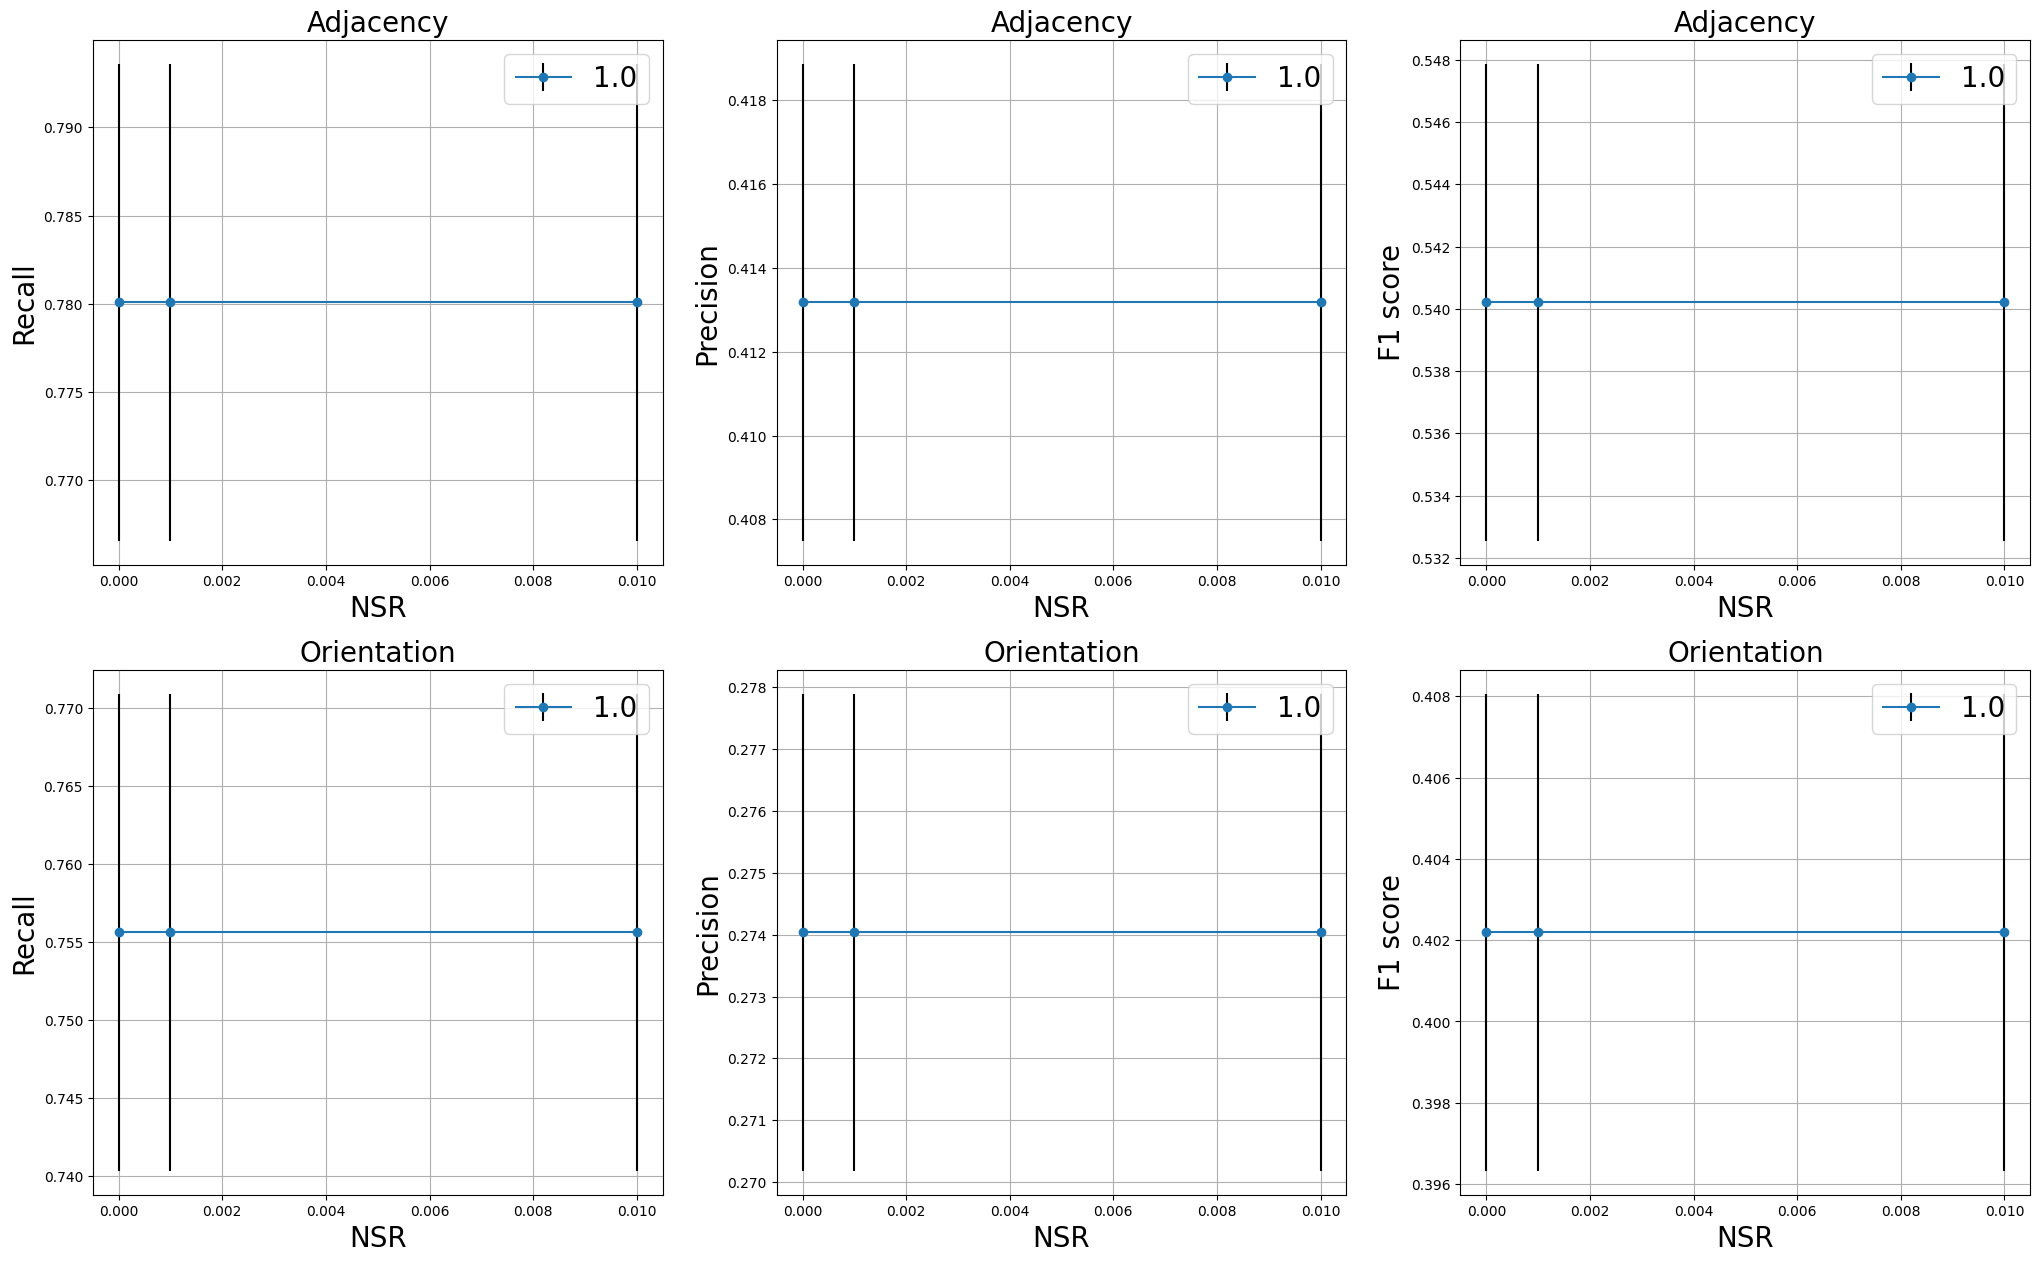

In [80]:
plt.figure(figsize = (25, 15))

calltif_adj_recall_mean_macaque_deconvolved = np.zeros_like(NSR_all)
calltif_adj_recall_std_macaque_deconvolved = np.zeros_like(NSR_all)
calltif_adj_recall_median_macaque_deconvolved = np.zeros_like(NSR_all)

calltif_adj_precision_mean_macaque_deconvolved = np.zeros_like(NSR_all) 
calltif_adj_precision_std_macaque_deconvolved = np.zeros_like(NSR_all)
calltif_adj_precision_median_macaque_deconvolved = np.zeros_like(NSR_all) 

calltif_adj_F1_score_mean_macaque_deconvolved = np.zeros_like(NSR_all) 
calltif_adj_F1_score_std_macaque_deconvolved = np.zeros_like(NSR_all)
calltif_adj_F1_score_median_macaque_deconvolved = np.zeros_like(NSR_all) 

calltif_ori_recall_mean_macaque_deconvolved = np.zeros_like(NSR_all)
calltif_ori_recall_std_macaque_deconvolved = np.zeros_like(NSR_all)
calltif_ori_recall_median_macaque_deconvolved = np.zeros_like(NSR_all)

calltif_ori_precision_mean_macaque_deconvolved = np.zeros_like(NSR_all)
calltif_ori_precision_std_macaque_deconvolved = np.zeros_like(NSR_all)
calltif_ori_precision_median_macaque_deconvolved = np.zeros_like(NSR_all)

calltif_ori_F1_score_mean_macaque_deconvolved = np.zeros_like(NSR_all)
calltif_ori_F1_score_std_macaque_deconvolved =np.zeros_like(NSR_all)
calltif_ori_F1_score_median_macaque_deconvolved = np.zeros_like(NSR_all)

for a in range(0,len(NSR_all)):

    calltif_adj_recall_mean_macaque_deconvolved[a] = np.mean(np.array(calltif_adj_Recall_all_rep_macaque_deconvolved)[:,a])
    calltif_adj_recall_std_macaque_deconvolved[a] = np.std(np.array(calltif_adj_Recall_all_rep_macaque_deconvolved)[:,a])
    calltif_adj_recall_median_macaque_deconvolved[a] = np.median(np.array(calltif_adj_Recall_all_rep_macaque_deconvolved)[:,a])


    calltif_adj_precision_mean_macaque_deconvolved[a] = np.mean(np.array(calltif_adj_Precision_all_rep_macaque_deconvolved)[:,a])
    calltif_adj_precision_std_macaque_deconvolved[a] = np.std(np.array(calltif_adj_Precision_all_rep_macaque_deconvolved)[:,a])
    calltif_adj_precision_median_macaque_deconvolved[a] = np.median(np.array(calltif_adj_Precision_all_rep_macaque_deconvolved)[:,a])


    calltif_adj_F1_score_mean_macaque_deconvolved[a] = np.mean(np.array(calltif_adj_F1_score_all_rep_macaque_deconvolved)[:,a])
    calltif_adj_F1_score_std_macaque_deconvolved[a] = np.std(np.array(calltif_adj_F1_score_all_rep_macaque_deconvolved)[:,a])
    calltif_adj_F1_score_median_macaque_deconvolved[a] = np.median(np.array(calltif_adj_F1_score_all_rep_macaque_deconvolved)[:,a])


    calltif_ori_recall_mean_macaque_deconvolved[a] = np.mean(np.array(calltif_ori_Recall_all_rep_macaque_deconvolved)[:,a])
    calltif_ori_recall_std_macaque_deconvolved[a] = np.std(np.array(calltif_ori_Recall_all_rep_macaque_deconvolved)[:,a])
    calltif_ori_recall_median_macaque_deconvolved[a] = np.median(np.array(calltif_ori_Recall_all_rep_macaque_deconvolved)[:,a])


    calltif_ori_precision_mean_macaque_deconvolved[a] = np.mean(np.array(calltif_ori_Precision_all_rep_macaque_deconvolved)[:,a])
    calltif_ori_precision_std_macaque_deconvolved[a] = np.std(np.array(calltif_ori_Precision_all_rep_macaque_deconvolved)[:,a])
    calltif_ori_precision_median_macaque_deconvolved[a] = np.median(np.array(calltif_ori_Precision_all_rep_macaque_deconvolved)[:,a])


    calltif_ori_F1_score_mean_macaque_deconvolved[a] = np.mean(np.array(calltif_ori_F1_score_all_rep_macaque_deconvolved)[:,a])
    calltif_ori_F1_score_std_macaque_deconvolved[a] = np.std(np.array(calltif_ori_F1_score_all_rep_macaque_deconvolved)[:,a])
    calltif_ori_F1_score_median_macaque_deconvolved[a] = np.median(np.array(calltif_ori_F1_score_all_rep_macaque_deconvolved)[:,a])

    calltif_best_snr_adj_mean_deconvolved= NSR_all[np.argmax(calltif_adj_F1_score_mean_macaque_deconvolved)]
    calltif_best_snr_adj_median_deconvolved = NSR_all[np.argmax(calltif_adj_F1_score_median_macaque_deconvolved)]
    calltif_best_snr_ori_mean_deconvolved = NSR_all[np.argmax(calltif_ori_F1_score_mean_macaque_deconvolved)]
    calltif_best_snr_ori_median_deconvolved = NSR_all[np.argmax(calltif_ori_F1_score_median_macaque_deconvolved)]

plt.subplot(2,3,1)
plt.errorbar(NSR_all, calltif_adj_recall_mean_macaque_deconvolved, calltif_adj_recall_std_macaque_deconvolved, ecolor = 'black', fmt = 'o-')
plt.xlabel('NSR', fontsize = 20)
plt.ylabel('Recall', fontsize = 20)
plt.title('Adjacency', fontsize = 20)
plt.grid()
plt.legend(pc_alpha,fontsize = 20)


plt.subplot(2,3,2)
plt.errorbar(NSR_all, calltif_adj_precision_mean_macaque_deconvolved, calltif_adj_precision_std_macaque_deconvolved, ecolor = 'black', fmt = 'o-')
plt.xlabel('NSR', fontsize = 20)
plt.ylabel('Precision', fontsize = 20)
plt.title('Adjacency', fontsize = 20)
plt.grid()
plt.legend(pc_alpha,fontsize = 20)

plt.subplot(2,3,3)
plt.errorbar(NSR_all, calltif_adj_F1_score_mean_macaque_deconvolved, calltif_adj_F1_score_std_macaque_deconvolved, ecolor = 'black', fmt = 'o-')
plt.xlabel('NSR', fontsize = 20)
plt.ylabel('F1 score', fontsize = 20)
plt.title('Adjacency', fontsize = 20)
plt.grid()
plt.legend(pc_alpha,fontsize = 20)


# Recall, Precision, and F1 score vs alpha for orientation
plt.subplot(2,3,4)
plt.errorbar(NSR_all, calltif_ori_recall_mean_macaque_deconvolved, calltif_ori_recall_std_macaque_deconvolved, ecolor = 'black', fmt = 'o-')
plt.xlabel('NSR', fontsize = 20)
plt.ylabel('Recall', fontsize = 20)
plt.title('Orientation', fontsize = 20)
plt.grid()
plt.legend(pc_alpha,fontsize = 20)

plt.subplot(2,3,5)
plt.errorbar(NSR_all, calltif_ori_precision_mean_macaque_deconvolved, calltif_ori_precision_std_macaque_deconvolved, ecolor = 'black', fmt = 'o-')
plt.xlabel('NSR', fontsize = 20)
plt.ylabel('Precision', fontsize = 20)
plt.title('Orientation', fontsize = 20)
plt.grid()
plt.legend(pc_alpha,fontsize = 20)

plt.subplot(2,3,6)
plt.errorbar(NSR_all, calltif_ori_F1_score_mean_macaque_deconvolved, calltif_ori_F1_score_std_macaque_deconvolved, ecolor = 'black', fmt = 'o-')
plt.xlabel('NSR', fontsize = 20)
plt.ylabel('F1 score', fontsize = 20)
plt.title('Orientation', fontsize = 20)
plt.grid()
plt.legend(pc_alpha,fontsize = 20)

## Comparison between PCMCI and CaLLTiF performance on BOLD signals and deconvolved signals

In [81]:
# BOLD signal

#mixed-pcmci
mixed_pcmci_adj_F1_mean = np.median(np.array(mixed_pcmci_adj_F1_score_all_rep_macaque_both_alpha)[:,0,:], axis = 0)
mixed_pcmci_adj_F1_best_alpha = np.argmax(mixed_pcmci_adj_F1_mean)

mixed_pcmci_ori_F1_mean = np.median(np.array(mixed_pcmci_ori_F1_score_all_rep_macaque_both_alpha)[:,0,:], axis = 0)
mixed_pcmci_ori_F1_best_alpha = np.argmax(mixed_pcmci_ori_F1_mean)

mixed_pcmci_adj_F1_dist = np.array(mixed_pcmci_adj_F1_score_all_rep_macaque_both_alpha)[:,0,mixed_pcmci_adj_F1_best_alpha]
mixed_pcmci_ori_F1_dist = np.array(mixed_pcmci_ori_F1_score_all_rep_macaque_both_alpha)[:,0,mixed_pcmci_ori_F1_best_alpha]

#pcmci
pcmci_adj_F1_mean = np.median(np.array(pcmci_adj_F1_score_all_rep_macaque_both_alpha)[:,0,:], axis = 0)
pcmci_adj_F1_best_alpha = np.argmax(pcmci_adj_F1_mean)

pcmci_ori_F1_mean = np.median(np.array(pcmci_ori_F1_score_all_rep_macaque_both_alpha)[:,0,:], axis = 0)
pcmci_ori_F1_best_alpha = np.argmax(pcmci_ori_F1_mean)

pcmci_ori_F1_dist = np.array(pcmci_ori_F1_score_all_rep_macaque_both_alpha)[:,0,pcmci_ori_F1_best_alpha]
pcmci_adj_F1_dist = np.array(pcmci_adj_F1_score_all_rep_macaque_both_alpha)[:,0,pcmci_adj_F1_best_alpha]

# calltif
calltif_adj_F1_mean = np.median(np.array(calltif_adj_F1_score_all_rep_macaque_both_alpha)[:,0,:], axis = 0)
calltif_adj_F1_best_alpha = np.argmax(calltif_adj_F1_mean)

calltif_ori_F1_mean = np.median(np.array(calltif_ori_F1_score_all_rep_macaque_both_alpha)[:,0,:], axis = 0)
calltif_ori_F1_best_alpha = np.argmax(calltif_ori_F1_mean)

calltif_ori_F1_dist = np.array(calltif_ori_F1_score_all_rep_macaque_both_alpha)[:,0,calltif_ori_F1_best_alpha]
calltif_adj_F1_dist = np.array(calltif_adj_F1_score_all_rep_macaque_both_alpha)[:,0,calltif_adj_F1_best_alpha]

# deconvolved signal
# mixed-pcmci
mixed_pcmci_deconv_adj_F1_mean = np.median(np.array(mixed_pcmci_adj_F1_score_all_rep_macaque_deconvolved), axis = 0)
mixed_pcmci_deconv_adj_F1_best_nsr = np.argmax(mixed_pcmci_deconv_adj_F1_mean)

mixed_pcmci_deconv_ori_F1_mean = np.median(np.array(mixed_pcmci_ori_F1_score_all_rep_macaque_deconvolved), axis = 0)
mixed_pcmci_deconv_ori_F1_best_nsr = np.argmax(mixed_pcmci_deconv_ori_F1_mean)

mixed_pcmci_deconv_adj_F1_dist = np.array(mixed_pcmci_adj_F1_score_all_rep_macaque_deconvolved)[:,mixed_pcmci_deconv_adj_F1_best_nsr]
mixed_pcmci_deconv_ori_F1_dist = np.array(mixed_pcmci_ori_F1_score_all_rep_macaque_deconvolved)[:,mixed_pcmci_deconv_ori_F1_best_nsr]

# pcmci
pcmci_deconv_adj_F1_mean = np.median(np.array(pcmci_adj_F1_score_all_rep_macaque_deconvolved), axis = 0)
pcmci_deconv_adj_F1_best_nsr = np.argmax(pcmci_deconv_adj_F1_mean)

pcmci_deconv_ori_F1_mean = np.median(np.array(pcmci_ori_F1_score_all_rep_macaque_deconvolved), axis = 0)
pcmci_deconv_ori_F1_best_nsr = np.argmax(pcmci_deconv_ori_F1_mean)

pcmci_deconv_adj_F1_dist = np.array(pcmci_adj_F1_score_all_rep_macaque_deconvolved)[:,pcmci_deconv_adj_F1_best_nsr]
pcmci_deconv_ori_F1_dist = np.array(pcmci_ori_F1_score_all_rep_macaque_deconvolved)[:,pcmci_deconv_ori_F1_best_nsr]


# calltif
calltif_deconv_adj_F1_mean = np.median(np.array(calltif_adj_F1_score_all_rep_macaque_deconvolved), axis = 0)
calltif_deconv_adj_F1_best_nsr = np.argmax(calltif_deconv_adj_F1_mean)

calltif_deconv_ori_F1_mean = np.median(np.array(calltif_ori_F1_score_all_rep_macaque_deconvolved), axis = 0)
calltif_deconv_ori_F1_best_nsr = np.argmax(calltif_deconv_ori_F1_mean)

calltif_deconv_adj_F1_dist = np.array(calltif_adj_F1_score_all_rep_macaque_deconvolved)[:,calltif_deconv_adj_F1_best_nsr]
calltif_deconv_ori_F1_dist = np.array(calltif_ori_F1_score_all_rep_macaque_deconvolved)[:,calltif_deconv_ori_F1_best_nsr]


Text(0, 0.5, 'F1 score')

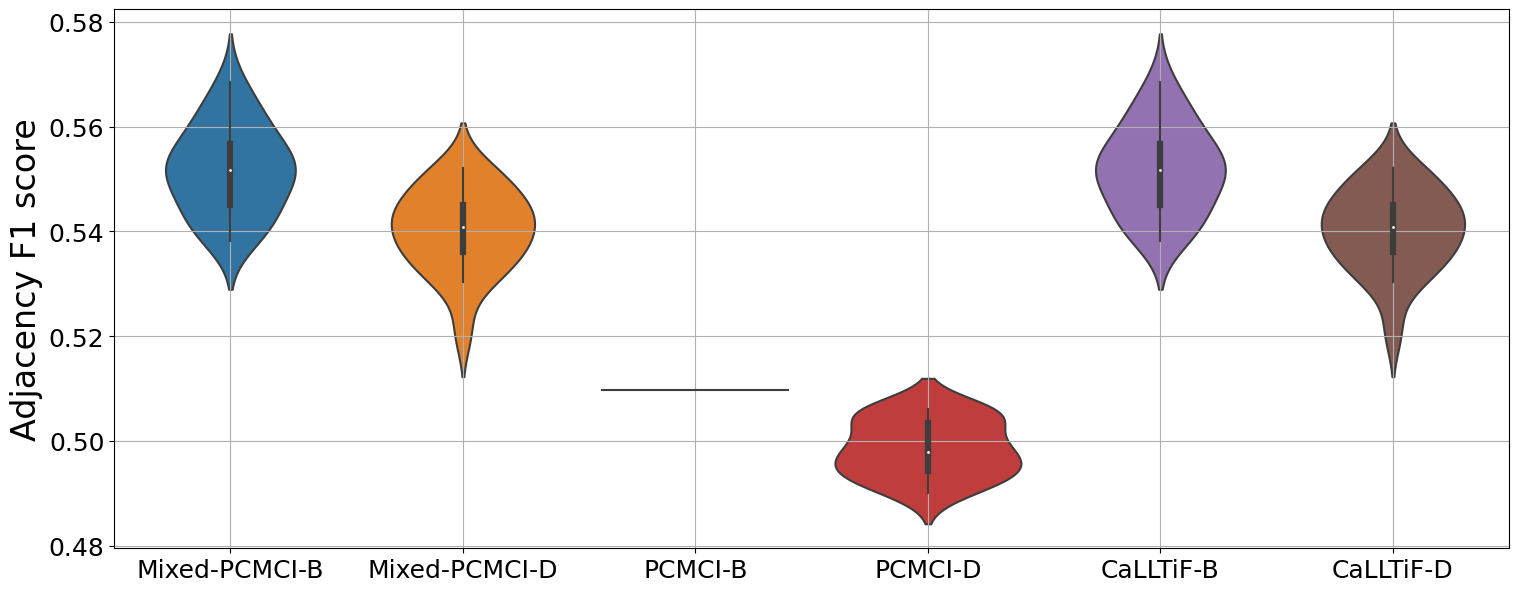

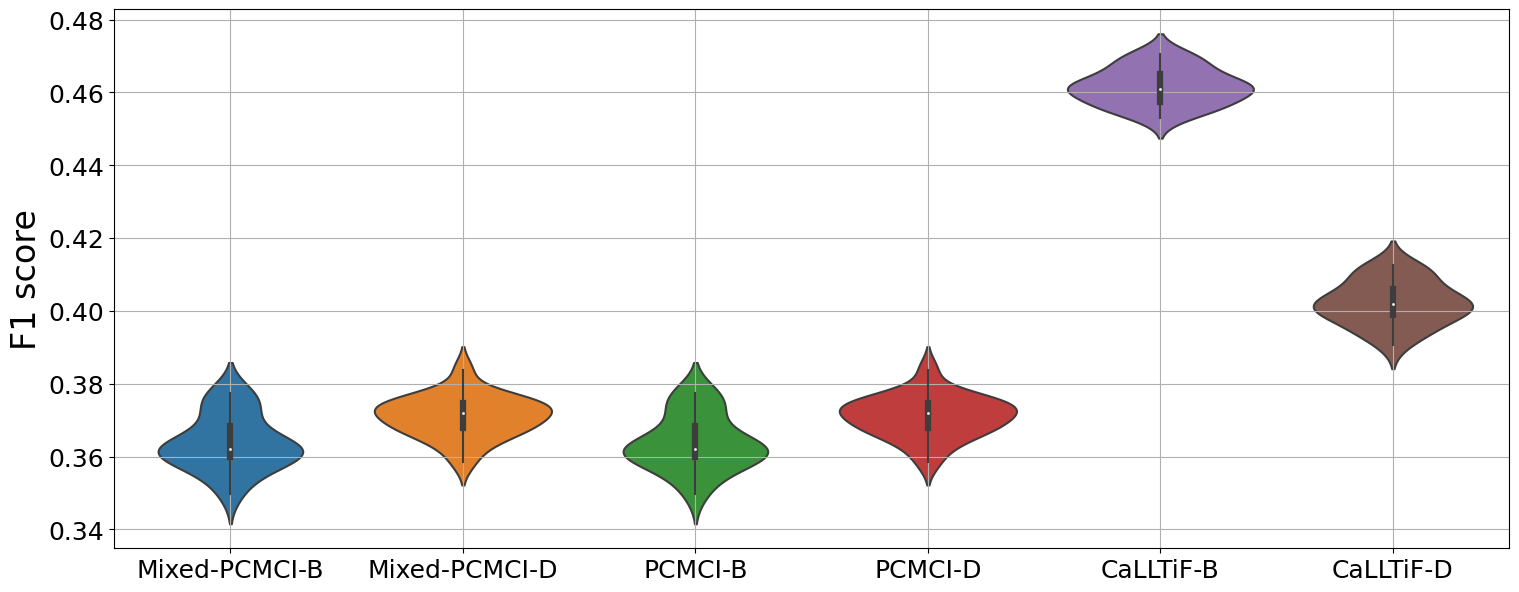

In [82]:
labels = ['Mixed-PCMCI-B','Mixed-PCMCI-D','PCMCI-B','PCMCI-D','CaLLTiF-B','CaLLTiF-D']


## Adjacency
plt.figure(figsize = (18,7))
ax1 = plt.subplot()

adj_all_methods_F1_score_dist  = []
adj_all_methods_F1_score_dist. append(np.array(mixed_pcmci_adj_F1_dist))
adj_all_methods_F1_score_dist. append(np.array(mixed_pcmci_deconv_adj_F1_dist))
adj_all_methods_F1_score_dist. append(np.array(pcmci_adj_F1_dist))
adj_all_methods_F1_score_dist. append(np.array(pcmci_deconv_adj_F1_dist))
adj_all_methods_F1_score_dist. append(np.array(calltif_adj_F1_dist))
adj_all_methods_F1_score_dist. append(np.array(calltif_deconv_adj_F1_dist))


parts = sb.violinplot(adj_all_methods_F1_score_dist)

plt.grid()

ax1.set_xticklabels(labels,fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('Adjacency F1 score',fontsize = 24)


## Orientation
plt.figure(figsize = (18,7))
ax2= plt.subplot()

ori_all_methods_F1_score_dist  = []
ori_all_methods_F1_score_dist. append(np.array(mixed_pcmci_ori_F1_dist))
ori_all_methods_F1_score_dist. append(np.array(mixed_pcmci_deconv_ori_F1_dist))
ori_all_methods_F1_score_dist. append(np.array(pcmci_ori_F1_dist))
ori_all_methods_F1_score_dist. append(np.array(pcmci_deconv_ori_F1_dist))
ori_all_methods_F1_score_dist. append(np.array(calltif_ori_F1_dist))
ori_all_methods_F1_score_dist. append(np.array(calltif_deconv_ori_F1_dist))

parts = sb.violinplot(ori_all_methods_F1_score_dist)
plt.grid()


ax2.set_xticklabels(labels,fontsize = 18)
plt.yticks(fontsize = 18)
plt.ylabel('F1 score',fontsize = 24)

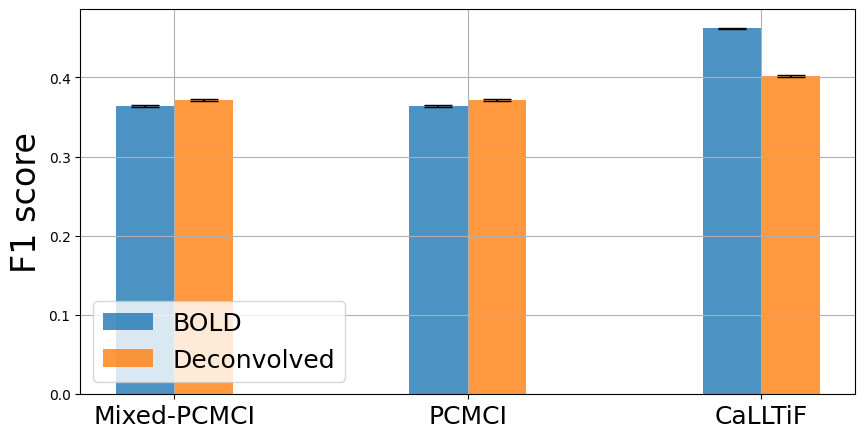

In [83]:
labels = ['Mixed-PCMCI','PCMCI','CaLLTiF']

means_1 = [np.mean(mixed_pcmci_ori_F1_dist),np.mean(pcmci_ori_F1_dist), np.mean(calltif_ori_F1_dist)]
stds_1 = [np.std(mixed_pcmci_ori_F1_dist),np.std(pcmci_ori_F1_dist), np.std(calltif_ori_F1_dist)]

means_2 = [np.mean(mixed_pcmci_deconv_ori_F1_dist),np.mean(pcmci_deconv_ori_F1_dist), np.mean(calltif_deconv_ori_F1_dist)]
stds_2 = [np.std(mixed_pcmci_deconv_ori_F1_dist),np.std(pcmci_deconv_ori_F1_dist), np.std(calltif_deconv_ori_F1_dist)]


X_axis = np.arange(len(labels))

plt.figure(figsize = (10,5))
  
plt.bar(X_axis - 0.1, means_1, 0.2, label = 'BOLD', yerr = stds_1/np.sqrt(num_rep_macaque), align='center', alpha=0.8, ecolor='black', capsize=10)
plt.bar(X_axis + 0.1, means_2, 0.2, label = 'Deconvolved', yerr = stds_2/np.sqrt(num_rep_macaque), align='center', alpha=0.8, ecolor='black', capsize=10)

plt.xticks(X_axis, labels, fontsize = 18)
plt.ylabel("F1 score", fontsize = 24)
plt.legend(fontsize = 18, loc = 'best')
plt.grid(visible = True)


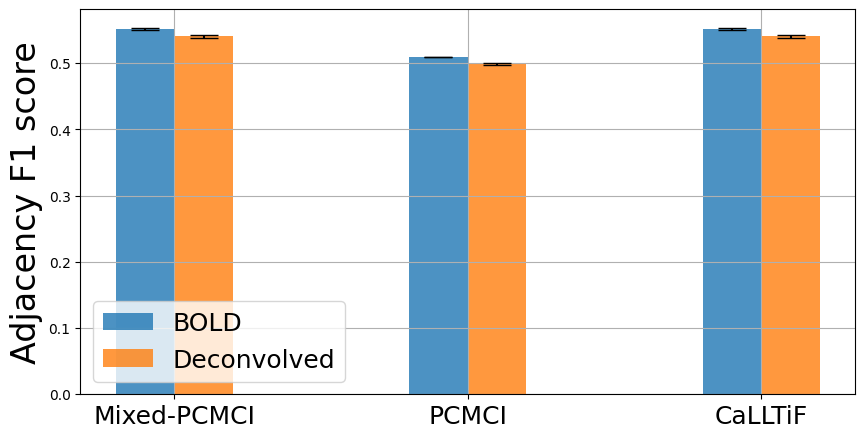

In [84]:
labels = ['Mixed-PCMCI','PCMCI','CaLLTiF']

means_1 = [np.mean(mixed_pcmci_adj_F1_dist),np.mean(pcmci_adj_F1_dist), np.mean(calltif_adj_F1_dist)]
stds_1 = [np.std(mixed_pcmci_adj_F1_dist),np.std(pcmci_adj_F1_dist), np.std(calltif_adj_F1_dist)]

means_2 = [np.mean(mixed_pcmci_deconv_adj_F1_dist),np.mean(pcmci_deconv_adj_F1_dist), np.mean(calltif_deconv_adj_F1_dist)]
stds_2 = [np.std(mixed_pcmci_deconv_adj_F1_dist),np.std(pcmci_deconv_adj_F1_dist), np.std(calltif_deconv_adj_F1_dist)]


X_axis = np.arange(len(labels))

plt.figure(figsize = (10,5))
  
plt.bar(X_axis - 0.1, means_1, 0.2, label = 'BOLD', yerr = stds_1/np.sqrt(num_rep_macaque), align='center', alpha=0.8, ecolor='black', capsize=10)
plt.bar(X_axis + 0.1, means_2, 0.2, label = 'Deconvolved', yerr = stds_2/np.sqrt(num_rep_macaque), align='center', alpha=0.8, ecolor='black', capsize=10)

plt.xticks(X_axis, labels, fontsize = 18)
plt.ylabel("Adjacency F1 score", fontsize = 24)
plt.legend(fontsize = 18, loc = 'best')
plt.grid(visible = True)


Text(0.5, 1.0, 'Adjacency')

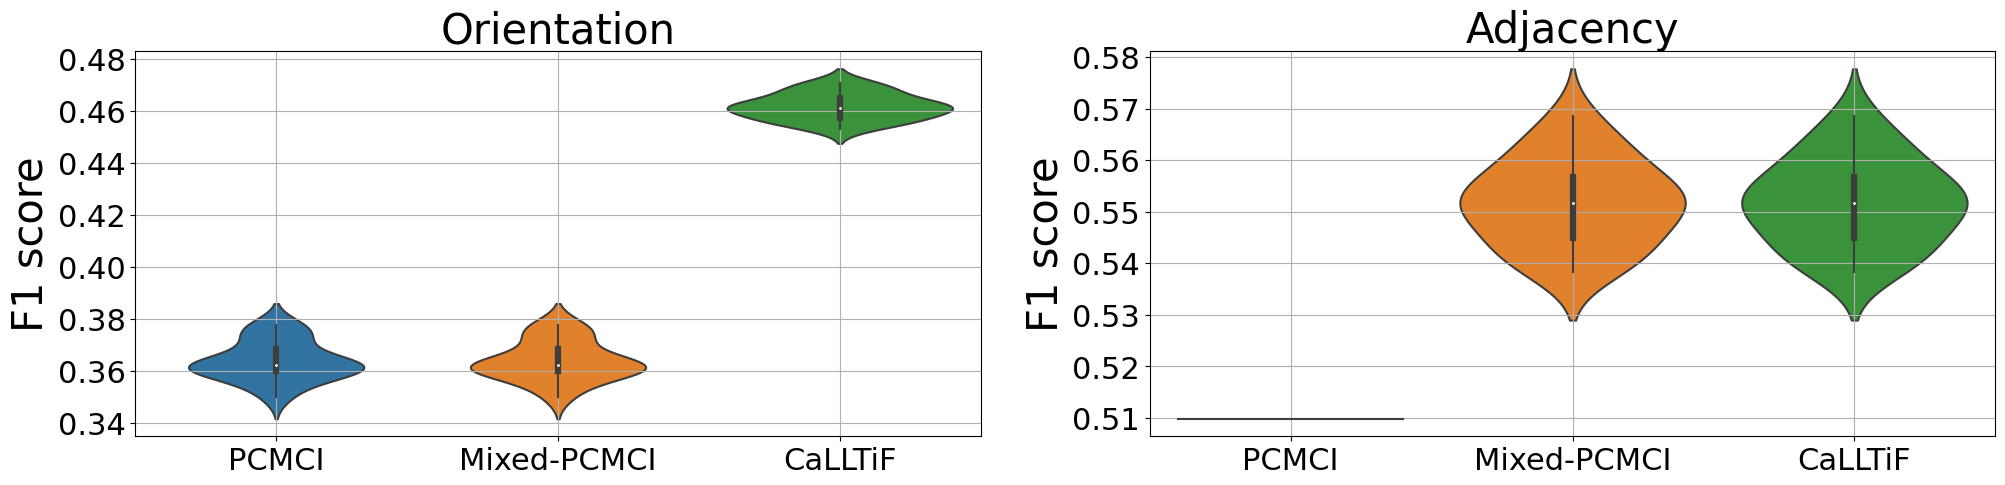

In [85]:
labels = ['PCMCI','Mixed-PCMCI','CaLLTiF']

## Adjacency
adj_all_methods_F1_score_dist  = []
adj_all_methods_F1_score_dist. append(np.array(pcmci_adj_F1_dist))
adj_all_methods_F1_score_dist. append(np.array(mixed_pcmci_adj_F1_dist))
adj_all_methods_F1_score_dist. append(np.array(calltif_adj_F1_dist))

## Orientation

ori_all_methods_F1_score_dist  = []
ori_all_methods_F1_score_dist. append(np.array(pcmci_ori_F1_dist))
ori_all_methods_F1_score_dist. append(np.array(mixed_pcmci_ori_F1_dist))
ori_all_methods_F1_score_dist. append(np.array(calltif_ori_F1_dist))

plt.figure(figsize = (24,5))
ax = plt.subplot(1,2,1)
parts = sns.violinplot(ori_all_methods_F1_score_dist)

ax.set_xticklabels(labels,fontsize = 22)
plt.yticks(fontsize = 22)
plt.grid()
plt.ylabel('F1 score',fontsize = 30)
plt.title('Orientation',fontsize = 30)

ax = plt.subplot(1,2,2)
parts = sns.violinplot(adj_all_methods_F1_score_dist)

ax.set_xticklabels(labels,fontsize = 22)
plt.yticks(fontsize = 22)
plt.grid()
plt.ylabel('F1 score',fontsize = 30)
plt.title('Adjacency',fontsize = 30)


In [86]:
test_calltif_pcmci_ori = sp.stats.wilcoxon(np.array(calltif_ori_F1_dist), np.array(pcmci_ori_F1_dist),zero_method='wilcox', alternative = 'greater')
test_calltif_pcmci_adj = sp.stats.wilcoxon(np.array(calltif_adj_F1_dist), np.array(pcmci_adj_F1_dist),zero_method='wilcox', alternative = 'greater')

print(test_calltif_pcmci_ori)
print(test_calltif_pcmci_adj)


WilcoxonResult(statistic=210.0, pvalue=9.5367431640625e-07)
WilcoxonResult(statistic=210.0, pvalue=9.5367431640625e-07)


In [87]:
test_calltif_pcmci_ori = sp.stats.wilcoxon(np.array(calltif_ori_F1_dist), np.array(pcmci_ori_F1_dist),zero_method='wilcox', alternative = 'greater').pvalue
test_calltif_mixedpcmci_ori = sp.stats.wilcoxon(np.array(calltif_ori_F1_dist), np.array(mixed_pcmci_ori_F1_dist),zero_method='wilcox', alternative = 'greater').pvalue

test_calltif_pcmci_adj = sp.stats.wilcoxon(np.array(calltif_adj_F1_dist), np.array(pcmci_adj_F1_dist),zero_method='wilcox', alternative = 'greater').pvalue
test_mixedpcmci_pcmci_adj = sp.stats.wilcoxon(np.array(mixed_pcmci_adj_F1_dist), np.array(pcmci_adj_F1_dist),zero_method='wilcox', alternative = 'greater').pvalue

print(test_calltif_pcmci_ori,test_calltif_mixedpcmci_ori,test_calltif_pcmci_adj, test_mixedpcmci_pcmci_adj  )

9.5367431640625e-07 9.5367431640625e-07 9.5367431640625e-07 9.5367431640625e-07


In [88]:
significant_combinations_ori = []
significant_combinations_ori.append([(3,1),test_calltif_pcmci_ori])
significant_combinations_ori.append([(3,2),test_calltif_mixedpcmci_ori])

significant_combinations_adj = []
significant_combinations_adj.append([(3,1),test_calltif_pcmci_ori])
significant_combinations_adj.append([(2,1),test_calltif_mixedpcmci_ori])

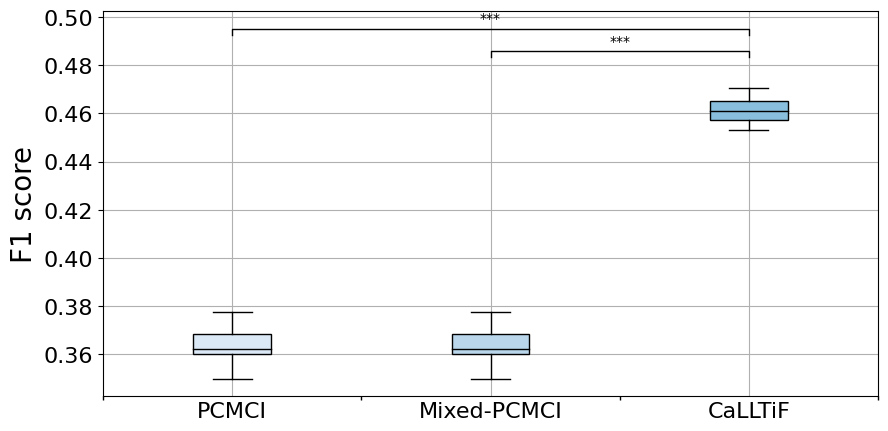

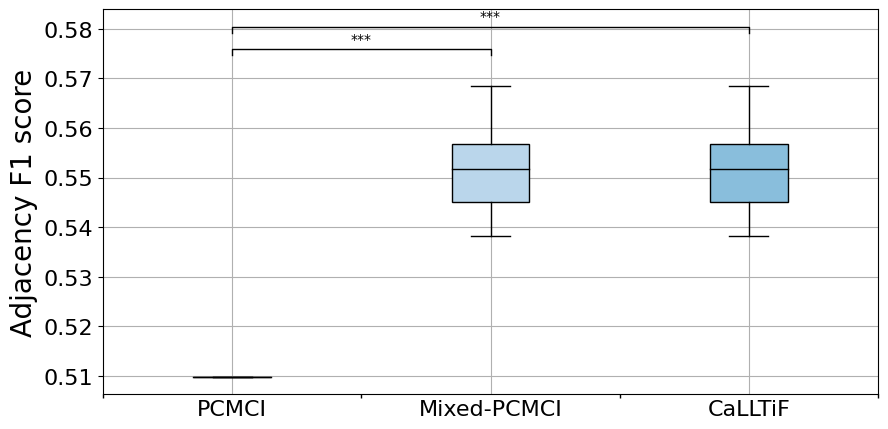

In [89]:
labels = ['PCMCI','Mixed-PCMCI','CaLLTiF']

plt.figure(figsize = (10,5))
ax = plt.subplot()
plt.yticks(fontsize = 16)
plt.grid()
plt.ylabel('F1 score',fontsize = 20)

# Create a boxplot on the axes
bp = ax.boxplot(ori_all_methods_F1_score_dist, widths=0.3, patch_artist=True)

# Label x-axis ticks
xticklabels = labels
ax.set_xticklabels(xticklabels, fontsize = 16)
ax.tick_params(axis='x', which='major', length=0)
xticks = [0.5] + [x + 0.5 for x in ax.get_xticks()]
ax.set_xticks(xticks, minor=True)
ax.tick_params(axis='x', which='minor', length=3, width=1)

colors = sns.color_palette('Blues')
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Colour of the median lines
plt.setp(bp['medians'], color='k')

# Get the y-axis limits
bottom, top = ax.get_ylim()
y_range = top - bottom

# Significance bars
for i, significant_combination in enumerate(significant_combinations_ori):
    # Columns corresponding to the datasets of interest
    x1 = significant_combination[0][0]
    x2 = significant_combination[0][1]
    level = len(significant_combinations_ori) - i
    # Plot the bar
    bar_height = (y_range * 0.07 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height + (y_range * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')

# adjacency
plt.figure(figsize = (10,5))
ax = plt.subplot()

plt.yticks(fontsize = 16)
plt.grid()
plt.ylabel('Adjacency F1 score',fontsize = 20)

bp = ax.boxplot(adj_all_methods_F1_score_dist, widths=0.3, patch_artist=True)

xticklabels = labels
ax.set_xticklabels(xticklabels, fontsize = 16)
ax.tick_params(axis='x', which='major', length=0)
xticks = [0.5] + [x + 0.5 for x in ax.get_xticks()]
ax.set_xticks(xticks, minor=True)
ax.tick_params(axis='x', which='minor', length=3, width=1)

# Change the colour of the boxes to Seaborn's 'pastel' palette
colors = sns.color_palette('Blues')
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Colour of the median lines
plt.setp(bp['medians'], color='k')

# Get the y-axis limits
bottom, top = ax.get_ylim()
y_range = top - bottom

# Significance bars
for i, significant_combination in enumerate(significant_combinations_adj):
    # Columns corresponding to the datasets of interest
    x1 = significant_combination[0][0]
    x2 = significant_combination[0][1]
    # What level is this bar among the bars above the plot?
    level = len(significant_combinations_adj) - i
    # Plot the bar
    bar_height = (y_range * 0.07 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height + (y_range * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')


## NTS-NOTEARS

In [90]:
num_rep_macaque = 15

### Execution Time

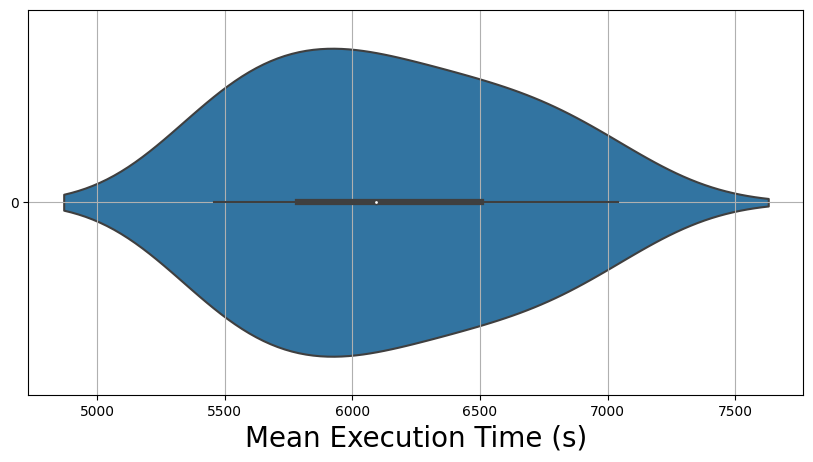

In [91]:
plt.figure(figsize = (10,5))
sns.violinplot( np.array(nts_notears_macaque_execution_time)[0:num_rep_macaque], orient='h')
plt.xlabel('Mean Execution Time (s)', fontsize = 20)
plt.grid()

### NTS-NOTEARS

In [92]:
nts_notears_adj_TPR_all_rep_macaque_both_alpha = [['' for j in range(0,len(w_threshold))] for i in range(0,num_rep_macaque )]
nts_notears_adj_FPR_all_rep_macaque_both_alpha  = [['' for j in range(0,len(w_threshold))] for i in range(0,num_rep_macaque )]
nts_notears_adj_Recall_all_rep_macaque_both_alpha  = [['' for j in range(0,len(w_threshold))] for i in range(0,num_rep_macaque )]
nts_notears_adj_Precision_all_rep_macaque_both_alpha  = [['' for j in range(0,len(w_threshold))] for i in range(0,num_rep_macaque )]
nts_notears_adj_F1_score_all_rep_macaque_both_alpha  = [['' for j in range(0,len(w_threshold))] for i in range(0,num_rep_macaque )]

nts_notears_ori_TPR_all_rep_macaque_both_alpha  = [['' for j in range(0,len(w_threshold))] for i in range(0,num_rep_macaque )]
nts_notears_ori_FPR_all_rep_macaque_both_alpha  = [['' for j in range(0,len(w_threshold))] for i in range(0,num_rep_macaque )]
nts_notears_ori_Recall_all_rep_macaque_both_alpha  = [['' for j in range(0,len(w_threshold))] for i in range(0,num_rep_macaque )]
nts_notears_ori_Precision_all_rep_macaque_both_alpha  = [['' for j in range(0,len(w_threshold))] for i in range(0,num_rep_macaque )]
nts_notears_ori_F1_score_all_rep_macaque_both_alpha  = [['' for j in range(0,len(w_threshold))] for i in range(0,num_rep_macaque )]

macaque_ground_truth = ground_truth_graph_matrix_macaques_full
binarized_graphs_all = []
for r in range(0,num_rep_macaque):
    for w in range(0, len(w_threshold)):

            PAG = np.array(nts_notears_link_matrix_all_macaque[r])
            
            PAG [PAG < w_threshold[w]] = 0
            PAG [PAG >= w_threshold[w]] = 1

            PAG_summarized_across_lags = np.sum(PAG, axis = 2)

            PAG_summarized_across_lags[PAG_summarized_across_lags >= 1] = 1
            
            binarized_graphs_all.append(PAG_summarized_across_lags)
            adjacency_TPR, adjacency_FPR, adjacency_Recall, adjacency_Precision, adjacency_F1_score, orientation_TPR, orientation_FPR, orientation_Recall,orientation_Precision,orientation_F1_score = find_tpr_fpr_nonzero_lags(macaque_ground_truth, PAG_summarized_across_lags)
            
            nts_notears_adj_TPR_all_rep_macaque_both_alpha[r][w] = adjacency_TPR
            nts_notears_adj_FPR_all_rep_macaque_both_alpha[r][w]  = adjacency_FPR
            nts_notears_adj_Recall_all_rep_macaque_both_alpha[r][w]  = adjacency_Recall
            nts_notears_adj_Precision_all_rep_macaque_both_alpha[r][w] = adjacency_Precision
            nts_notears_adj_F1_score_all_rep_macaque_both_alpha[r][w] = adjacency_F1_score

            nts_notears_ori_TPR_all_rep_macaque_both_alpha[r][w] = orientation_TPR
            nts_notears_ori_FPR_all_rep_macaque_both_alpha[r][w]= orientation_FPR
            nts_notears_ori_Recall_all_rep_macaque_both_alpha[r][w] = orientation_Recall
            nts_notears_ori_Precision_all_rep_macaque_both_alpha[r][w]  = orientation_Precision
            nts_notears_ori_F1_score_all_rep_macaque_both_alpha[r][w] = orientation_F1_score


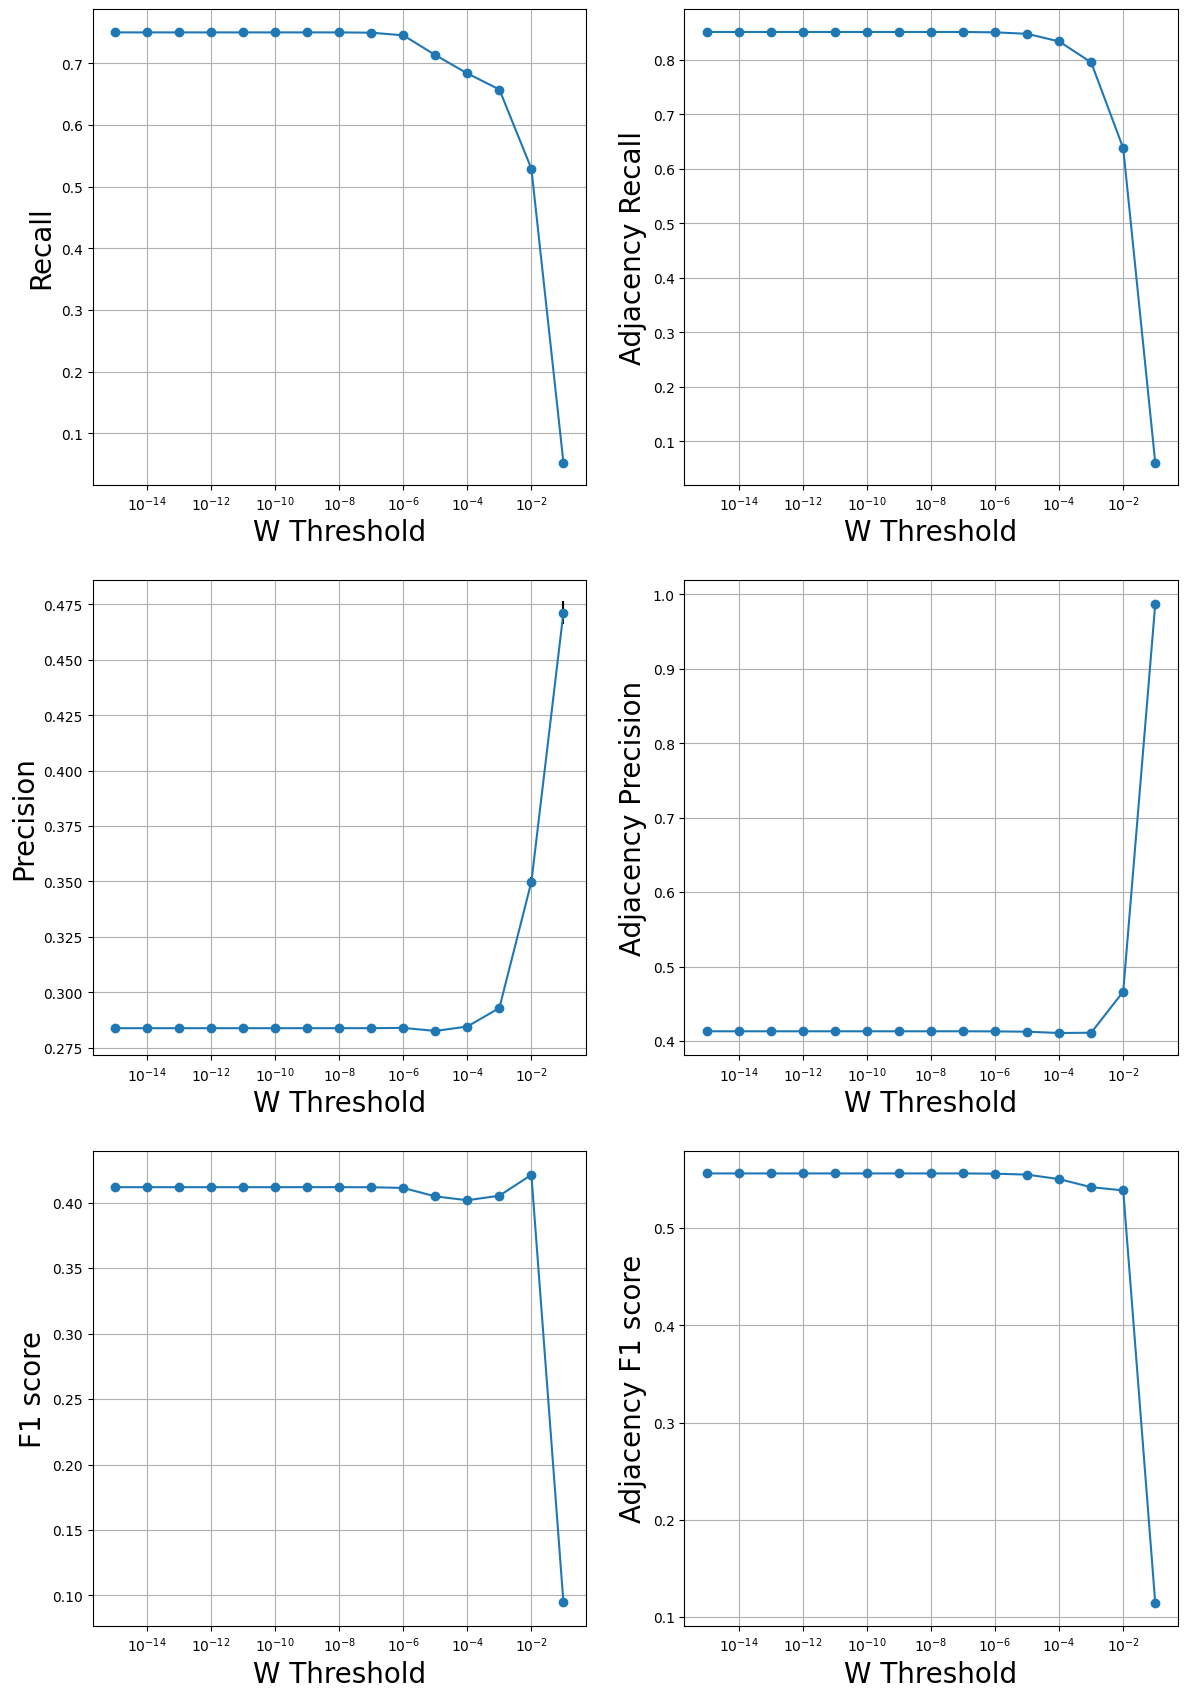

In [93]:
plt.figure(figsize = (14, 21))

nts_notears_adj_recall_mean_macaque = np.zeros_like(w_threshold)
nts_notears_adj_recall_std_macaque = np.zeros_like(w_threshold)
nts_notears_adj_recall_median_macaque = np.zeros_like(w_threshold)

nts_notears_adj_precision_mean_macaque = np.zeros_like(w_threshold) 
nts_notears_adj_precision_std_macaque = np.zeros_like(w_threshold)
nts_notears_adj_precision_median_macaque = np.zeros_like(w_threshold) 

nts_notears_adj_F1_score_mean_macaque = np.zeros_like(w_threshold) 
nts_notears_adj_F1_score_std_macaque = np.zeros_like(w_threshold)
nts_notears_adj_F1_score_median_macaque = np.zeros_like(w_threshold) 

nts_notears_ori_recall_mean_macaque = np.zeros_like(w_threshold)
nts_notears_ori_recall_std_macaque = np.zeros_like(w_threshold)
nts_notears_ori_recall_median_macaque = np.zeros_like(w_threshold)

nts_notears_ori_precision_mean_macaque = np.zeros_like(w_threshold)
nts_notears_ori_precision_std_macaque = np.zeros_like(w_threshold)
nts_notears_ori_precision_median_macaque = np.zeros_like(w_threshold)

nts_notears_ori_F1_score_mean_macaque = np.zeros_like(w_threshold)
nts_notears_ori_F1_score_std_macaque =np.zeros_like(w_threshold)
nts_notears_ori_F1_score_median_macaque = np.zeros_like(w_threshold)


for w in range(0,len(w_threshold)):

    nts_notears_adj_recall_mean_macaque[w] = np.mean(np.array(nts_notears_adj_Recall_all_rep_macaque_both_alpha)[:,w])
    nts_notears_adj_recall_std_macaque[w] = np.std(np.array(nts_notears_adj_Recall_all_rep_macaque_both_alpha)[:,w])
    nts_notears_adj_recall_median_macaque[w] = np.median(np.array(nts_notears_adj_Recall_all_rep_macaque_both_alpha)[:,w])

    nts_notears_adj_precision_mean_macaque[w] = np.mean(np.array(nts_notears_adj_Precision_all_rep_macaque_both_alpha)[:,w])
    nts_notears_adj_precision_std_macaque[w] = np.std(np.array(nts_notears_adj_Precision_all_rep_macaque_both_alpha)[:,w])
    nts_notears_adj_precision_median_macaque[w] = np.median(np.array(nts_notears_adj_Precision_all_rep_macaque_both_alpha)[:,w])

    nts_notears_adj_F1_score_mean_macaque[w] = np.mean(np.array(nts_notears_adj_F1_score_all_rep_macaque_both_alpha)[:,w])
    nts_notears_adj_F1_score_std_macaque[w] = np.std(np.array(nts_notears_adj_F1_score_all_rep_macaque_both_alpha)[:,w])
    nts_notears_adj_F1_score_median_macaque[w] = np.median(np.array(nts_notears_adj_F1_score_all_rep_macaque_both_alpha)[:,w])

    nts_notears_ori_recall_mean_macaque[w] = np.mean(np.array(nts_notears_ori_Recall_all_rep_macaque_both_alpha)[:,w])
    nts_notears_ori_recall_std_macaque[w] = np.std(np.array(nts_notears_ori_Recall_all_rep_macaque_both_alpha)[:,w])
    nts_notears_ori_recall_median_macaque[w] = np.median(np.array(nts_notears_ori_Recall_all_rep_macaque_both_alpha)[:,w])

    nts_notears_ori_precision_mean_macaque[w] = np.mean(np.array(nts_notears_ori_Precision_all_rep_macaque_both_alpha)[:,w])
    nts_notears_ori_precision_std_macaque[w] = np.std(np.array(nts_notears_ori_Precision_all_rep_macaque_both_alpha)[:,w])
    nts_notears_ori_precision_median_macaque[w] = np.median(np.array(nts_notears_ori_Precision_all_rep_macaque_both_alpha)[:,w])

    nts_notears_ori_F1_score_mean_macaque[w] = np.mean(np.array(nts_notears_ori_F1_score_all_rep_macaque_both_alpha)[:,w])
    nts_notears_ori_F1_score_std_macaque[w] = np.std(np.array(nts_notears_ori_F1_score_all_rep_macaque_both_alpha)[:,w])
    nts_notears_ori_F1_score_median_macaque[w] = np.median(np.array(nts_notears_ori_F1_score_all_rep_macaque_both_alpha)[:,w])

nts_notears_best_alpha_adj_mean= w_threshold[np.argmax(nts_notears_adj_F1_score_mean_macaque)]
nts_notears_best_alpha_adj_median = w_threshold[np.argmax(nts_notears_adj_F1_score_median_macaque)]
nts_notears_best_alpha_ori_mean = w_threshold[np.argmax(nts_notears_ori_F1_score_mean_macaque)]
nts_notears_best_alpha_ori_median = w_threshold[np.argmax(nts_notears_ori_F1_score_median_macaque)]

plt.subplot(3,2,2)
plt.errorbar(w_threshold, nts_notears_adj_recall_mean_macaque, nts_notears_adj_recall_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('W Threshold', fontsize = 20)
plt.ylabel('Adjacency Recall', fontsize = 20)
plt.grid()
plt.grid(visible = True)


plt.subplot(3,2,1)
plt.errorbar(w_threshold, nts_notears_ori_recall_mean_macaque, nts_notears_ori_recall_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('W Threshold', fontsize = 20)
plt.ylabel('Recall', fontsize = 20)
plt.grid(visible = True)


plt.subplot(3,2,4)
plt.errorbar(w_threshold, nts_notears_adj_precision_mean_macaque, nts_notears_adj_precision_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('W Threshold', fontsize = 20)
plt.ylabel('Adjacency Precision', fontsize = 20)
plt.grid(visible = True)


plt.subplot(3,2,3)
plt.errorbar(w_threshold, nts_notears_ori_precision_mean_macaque, nts_notears_ori_precision_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('W Threshold', fontsize = 20)
plt.ylabel('Precision', fontsize = 20)
plt.grid(visible = True)


plt.subplot(3,2,6)
plt.errorbar(w_threshold, nts_notears_adj_F1_score_mean_macaque, nts_notears_adj_F1_score_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('W Threshold', fontsize = 20)
plt.ylabel('Adjacency F1 score', fontsize = 20)
plt.grid(visible = True)


plt.subplot(3,2,5)
plt.errorbar(w_threshold, nts_notears_ori_F1_score_mean_macaque, nts_notears_ori_F1_score_std_macaque/np.sqrt(num_rep_macaque), ecolor = 'black', fmt = '-o')
plt.xscale('log')
plt.xlabel('W Threshold', fontsize = 20)
plt.ylabel('F1 score', fontsize = 20)
plt.grid(visible = True)
